<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Allianz/Allianz_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "ALVDEEUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-28 11:47:01,186 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-28 11:47:01,187 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for ALVDEEUR
2019-08-28 11:49:54,843 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-28 11:52:15,020 - findatapy.market.datavendorweb - WARNING - Problem downloading.. HTTPConnectionPool(host='datafeed.dukascopy.com', port=80): Read timed out. (read timeout=10)
2019-08-28 11:56:03,789 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-28 11:59:01,215 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-28 12:01:38,140 - findatapy.market.datavendorweb - WARNING - Problem downloading.. HTTPConnectionPool(host='datafeed.dukascopy.com', port=80): Read timed out. (read timeout=10)
2019-08-28 12:01:50,185 - findatapy.market.datavendorweb - WARNING - Problem downloading.. HTTPConnectionPool(host='datafee

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-28 12:22:43,355 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_ALVDEEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-ALVDEEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-ALVDEEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 08:00:00  1.91687  1.92858  1.91228  1.91948  85.143776
2018-01-02 09:00:00  1.91937  1.92277  1.90457  1.91027  72.249908
2018-01-02 10:00:00  1.91028  1.91958  1.91018  1.91657  37.364281
2018-01-02 11:00:00  1.91658  1.91898  1.91357  1.91578  30.487045
2018-01-02 12:00:00  1.91577  1.91698  1.91438  1.91577  17.663847
...                      ...      ...      ...      ...        ...
2018-12-28 08:00:00  1.72178  1.74218  1.72178  1.74198  46.422348
2018-12-28 09:00:00  1.74178  1.74377  1.73597  1.74357  53.723831
2018-12-28 10:00:00  1.74338  1.75298  1.74257  1.75017  39.945435
2018-12-28 11:00:00  1.75037  1.75918  1.74677  1.75378  35.628971
2018-12-28 12:00:00  1.75378  1.75877  1.75277  1.75697  34.192638

[2248 rows x 5 columns]

Open         High          Low        Close       Volume
count  2248.000000  2248.000000  2248.000000  2248.000000  2248.000000
mean      1.873636     1.878337     1.868821     1.873606    42.497013
std       0.073320     0.072984     0.073804     0.073406    25.481480
min       1.704780     1.714180     1.700870     1.704780     0.001004
25%       1.821523     1.826378     1.814722     1.821177    24.053136
50%       1.870375     1.874675     1.865570     1.870320    36.727219
75%       1.915380     1.919780     1.910372     1.915428    54.937027
max       2.065980     2.067480     2.062970     2.065970   167.302994

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close     Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
2018-01-09 13:00:00  1.98878  1.99278  1.98857  1.99277  17.637878    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  1.989049  1.971039  1.986884  1.991982  1.990562  1.988543    1.990175    1.991120  1.987370  1.990511  1.990792  1.990604  1.990809  1.990511  1.990637  1.986532                1.994213                 1.990511                1.986809                1.996064                 1.990511                1.984958                1.997915                 1.990511                1.983107                1.999766                 1.990511                1.981256  1.990562  1.991319  1.987749                1.994264                 1.990562                1.986860                1.996115                 1.990562                1.985009                1.997966                 1.990562                1.983158                1.999817                 1.990562                1.981307   
2018-01-09 14:00:00  1.99278  1.99378  1.98937  1.99178  31.668394    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  1.990414  1.975883  1.987370  1.992148  1.990833  1.988570    1.990175    1.991120  1.987370  1.990612  1.991141  1.990814  1.991091  1.990612  1.992275  1.987196                1.994402                 1.990612                1.986823                1.996297                 1.990612                1.984928                1.998192                 1.990612                1.983033                2.000087                 1.990612                1.981138  1.990833  1.991746  1.988287                1.994623                 1.990833                1.987043                1.996518                 1.990833                1.985148                1.998412                 1.990833                1.983253                2.000307                 1.990833                1.981358   
2018-01-09 15:00:00 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000    2198.000000  2198.000000   2198.000000     2198.000000       2198.000000  2198.000000  2198.000000  2198.000000  2198.000000   2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000  2198.000000  2198.000000  2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000             2198.000000   
mean      1.871747     1.876454     1.866903     1.871705    42.687035    15.966333     2.031392   184.349864      30.415833    11.379436      0.032302        0.024113          0.004095     6.562784     2.522748    26.902639     2.031392      1.989081    26.902639     1.872448     1.873468     0.104761     1.871693     1.872097     1.872249     1.871889     1.871393     1.871364     1.872091     1.871691     1.872088     1.871959     1.872091     1.871750     1.872904                1.886665                 1.872091                1.857517                1.893953                 1.872091                1.850229                1.901240                 1.872091                1.842942                1.908527                 1.872091                1.835655     1.872097     1.871775     1.872786                1.886672                 1.872097                1.857523                1.893959                 1.872097                1.850236                1.901246   
std       0.072923     0.072593     0.073384     0.072998    25.589466     8.543804     1.407250   101.416032       0.857091     2.621951      0.176841        0.153434          0.063873     3.339045     1.100412    14.487877     1.407250      1.400263    14.487877     0.072533     0.071131     1.869414     0.073160     0.072229     0.071915     0.072518     0.072637     0.073705     0.072462     0.073097     0.072575     0.072552     0.072462     0.072874     0.071498                0.071847                 0.072462                0.074277                0.072002                 0.072462                0.075610                0.072463                 0.072462                0.077208                0.073226                 0.072462                0.079055     0.072229     0.072792     0.071640                0.071595                 0.072229                0.074065                0.071743                 0.072229                0.075410                0.072197   
min       1.704780     1.714180     1.700870     1.704780     0.001004     1.000000     0.000000     9.000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.786268  0.788565  0.794532  0.797337  0.105419    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.797502  0.749123  0.984782  0.793950  0.794514  0.787480    0.795948    0.800454  0.781484  0.792846  0.789320  0.790996  0.792721  0.792846  0.790190  0.787189                0.775004                 0.792846                0.810219                0.766021                 0.792846                0.821242                0.739100                 0.792846                0.833008                0.678930                 0.792846                0.843806  0.794514  0.794054  0.790314                0.776707                 0.794514                0.810941                0.769935                 0.794514                0.821184                0.755199                 0.794514                0.833827                0.691870                 0.794514   
2018-01-09 14:00:00  0.797342  0.791395  0.796741  0.794596  0.189283    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.801453  0.763862  0.984901  0.794419  0.795305  0.787563    0.795948    0.800454  0.781484  0.793144  0.790300  0.791606  0.793538  0.793144  0.794856  0.789197                0.775563                 0.793144                0.810257                0.766704                 0.793144                0.821159                0.739887                 0.793144                0.832814                0.679771                 0.793144                0.843510  0.795305  0.795263  0.791936                0.777772                 0.795305                0.811460                0.771128                 0.795305                0.821569                0.756504                 0.795305                0.834079                0.693189                 0.795305   
2018-01-09 15:00:00  0.794297  0.807784  0.800608  0.810100  0.165602    9          1          9         

139783

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmporzigvej
  JVM stdout: /tmp/tmporzigvej/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmporzigvej/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_zmi1s6
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_123229_mod...  0.719527  0.760326              0.335219  0.481104  0.231462
1  DeepLearning_grid_1_AutoML_20190828_123229_mod...  0.719527  0.645383              0.353232  0.467551  0.218604
2  DeepLearning_grid_1_AutoML_20190828_123229_mod...  0.716283  0.658729              0.337174  0.464423  0.215689
3  DeepLearning_grid_1_AutoML_20190828_123229_mod...  0.714619  0.633880              0.308054  0.466603  0.217719
4  DeepLearning_grid_1_AutoML_20190828_123229_mod...  0.707630  2.378670              0.328314  0.553346  0.306192
5  DeepLearning_grid_1_AutoML_20190828_123229_mod...  0.705092  0.627683              0.371246  0.465669  0.216848
6  DeepLearning_grid_1_AutoML_20190828_123229_mod...  0.701265  0.668987              0.335219  0.476144  0.226713
7  DeepLearning_grid_1_AutoML_20190828_123229_mod...  0.693402  0.811931              0.378734  0.494756  0.244784
8  DeepLearning_grid_1_AutoML_20190828_123229_mod...  0.687495  1.343015              0.352775  0.563637  0.317687
9              DeepLearning_1_AutoML_20190828_123229  0.659705  0.734233              0.391048  0.497789  0.247794

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.004475
1               CDLEVENINGSTAR             0.765685           0.765685    0.003426
2           CDLCLOSINGMARUBOZU             0.752733           0.752733    0.003368
3           CDLIDENTICAL3CROWS             0.703487           0.703487    0.003148
4                 CDLTHRUSTING             0.699888           0.699888    0.003132
...                        ...                  ...                ...         ...
1033                      SINH             0.168071           0.168071    0.000752
1034  BBANDS_middleband_20_1_4             0.167146           0.167146    0.000748
1035   BBANDS_upperband_12_5_5             0.164973           0.164973    0.000738
1036   BBANDS_upperband_12_5_2             0.162790           0.162790    0.000728
1037  BBANDS_middleband_20_0_2             0.157162           0.157162    0.000703

[1038 rows x 4 columns]

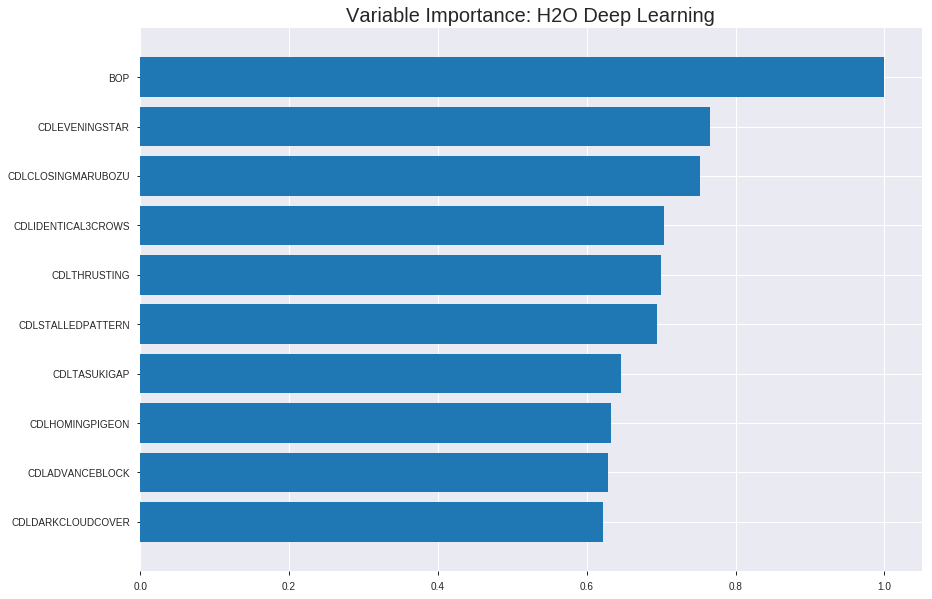

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_123229_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18633945651591172
RMSE: 0.43167054163552987
LogLoss: 0.5650052556243105
Mean Per-Class Error: 0.2706266960651289
AUC: 0.8042528833107191
pr_auc: 0.7578969631811736
Gini: 0.6085057666214382
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44075617499787717: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      499  301  0.3762   (301.0/800.0)
1      125  612  0.1696   (125.0/737.0)
Total  624  913  0.2772   (426.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440756     0.741818  231
max f2                       0.186722     0.853218  320
max f0point5                 0.664689     0.727083  148
max accuracy                 0.642633     0.731295  156
max precision                0.998668     1         0
max recall                   0.00231205   1         397
max specificity              0.998668     1         0
max absolute_mcc             0.44319      0.462481  230
max min_per_class_accuracy   0.578444     0.72      179
max mean_per_class_accuracy  0.639655     0.729373  157

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 52.61 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.994254           1.8248     1.8248             0.875            0.997232   0.875                       0.997232            0.0189959       0.0189959                  82.4796   82.4796
    2        0.0201692                   0.986395           2.08548    1.95093            1                0.990999   0.935484                    0.994216            0.0203528       0.0393487                  108.548   95.0934
    3        0.0305791                   0.980339           1.95514    1.95237            0.9375           0.982676   0.93617                     0.990288            0.0203528       0.0597015                  95.5139   95.2366
    4        0.0403383                   0.9745             1.39032    1.81639            0.666667         0.977937   0.870968                    0.9873              0.0135685       0.07327                    39.0321   81.6387
    5        0.0500976                   0.967808           1.52935    1.76047            0.733333         0.97101    0.844156                    0.984126            0.0149254       0.0881954                  52.9353   76.0472
    6        0.100195                    0.939893           1.7063     1.73339            0.818182         0.954706   0.831169                    0.969416            0.0854817       0.173677                   70.6303   73.3387
    7        0.150293                    0.902308           1.73339    1.73339            0.831169         0.922723   0.831169                    0.953852            0.0868385       0.260516                   73.3387   73.3387
    8        0.20039                     0.862365           1.73339    1.73339            0.831169         0.880704   0.831169                    0.935565            0.0868385       0.347354                   73.3387   73.3387
    9        0.299935                    0.777572           1.45847    1.64215            0.699346         0.820865   0.787419                    0.897497            0.145183        0.492537                   45.8474   64.2147
    10       0.40013                     0.68744            1.36775    1.57344            0.655844         0.731211   0.754472                    0.855858            0.137042        0.629579                   36.7751   57.3437
    11       0.500325                    0.569642           0.97503    1.4536             0.467532         0.630324   0.697009                    0.810693            0.0976934       0.727273                   -2.49696  45.36
    12       0.59987                     0.431839           1.04956    1.38655            0.503268         0.498809   0.664859                    0.758938            0.104478        0.83175                    4.95561   38.6551
    13       0.700065                    0.305123           0.731273   1.29277            0.350649         0.368441   0.619888                    0.703049            0.07327         0.90502                    -26.8727  29.2766
    14       0.79961                     0.163155           0.586116   1.20479            0.281046         0.228769   0.577705                    0.644005            0.0583446       0.963365                   -41.3884  20.4794
    15       0.899805                    0.0408527          0.311468   1.10532            0.149351         0.0996205  0.530007                    0.583387            0.0312076       0.994573                   -68.8532  10.532
    16       1                           1.90503e-06        0.0541684  1                  0.025974         0.0118722  0.479506    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2000356215864826
RMSE: 0.44725341987119854
LogLoss: 0.6116622444398555
Mean Per-Class Error: 0.2732457227870072
AUC: 0.7818518059343748
pr_auc: 0.7532529712802307
Gini: 0.5637036118687495
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2624893236678732: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      124  94   0.4312   (94.0/218.0)
1      31   191  0.1396   (31.0/222.0)
Total  155  285  0.2841   (125.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.262489     0.753452  265
max f2                       0.0818475    0.866237  331
max f0point5                 0.448846     0.722621  206
max accuracy                 0.394095     0.727273  229
max precision                0.998407     1         0
max recall                   0.000937549  1         395
max specificity              0.998407     1         0
max absolute_mcc             0.394095     0.45669   229
max min_per_class_accuracy   0.454848     0.715596  204
max mean_per_class_accuracy  0.394095     0.726754  229

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 44.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.98405            1.98198   1.98198            1                0.990786    1                           0.990786            0.0225225       0.0225225                  98.1982   98.1982
    2        0.0204545                   0.971872           1.48649   1.76176            0.75             0.977413    0.888889                    0.984843            0.0135135       0.036036                   48.6486   76.1762
    3        0.0318182                   0.964723           1.58559   1.69884            0.8              0.968413    0.857143                    0.978975            0.018018        0.0540541                  58.5586   69.8842
    4        0.0409091                   0.95829            1.98198   1.76176            1                0.960566    0.888889                    0.974884            0.018018        0.0720721                  98.1982   76.1762
    5        0.05                        0.941329           1.98198   1.8018             1                0.954406    0.909091                    0.971161            0.018018        0.0900901                  98.1982   80.1802
    6        0.1                         0.878163           1.35135   1.57658            0.681818         0.911524    0.795455                    0.941342            0.0675676       0.157658                   35.1351   57.6577
    7        0.15                        0.817983           1.89189   1.68168            0.954545         0.846004    0.848485                    0.909563            0.0945946       0.252252                   89.1892   68.1682
    8        0.2                         0.766652           1.08108   1.53153            0.545455         0.78906     0.772727                    0.879437            0.0540541       0.306306                   8.10811   53.1532
    9        0.3                         0.671549           1.3964    1.48649            0.704545         0.724634    0.75                        0.827836            0.13964         0.445946                   39.6396   48.6486
    10       0.4                         0.565803           1.44144   1.47523            0.727273         0.610638    0.744318                    0.773536            0.144144        0.59009                    44.1441   47.5225
    11       0.5                         0.45703            1.21622   1.42342            0.613636         0.515242    0.718182                    0.721878            0.121622        0.711712                   21.6216   42.3423
    12       0.6                         0.336061           1.03604   1.35886            0.522727         0.39752     0.685606                    0.667818            0.103604        0.815315                   3.6036    35.8859
    13       0.7                         0.200034           0.675676  1.26126            0.340909         0.263031    0.636364                    0.609991            0.0675676       0.882883                   -32.4324  26.1261
    14       0.8                         0.0821811          0.810811  1.20495            0.409091         0.131128    0.607955                    0.550133            0.0810811       0.963964                   -18.9189  20.4955
    15       0.9                         0.0182119          0.225225  1.0961             0.113636         0.0482596   0.55303                     0.49437             0.0225225       0.986486                   -77.4775  9.60961
    16       1                           3.0392e-06         0.135135  1                  0.0681818        0.00579208  0.504545 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:34:55  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 12:34:57  2 min 21.232 sec  461 obs/sec       0.44242   1             680        0.625493         4.7217              -0.5676        0.612832        0.581109           1.56411          0.520494                         0.648847           3.74233               -0.684151        0.631065          0.604796             1.18919            0.434091
    2019-08-28 12:35:06  2 min 30.258 sec  497 obs/sec       3.12622   7             4805       0.588723         2.95332             -0.38871       0.682873        0.447772           1.56411          0.374756                         0.571068           2.40234               -0.304583        0.728738          0.684546             1.58559            0.356818
    2019-08-28 12:35:15  2 min 38.909 sec  515 obs/sec       5.84255   13            8980       0.520623         1.72466             -0.0860179     0.754606        0.574438           1.95514          0.32661                          0.522724           1.71571               -0.0930522       0.743729          0.681948             1.18919            0.352273
    2019-08-28 12:35:25  2 min 49.015 sec  516 obs/sec       8.9525    20            13760      0.518177         1.72927             -0.0758388     0.739113        0.490938           1.95514          0.322056                         0.534982           1.48725               -0.144916        0.750847          0.70261              1.98198            0.311364
    2019-08-28 12:35:34  2 min 58.708 sec  525 obs/sec       12.121    27            18630      0.506521         1.19239             -0.027982      0.768259        0.723236           1.8248           0.340924                         0.527416           1.19561               -0.112762        0.732457          0.695494             1.58559            0.345455
    2019-08-28 12:35:44  3 min  8.130 sec  531 obs/sec       15.2316   34            23411      0.456602         0.799002            0.164656       0.79132         0.744717           1.8248           0.314899                         0.497817           1.02985               0.00863283       0.74595           0.712042             1.58559            0.315909
    2019-08-28 12:35:52  3 min 16.488 sec  534 obs/sec       17.9564   40            27599      0.482419         0.83684             0.0675199      0.750695        0.645012           1.8248           0.319453                         0.488733           0.77145               0.0444815        0.746126          0.723595             1.98198            0.318182
    2019-08-28 12:36:01  3 min 25.041 sec  537 obs/sec       20.7274   46            31858      0.441644         0.605081            0.218489       0.799749        0.754355           1.95514          0.29473                          0.457916           0.665422              0.161181         0.762904          0.725706             1.58559            0.284091
    2019-08-28 12:36:10

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.004474877686194764
CDLEVENINGSTAR            0.7656852602958679     0.7656852602958679   0.003426347885946209
CDLCLOSINGMARUBOZU        0.7527328729629517     0.7527328729629517   0.00336838753688719
CDLIDENTICAL3CROWS        0.7034865021705627     0.7034865021705627   0.0031480160511022552
CDLTHRUSTING              0.6998881697654724     0.6998881697654724   0.003131913953715205
---                       ---                    ---                  ---
SINH                      0.1680709272623062     0.1680709272623062   0.0007520968421041572
BBANDS_middleband_20_1_4  0.16714642941951752    0.16714642941951752  0.000747959827336527
BBANDS_upperband_12_5_5   0.16497281193733215    0.16497281193733215  0.0007382331549671728
BBANDS_upperband_12_5_2   0.16278982162475586    0.16278982162475586  0.0007284645403282458
BBANDS_middleband_20_0_2  0.15716151893138885    0.15716151893138885  0.0007032785741945479


See the whole table with table.as_data_frame()


('accuracy', 0.6681818181818182)

('F1', 0.7)

('auc', 0.7195274149263665)

('logloss', 0.760325881491867)

('mean_per_class_error', 0.33521923620933525)

('rmse', 0.48110448481165563)

('mse', 0.23146152530588857)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


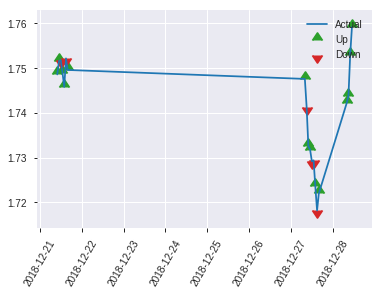


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23146152530588857
RMSE: 0.48110448481165563
LogLoss: 0.760325881491867
Mean Per-Class Error: 0.33521923620933525
AUC: 0.7195274149263665
pr_auc: 0.6608165743171845
Gini: 0.43905482985273303
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15707334875757742: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   68   0.5714   (68.0/119.0)
1      10   91   0.099    (10.0/101.0)
Total  61   159  0.3545   (78.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.157073     0.7       158
max f2                       0.0313999    0.81803   194
max f0point5                 0.592547     0.640177  87
max accuracy                 0.592547     0.668182  87
max precision                0.985312     1         0
max recall                   9.39635e-09  1         219
max specificity              0.985312     1         0
max absolute_mcc             0.157073     0.366866  158
max min_per_class_accuracy   0.422212     0.655462  107
max mean_per_class_accuracy  0.157073     0.664781  158

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 44.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0136364                   0.977672           1.45215   1.45215            0.666667         0.981724   0.666667                    0.981724            0.019802        0.019802                   45.2145    45.2145
    2        0.0227273                   0.954771           2.17822   1.74257            1                0.96668    0.8                         0.975707            0.019802        0.039604                   117.822    74.2574
    3        0.0318182                   0.952165           2.17822   1.86704            1                0.952856   0.857143                    0.969178            0.019802        0.0594059                  117.822    86.7044
    4        0.0409091                   0.939324           1.08911   1.69417            0.5              0.946384   0.777778                    0.964112            0.00990099      0.0693069                  8.91089    69.4169
    5        0.05                        0.924326           2.17822   1.78218            1                0.936351   0.818182                    0.959065            0.019802        0.0891089                  117.822    78.2178
    6        0.1                         0.873684           1.78218   1.78218            0.818182         0.90514    0.818182                    0.932102            0.0891089       0.178218                   78.2178    78.2178
    7        0.15                        0.821123           1.18812   1.58416            0.545455         0.850893   0.727273                    0.905033            0.0594059       0.237624                   18.8119    58.4158
    8        0.2                         0.78608            1.78218   1.63366            0.818182         0.804799   0.75                        0.879974            0.0891089       0.326733                   78.2178    63.3663
    9        0.3                         0.68713            0.990099  1.41914            0.454545         0.736211   0.651515                    0.832053            0.0990099       0.425743                   -0.990099  41.9142
    10       0.4                         0.591532           1.48515   1.43564            0.681818         0.638429   0.659091                    0.783647            0.148515        0.574257                   48.5149    43.5644
    11       0.5                         0.415803           0.990099  1.34653            0.454545         0.508737   0.618182                    0.728665            0.0990099       0.673267                   -0.990099  34.6535
    12       0.6                         0.280751           0.792079  1.25413            0.363636         0.351438   0.575758                    0.665794            0.0792079       0.752475                   -20.7921   25.4125
    13       0.7                         0.190965           1.18812   1.2447             0.545455         0.23144    0.571429                    0.603743            0.118812        0.871287                   18.8119    24.4696
    14       0.8                         0.0963115          0.594059  1.16337            0.272727         0.137693   0.534091                    0.545487            0.0594059       0.930693                   -40.5941   16.3366
    15       0.9                         0.0201071          0.39604   1.07811            0.181818         0.0564772  0.494949                    0.491153            0.039604        0.970297                   -60.396    7.81078
    16       1                           9.39635e-09        0.29703   1                  0.136364         0.007947   0.459091  

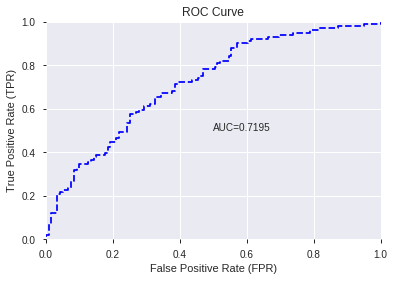

This function is available for GLM models only


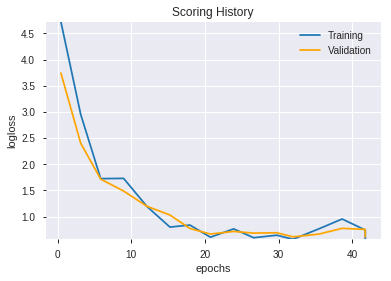

--2019-08-28 13:00:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.81.160
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.81.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  13.4MB/s    in 28s     

2019-08-28 13:01:12 (12.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_123229_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_123229_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_130126  0.724353  0.650531              0.286879  0.467682  0.218726
1  DeepLearning_grid_1_AutoML_20190828_130126_model_8  0.721441  0.635112              0.302937  0.465191  0.216403
2  DeepLearning_grid_1_AutoML_20190828_130126_model_5  0.717031  0.651873              0.303686  0.468672  0.219654
3  DeepLearning_grid_1_AutoML_20190828_130126_model_6  0.713953  0.625215              0.380689  0.466072  0.217223
4  DeepLearning_grid_1_AutoML_20190828_130126_model_9  0.712954  0.641355              0.333555  0.470877  0.221725
5  DeepLearning_grid_1_AutoML_20190828_130126_model_7  0.698311  0.701409              0.382935  0.478213  0.228687
6  DeepLearning_grid_1_AutoML_20190828_130126_model_3  0.697063  0.805579              0.382187  0.487205  0.237368
7  DeepLearning_grid_1_AutoML_20190828_130126_model_2  0.692154  0.982468              0.381438  0.494414  0.244445
8  DeepLearning_grid_1_AutoML_20190828_130126_model_4  0.686164  1.012699              0.354106  0.499457  0.249458
9  DeepLearning_grid_1_AutoML_20190828_130126_model_1  0.681837  1.352089              0.364465  0.528639  0.279459

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.032221
1      CDLDRAGONFLYDOJI             0.888798           0.888798    0.028638
2     CDLSTALLEDPATTERN             0.843707           0.843707    0.027185
3             CDLONNECK             0.827916           0.827916    0.026676
4                   SUB             0.814433           0.814433    0.026242
5             CDLHAMMER             0.775041           0.775041    0.024972
6   CDLXSIDEGAP3METHODS             0.750980           0.750980    0.024197
7          STOCHF_fastk             0.744513           0.744513    0.023989
8         days_in_month             0.743146           0.743146    0.023945
9        CDLMATCHINGLOW             0.718959           0.718959    0.023165
10         CDLTASUKIGAP             0.699152           0.699152    0.022527
11                FLOOR             0.685543           0.685543    0.022089
12       CDL3LINESTRIKE             0.681860           0.681860    0.021970
13          CDLMARUBOZU             0.677177           0.677177    0.021819
14       STOCHRSI_fastk             0.671070           0.671070    0.021622
15                 CEIL             0.663880           0.663880    0.021391
16        CDLHANGINGMAN             0.662513           0.662513    0.021347
17   CDLIDENTICAL3CROWS             0.651247           0.651247    0.020984
18      CDLADVANCEBLOCK             0.647575           0.647575    0.020865
19    CDLDARKCLOUDCOVER             0.645276           0.645276    0.020791
20                  DIV             0.641901           0.641901    0.020683
21           CDL3INSIDE             0.641493           0.641493    0.020669
22    CDLGRAVESTONEDOJI             0.622013           0.622013    0.020042
23       CDLEVENINGSTAR             0.619621           0.619621    0.019965
24   CDLMORNINGDOJISTAR             0.616451           0.616451    0.019863
25      CDLSHOOTINGSTAR             0.605848           0.605848    0.019521
26      CDLHOMINGPIGEON             0.588043           0.588043    0.018947
27          HT_DCPERIOD             0.587209           0.587209    0.018920
28        CDLHIKKAKEMOD             0.581368           0.581368    0.018732
29         is_month_end             0.573767           0.573767    0.018487
30    CDL3WHITESOLDIERS             0.569173           0.569173    0.018339
31   CDLEVENINGDOJISTAR             0.568942           0.568942    0.018332
32    CDLINVERTEDHAMMER             0.557868           0.557868    0.017975
33       is_month_start             0.556696           0.556696    0.017937
34  CDLRISEFALL3METHODS             0.554123           0.554123    0.017854
35          CDLPIERCING             0.552426           0.552426    0.017800
36   CDLCLOSINGMARUBOZU             0.550612           0.550612    0.017741
37      CDLLADDERBOTTOM             0.549017           0.549017    0.017690
38         CDLENGULFING             0.536436           0.536436    0.017284
39            CDLTAKURI             0.520139           0.520139    0.016759
40               TRANGE             0.515722           0.515722    0.016617
41            CDLINNECK             0.512455           0.512455    0.016512
42       CDLMORNINGSTAR             0.504118           0.504118    0.016243
43          CDLLONGLINE             0.474048           0.474048    0.015274
44                 hour             0.472850           0.472850    0.015236
45         CDLTHRUSTING             0.468178           0.468178    0.015085
46         HT_TRENDMODE             0.451527           0.451527    0.014549
47                  day             0.446182           0.446182    0.014376
48  CDLGAPSIDESIDEWHITE             0.420458           0.420458    0.013548
49       CDLHARAMICROSS             0.384381           0.384381    0.012385

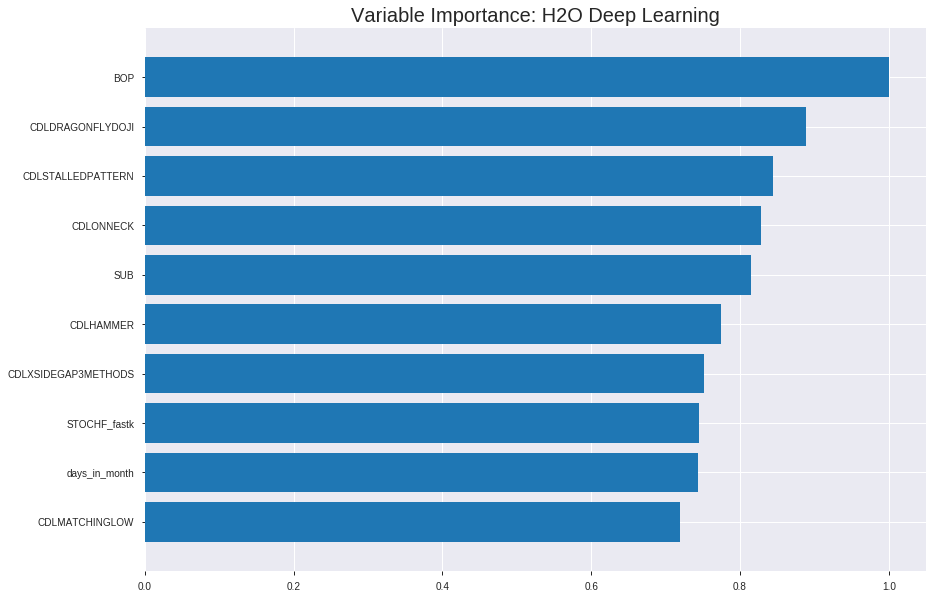

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_130126


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18227990167084498
RMSE: 0.42694250394033734
LogLoss: 0.5421775832007215
Mean Per-Class Error: 0.26796048168249653
AUC: 0.8000457937584804
pr_auc: 0.7582171513186716
Gini: 0.6000915875169608
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40902182597868864: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      461  339  0.4238   (339.0/800.0)
1      96   641  0.1303   (96.0/737.0)
Total  557  980  0.283    (435.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409022     0.746651  245
max f2                       0.226054     0.853081  319
max f0point5                 0.549095     0.715673  182
max accuracy                 0.487914     0.729993  209
max precision                0.999292     1         0
max recall                   0.0200293    1         394
max specificity              0.999292     1         0
max absolute_mcc             0.47414      0.466654  215
max min_per_class_accuracy   0.52293      0.72375   193
max mean_per_class_accuracy  0.47414      0.73204   215

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 49.60 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.964959           1.8248     1.8248             0.875            0.981427  0.875                       0.981427            0.0189959       0.0189959                  82.4796   82.4796
    2        0.0201692                   0.919438           1.94645    1.88366            0.933333         0.93771   0.903226                    0.960273            0.0189959       0.0379919                  94.645    88.3661
    3        0.0305791                   0.900525           1.69445    1.81925            0.8125           0.909722  0.87234                     0.943065            0.0176391       0.0556309                  69.4454   81.925
    4        0.0403383                   0.887637           1.94645    1.85002            0.933333         0.894738  0.887097                    0.931373            0.0189959       0.0746269                  94.645    85.0024
    5        0.0500976                   0.871321           1.80742    1.84172            0.866667         0.879329  0.883117                    0.921234            0.0176391       0.0922659                  80.7417   84.1724
    6        0.100195                    0.810707           1.76047    1.8011             0.844156         0.838437  0.863636                    0.879836            0.0881954       0.180461                   76.0472   80.1098
    7        0.150293                    0.765211           1.59797    1.73339            0.766234         0.786419  0.831169                    0.848697            0.0800543       0.260516                   59.7966   73.3387
    8        0.20039                     0.730496           1.65213    1.71307            0.792208         0.748185  0.821429                    0.823569            0.082768        0.343284                   65.2135   71.3074
    9        0.299935                    0.654752           1.40395    1.61048            0.673203         0.692347  0.772234                    0.780018            0.139756        0.483039                   40.3952   61.048
    10       0.40013                     0.591699           1.23233    1.51579            0.590909         0.623991  0.726829                    0.740948            0.123474        0.606513                   23.233    51.5789
    11       0.500325                    0.51154            1.25941    1.46445            0.603896         0.556973  0.702211                    0.704105            0.126187        0.7327                     25.9414   46.4447
    12       0.59987                     0.437017           1.03593    1.39334            0.496732         0.476737  0.668113                    0.666375            0.103121        0.835821                   3.59255   39.3337
    13       0.700065                    0.352828           0.744815   1.30052            0.357143         0.395634  0.623606                    0.627626            0.0746269       0.910448                   -25.5185  30.0519
    14       0.79961                     0.256916           0.517963   1.2031             0.248366         0.305243  0.576892                    0.587492            0.0515604       0.962008                   -48.2037  20.3097
    15       0.899805                    0.136106           0.284384   1.1008             0.136364         0.1952    0.527838                    0.543809            0.0284939       0.990502                   -71.5616  10.0797
    16       1                           0.00116674         0.0947946  1                  0.0454545        0.066443  0.479506                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20033624858367446
RMSE: 0.4475893749673628
LogLoss: 0.6114659301501402
Mean Per-Class Error: 0.2756219522274568
AUC: 0.759194974791305
pr_auc: 0.6859281002366331
Gini: 0.5183899495826101
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3549324472936559: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  100  0.4587   (100.0/218.0)
1      27   195  0.1216   (27.0/222.0)
Total  145  295  0.2886   (127.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.354932     0.754352  264
max f2                       0.176448     0.861795  332
max f0point5                 0.470832     0.717781  226
max accuracy                 0.470832     0.725     226
max precision                0.734651     0.776596  88
max recall                   0.0417703    1         385
max specificity              0.993295     0.995413  0
max absolute_mcc             0.470832     0.45326   226
max min_per_class_accuracy   0.535466     0.689189  198
max mean_per_class_accuracy  0.470832     0.724378  226

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 49.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.980761           0         0                  0                0.989413   0                           0.989413            0               0                          -100      -100
    2        0.0204545                   0.938985           1.98198   0.880881           1                0.957944   0.444444                    0.975427            0.018018        0.018018                   98.1982   -11.9119
    3        0.0318182                   0.911797           1.18919   0.990991           0.6              0.921248   0.5                         0.956077            0.0135135       0.0315315                  18.9189   -0.900901
    4        0.0409091                   0.901519           1.48649   1.1011             0.75             0.905398   0.555556                    0.944815            0.0135135       0.045045                   48.6486   10.1101
    5        0.05                        0.891748           1.98198   1.26126            1                0.89486    0.636364                    0.935732            0.018018        0.0630631                  98.1982   26.1261
    6        0.1                         0.834923           1.53153   1.3964             0.772727         0.861174   0.704545                    0.898453            0.0765766       0.13964                    53.1532   39.6396
    7        0.15                        0.789153           1.53153   1.44144            0.772727         0.809406   0.727273                    0.868771            0.0765766       0.216216                   53.1532   44.1441
    8        0.2                         0.741676           1.71171   1.50901            0.863636         0.76912    0.761364                    0.843858            0.0855856       0.301802                   71.1712   50.9009
    9        0.3                         0.681557           1.3964    1.47147            0.704545         0.714808   0.742424                    0.800841            0.13964         0.441441                   39.6396   47.1471
    10       0.4                         0.612719           1.35135   1.44144            0.681818         0.64598    0.727273                    0.762126            0.135135        0.576577                   35.1351   44.1441
    11       0.5                         0.532041           1.12613   1.37838            0.568182         0.578048   0.695455                    0.72531             0.112613        0.689189                   12.6126   37.8378
    12       0.6                         0.442439           1.21622   1.35135            0.613636         0.488726   0.681818                    0.68588             0.121622        0.810811                   21.6216   35.1351
    13       0.7                         0.334262           0.810811  1.27413            0.409091         0.389803   0.642857                    0.643583            0.0810811       0.891892                   -18.9189  27.4131
    14       0.8                         0.217677           0.540541  1.18243            0.272727         0.270327   0.596591                    0.596926            0.0540541       0.945946                   -45.9459  18.2432
    15       0.9                         0.110656           0.36036   1.09109            0.181818         0.16314    0.550505                    0.548727            0.036036        0.981982                   -63.964   9.10911
    16       1                           0.00860058         0.18018   1                  0.0909091        0.0569182  0.504545                   


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:01:26  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:01:26  0.123 sec   53000 obs/sec     1         1             1537       0.472455         0.690276            0.105643       0.722236        0.660197           1.30343          0.384515                         0.481681           0.751473              0.0718552        0.718293          0.65304              1.18919            0.306818
    2019-08-28 13:01:27  0.405 sec   54503 obs/sec     10        10            15370      0.426943         0.542178            0.269653       0.800046        0.758217           1.8248           0.283019                         0.447589           0.611466              0.198589         0.759195          0.685928             0                  0.288636

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
BOP                  1.0                    1.0                  0.03222080201721402
CDLDRAGONFLYDOJI     0.8887978196144104     0.8887978196144104   0.028637778579127422
CDLSTALLEDPATTERN    0.8437074422836304     0.8437074422836304   0.027184930458270883
CDLONNECK            0.8279159665107727     0.8279159665107727   0.026676116443834004
SUB                  0.8144334554672241     0.8144334554672241   0.026241699124804924
---                  ---                    ---                  ---
CDLTHRUSTING         0.4681779742240906     0.4681779742240906   0.015085069816294754
HT_TRENDMODE         0.45152732729911804    0.45152732729911804  0.01454857261826668
day                  0.4461820721626282     0.4461820721626282   0.014376344210782342
CDLGAPSIDESIDEWHITE  0.42045822739601135    0.42045822739601135  0.013547501301435635
CDLHARAMICROSS       0.38438060879707336    0.38438060879707336  0.012385051495306696


See the whole table with table.as_data_frame()


('accuracy', 0.7090909090909091)

('F1', 0.7064220183486238)

('auc', 0.7243531075796655)

('logloss', 0.6505313866988277)

('mean_per_class_error', 0.28687910807887507)

('rmse', 0.46768170335131604)

('mse', 0.21872617564958838)

deeplearning prediction progress: |███████████████████████████████████████| 100%


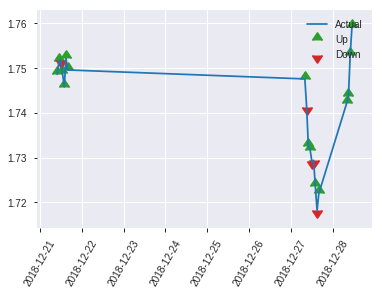


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21872617564958838
RMSE: 0.46768170335131604
LogLoss: 0.6505313866988277
Mean Per-Class Error: 0.28687910807887507
AUC: 0.7243531075796655
pr_auc: 0.6352467637037004
Gini: 0.44870621515933107
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48724591598109956: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      79   40   0.3361   (40.0/119.0)
1      24   77   0.2376   (24.0/101.0)
Total  103  117  0.2909   (64.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487246     0.706422  116
max f2                       0.0448619    0.819805  211
max f0point5                 0.552285     0.680412  95
max accuracy                 0.487246     0.709091  116
max precision                0.996049     1         0
max recall                   0.0448619    1         211
max specificity              0.996049     1         0
max absolute_mcc             0.487246     0.425675  116
max min_per_class_accuracy   0.507924     0.689076  106
max mean_per_class_accuracy  0.487246     0.713121  116

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 48.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.984909           1.45215   1.45215            0.666667         0.991211   0.666667                    0.991211            0.019802        0.019802                   45.2145   45.2145
    2        0.0227273                   0.942717           2.17822   1.74257            1                0.962476   0.8                         0.979717            0.019802        0.039604                   117.822   74.2574
    3        0.0318182                   0.904726           1.08911   1.55587            0.5              0.922637   0.714286                    0.963408            0.00990099      0.049505                   8.91089   55.587
    4        0.0409091                   0.892523           1.08911   1.45215            0.5              0.898342   0.666667                    0.948949            0.00990099      0.0594059                  8.91089   45.2145
    5        0.05                        0.886375           0         1.18812            0                0.891527   0.545455                    0.938509            0               0.0594059                  -100      18.8119
    6        0.1                         0.825903           1.38614   1.28713            0.636364         0.852758   0.590909                    0.895634            0.0693069       0.128713                   38.6139   28.7129
    7        0.15                        0.758687           1.78218   1.45215            0.818182         0.795321   0.666667                    0.862196            0.0891089       0.217822                   78.2178   45.2145
    8        0.2                         0.703971           1.58416   1.48515            0.727273         0.720723   0.681818                    0.826828            0.0792079       0.29703                    58.4158   48.5149
    9        0.3                         0.632349           1.58416   1.51815            0.727273         0.669427   0.69697                     0.774361            0.158416        0.455446                   58.4158   51.8152
    10       0.4                         0.577563           1.28713   1.4604             0.590909         0.606587   0.670455                    0.732417            0.128713        0.584158                   28.7129   46.0396
    11       0.5                         0.500175           1.38614   1.44554            0.636364         0.539079   0.663636                    0.69375             0.138614        0.722772                   38.6139   44.5545
    12       0.6                         0.430378           0.693069  1.32013            0.318182         0.470436   0.606061                    0.656531            0.0693069       0.792079                   -30.6931  32.0132
    13       0.7                         0.331173           0.594059  1.21641            0.272727         0.384624   0.558442                    0.617687            0.0594059       0.851485                   -40.5941  21.6407
    14       0.8                         0.202076           0.49505   1.12624            0.227273         0.267276   0.517045                    0.573886            0.049505        0.90099                    -50.495   12.6238
    15       0.9                         0.113494           0.594059  1.06711            0.272727         0.155796   0.489899                    0.527431            0.0594059       0.960396                   -40.5941  6.71067
    16       1                           0.0111765          0.39604   1                  0.181818         0.0633413  0.459091                    

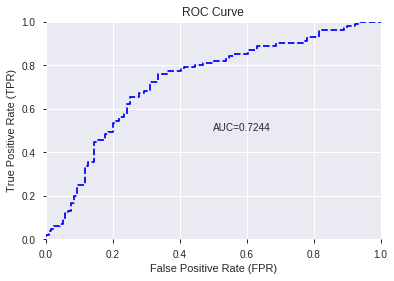

This function is available for GLM models only


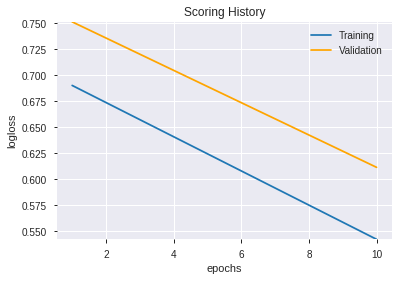

--2019-08-28 13:08:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_130126',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_130126',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_10_sid_b106'

['BOP',
 'CDLDRAGONFLYDOJI',
 'CDLSTALLEDPATTERN',
 'CDLONNECK',
 'SUB',
 'CDLHAMMER',
 'CDLXSIDEGAP3METHODS',
 'STOCHF_fastk',
 'days_in_month',
 'CDLMATCHINGLOW',
 'CDLTASUKIGAP',
 'FLOOR',
 'CDL3LINESTRIKE',
 'CDLMARUBOZU',
 'STOCHRSI_fastk',
 'CEIL',
 'CDLHANGINGMAN',
 'CDLIDENTICAL3CROWS',
 'CDLADVANCEBLOCK',
 'CDLDARKCLOUDCOVER',
 'DIV',
 'CDL3INSIDE',
 'CDLGRAVESTONEDOJI',
 'CDLEVENINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLSHOOTINGSTAR',
 'CDLHOMINGPIGEON',
 'HT_DCPERIOD',
 'CDLHIKKAKEMOD',
 'is_month_end',
 'CDL3WHITESOLDIERS',
 'CDLEVENINGDOJISTAR',
 'CDLINVERTEDHAMMER',
 'is_month_start',
 'CDLRISEFALL3METHODS',
 'CDLPIERCING',
 'CDLCLOSINGMARUBOZU',
 'CDLLADDERBOTTOM',
 'CDLENGULFING',
 'CDLTAKURI',
 'TRANGE',
 'CDLINNECK',
 'CDLMORNINGSTAR',
 'CDLLONGLINE',
 'hour',
 'CDLTHRUSTING',
 'HT_TRENDMODE',
 'day',
 'CDLGAPSIDESIDEWHITE',
 'CDLHARAMICROSS']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_130904_model_1  0.705383  0.647174              0.335053  0.471329  0.222151

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.509056           1.000000    0.154341
1    CDLCLOSINGMARUBOZU             0.252502           0.496020    0.076556
2             CDLHAMMER             0.176169           0.346070    0.053413
3                   SUB             0.164105           0.322371    0.049755
4                  hour             0.135919           0.267002    0.041209
5                   DIV             0.133221           0.261703    0.040391
6          STOCHF_fastk             0.123607           0.242816    0.037477
7     CDLGRAVESTONEDOJI             0.096785           0.190127    0.029344
8          CDLENGULFING             0.088610           0.174067    0.026866
9          CDLTHRUSTING             0.083830           0.164678    0.025417
10           CDL3INSIDE             0.079808           0.156776    0.024197
11       CDLHARAMICROSS             0.076876           0.151017    0.023308
12    CDLDARKCLOUDCOVER             0.072505           0.142431    0.021983
13        CDLHANGINGMAN             0.071400           0.140261    0.021648
14    CDLSTALLEDPATTERN             0.068884           0.135317    0.020885
15   CDLIDENTICAL3CROWS             0.064230           0.126176    0.019474
16       STOCHRSI_fastk             0.063047           0.123850    0.019115
17       CDL3LINESTRIKE             0.060114           0.118088    0.018226
18       CDLEVENINGSTAR             0.057344           0.112647    0.017386
19      CDLLADDERBOTTOM             0.055315           0.108662    0.016771
20        days_in_month             0.055012           0.108068    0.016679
21          CDLPIERCING             0.049319           0.096882    0.014953
22          CDLLONGLINE             0.047989           0.094270    0.014550
23      CDLADVANCEBLOCK             0.046370           0.091090    0.014059
24       is_month_start             0.045458           0.089298    0.013782
25   CDLMORNINGDOJISTAR             0.044146           0.086721    0.013385
26     CDLDRAGONFLYDOJI             0.041115           0.080767    0.012466
27        CDLHIKKAKEMOD             0.040861           0.080268    0.012389
28               TRANGE             0.040330           0.079225    0.012228
29  CDLGAPSIDESIDEWHITE             0.039749           0.078083    0.012051
30                  day             0.039689           0.077966    0.012033
31         is_month_end             0.038461           0.075553    0.011661
32            CDLTAKURI             0.034972           0.068701    0.010603
33  CDLRISEFALL3METHODS             0.033188           0.065196    0.010062
34            CDLINNECK             0.031853           0.062573    0.009658
35            CDLONNECK             0.031798           0.062464    0.009641
36    CDL3WHITESOLDIERS             0.030999           0.060896    0.009399
37   CDLEVENINGDOJISTAR             0.028417           0.055822    0.008616
38       CDLMATCHINGLOW             0.026439           0.051938    0.008016
39       CDLMORNINGSTAR             0.020062           0.039411    0.006083
40  CDLXSIDEGAP3METHODS             0.018423           0.036190    0.005586
41          CDLMARUBOZU             0.016637           0.032682    0.005044
42    CDLINVERTEDHAMMER             0.014605           0.028690    0.004428
43      CDLSHOOTINGSTAR             0.011053           0.021713    0.003351
44         CDLTASUKIGAP             0.010389           0.020409    0.003150
45      CDLHOMINGPIGEON             0.010112           0.019863    0.003066
46         HT_TRENDMODE             0.009773           0.019197    0.002963
47                 CEIL             0.002714           0.005332    0.000823
48                FLOOR             0.002678           0.005261    0.000812
49          HT_DCPERIOD             0.002316           0.004550    0.000702

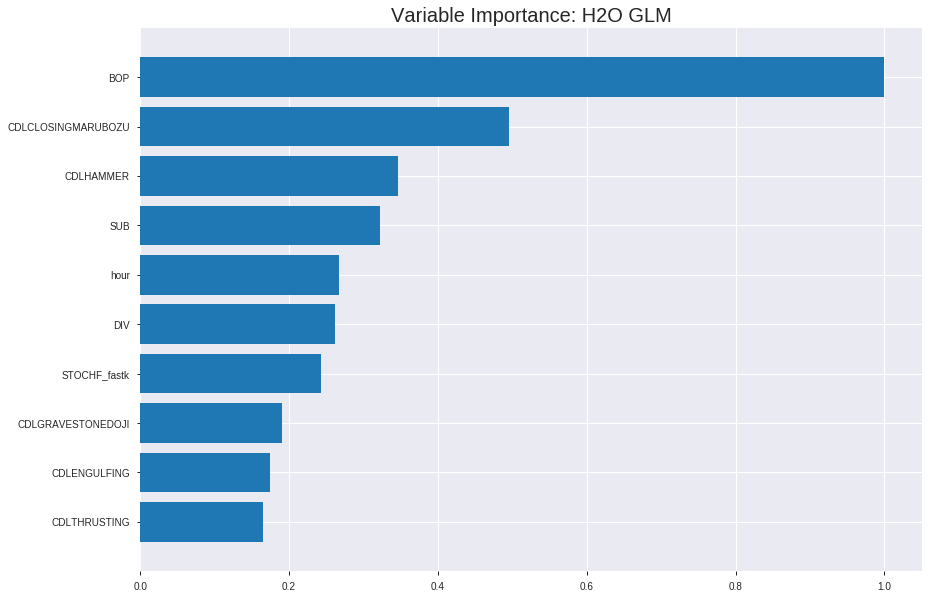

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_130904_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18856591080828716
RMSE: 0.4342417653891518
LogLoss: 0.556221631753524
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2128.1514062818787
Residual deviance: 1709.8252960103327
AIC: 1811.8252960103327
AUC: 0.7890323948439619
pr_auc: 0.751654886795708
Gini: 0.5780647896879239
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39045072892424676: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      426  374   0.4675   (374.0/800.0)
1      97   640   0.1316   (97.0/737.0)
Total  523  1014  0.3064   (471.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390451     0.731011  251
max f2                       0.257382     0.85026   314
max f0point5                 0.536848     0.715777  173
max accuracy                 0.529541     0.720234  177
max precision                0.948636     1         0
max recall                   0.0991955    1         376
max specificity              0.948636     1         0
max absolute_mcc             0.529541     0.43911   177
max min_per_class_accuracy   0.498664     0.708277  195
max mean_per_class_accuracy  0.529541     0.718107  177

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 47.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104099                   0.897644           1.95514   1.95514            0.9375           0.915223  0.9375                      0.915223            0.0203528       0.0203528                  95.5139    95.5139
    2        0.0201692                   0.874731           1.52935   1.74911            0.733333         0.886149  0.83871                     0.901155            0.0149254       0.0352782                  52.9353    74.9114
    3        0.0305791                   0.862379           1.8248    1.77488            0.875            0.867474  0.851064                    0.889689            0.0189959       0.0542741                  82.4796    77.4878
    4        0.0403383                   0.853555           1.80742   1.78275            0.866667         0.857409  0.854839                    0.881879            0.0176391       0.0719132                  80.7417    78.275
    5        0.0500976                   0.831523           1.80742   1.78756            0.866667         0.845172  0.857143                    0.874729            0.0176391       0.0895522                  80.7417    78.7556
    6        0.100195                    0.750428           1.81464   1.8011             0.87013          0.789146  0.863636                    0.831937            0.0909091       0.180461                   81.464     80.1098
    7        0.150293                    0.70539            1.65213   1.75144            0.792208         0.726806  0.839827                    0.796894            0.082768        0.263229                   65.2135    75.1443
    8        0.20039                     0.669607           1.46255   1.67922            0.701299         0.687896  0.805195                    0.769644            0.07327         0.336499                   46.2546    67.9219
    9        0.299935                    0.611656           1.44484   1.60143            0.69281          0.638998  0.767896                    0.726284            0.143826        0.480326                   44.4844    60.1433
    10       0.40013                     0.552296           1.36775   1.54292            0.655844         0.581093  0.739837                    0.689928            0.137042        0.617368                   36.7751    54.2917
    11       0.500325                    0.491647           1.01566   1.43733            0.487013         0.521274  0.689207                    0.656153            0.101764        0.719132                   1.56567    43.7328
    12       0.59987                     0.419928           0.995034  1.36393            0.477124         0.453914  0.654013                    0.622593            0.0990502       0.818182                   -0.496626  36.3932
    13       0.700065                    0.358542           0.785441  1.28114            0.376623         0.392375  0.614312                    0.589643            0.0786974       0.896879                   -21.4559   28.1137
    14       0.79961                     0.286359           0.599746  1.19631            0.287582         0.322441  0.573637                    0.556379            0.0597015       0.956581                   -40.0254   19.631
    15       0.899805                    0.174679           0.311468  1.09778            0.149351         0.237055  0.526392                    0.520822            0.0312076       0.987788                   -68.8532   9.77807
    16       1                           0.0200866          0.121879  1                  0.0584416        0.108467  0.479506                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19648900758294457
RMSE: 0.44327080614782716
LogLoss: 0.5781043654270921
Null degrees of freedom: 439
Residual degrees of freedom: 389
Null deviance: 611.0374769186825
Residual deviance: 508.73184157584103
AIC: 610.731841575841
AUC: 0.7680593437474171
pr_auc: 0.7130422051518472
Gini: 0.5361186874948343
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4572664947329277: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      144  74   0.3394   (74.0/218.0)
1      41   181  0.1847   (41.0/222.0)
Total  185  255  0.2614   (115.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457266     0.75891   229
max f2                       0.226489     0.853755  340
max f0point5                 0.457266     0.728663  229
max accuracy                 0.457266     0.738636  229
max precision                0.927655     1         0
max recall                   0.0995645    1         383
max specificity              0.927655     1         0
max absolute_mcc             0.457266     0.481985  229
max min_per_class_accuracy   0.50876      0.706422  201
max mean_per_class_accuracy  0.457266     0.737933  229

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 48.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.891291           1.18919   1.18919            0.6              0.907273  0.6                         0.907273            0.0135135       0.0135135                  18.9189   18.9189
    2        0.0204545                   0.876391           1.48649   1.32132            0.75             0.880069  0.666667                    0.895182            0.0135135       0.027027                   48.6486   32.1321
    3        0.0318182                   0.856398           1.98198   1.55727            1                0.869829  0.785714                    0.886127            0.0225225       0.0495495                  98.1982   55.7272
    4        0.0409091                   0.84365            1.48649   1.54154            0.75             0.85257   0.777778                    0.87867             0.0135135       0.0630631                  48.6486   54.1542
    5        0.05                        0.833474           1.98198   1.62162            1                0.838959  0.818182                    0.87145             0.018018        0.0810811                  98.1982   62.1622
    6        0.1                         0.765012           1.44144   1.53153            0.727273         0.798643  0.772727                    0.835046            0.0720721       0.153153                   44.1441   53.1532
    7        0.15                        0.723279           1.35135   1.47147            0.681818         0.743689  0.742424                    0.804594            0.0675676       0.220721                   35.1351   47.1471
    8        0.2                         0.683735           1.53153   1.48649            0.772727         0.701019  0.75                        0.7787              0.0765766       0.297297                   53.1532   48.6486
    9        0.3                         0.612819           1.53153   1.5015             0.772727         0.643299  0.757576                    0.733566            0.153153        0.45045                    53.1532   50.1502
    10       0.4                         0.569767           1.26126   1.44144            0.636364         0.591543  0.727273                    0.69806             0.126126        0.576577                   26.1261   44.1441
    11       0.5                         0.50876            1.26126   1.40541            0.636364         0.543853  0.709091                    0.667219            0.126126        0.702703                   26.1261   40.5405
    12       0.6                         0.446616           1.21622   1.37387            0.613636         0.475104  0.693182                    0.6352              0.121622        0.824324                   21.6216   37.3874
    13       0.7                         0.363398           0.720721  1.28057            0.363636         0.401409  0.646104                    0.601801            0.0720721       0.896396                   -27.9279  28.0566
    14       0.8                         0.268832           0.45045   1.1768             0.227273         0.316744  0.59375                     0.566169            0.045045        0.941441                   -54.955   17.6802
    15       0.9                         0.170143           0.36036   1.08609            0.181818         0.227122  0.54798                     0.528497            0.036036        0.977477                   -63.964   8.60861
    16       1                           0.04101            0.225225  1                  0.113636         0.105909  0.504545                    0.486238         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 13:09:04  0.000 sec   2            21        51            1.36914           1.37265
    2019-08-28 13:09:04  0.025 sec   4            13        51            1.36056           1.36376
    2019-08-28 13:09:04  0.046 sec   6            8.2       51            1.34793           1.35074
    2019-08-28 13:09:04  0.063 sec   8            5.1       51            1.33014           1.33251
    2019-08-28 13:09:04  0.089 sec   10           3.1       51            1.30668           1.30873
    2019-08-28 13:09:04  0.109 sec   12           2         51            1.27817           1.28036
    2019-08-28 13:09:04  0.126 sec   14           1.2       51            1.24668           1.24997
    2019-08-28 13:09:04  0.144 sec   16           0.75      51            1.21509           1.22093
    2019-08-28 13:09:04  0.162 sec   18           0.47      51            1.18602           1.19621
    2019-08-28 13:09:04  0.181 sec   20           0.29      51            1.16108           1.17746
    2019-08-28 13:09:04  0.198 sec   22           0.18      51            1.14074           1.16498
    2019-08-28 13:09:04  0.216 sec   24           0.11      51            1.12471           1.15819
    2019-08-28 13:09:04  0.236 sec   26           0.07      51            1.11244           1.15621
    2019-08-28 13:09:04  0.253 sec   28           0.043     51            1.10339           1.15825
    2019-08-28 13:09:04  0.271 sec   30           0.027     51            1.09707           1.16356
    2019-08-28 13:09:04  0.288 sec   32           0.017     51            1.09293           1.17141
    2019-08-28 13:09:04  0.304 sec   34           0.01      51            1.09035           1.18101
    2019-08-28 13:09:04  0.325 sec   36           0.0064    51            1.08871           1.19165

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6818181818181818)

('F1', 0.6779661016949152)

('auc', 0.7053831433563524)

('logloss', 0.6471738156599806)

('mean_per_class_error', 0.32107496463932106)

('rmse', 0.47132908231796)

('mse', 0.22215110383869033)

glm prediction progress: |████████████████████████████████████████████████| 100%


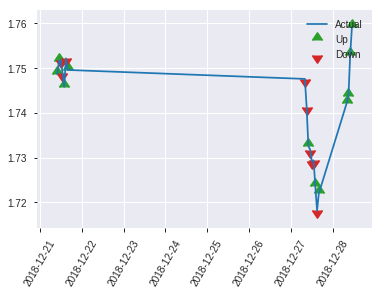


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22215110383869033
RMSE: 0.47132908231796
LogLoss: 0.6471738156599806
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 303.8782617497692
Residual deviance: 284.75647889039146
AIC: 386.75647889039146
AUC: 0.7053831433563524
pr_auc: 0.6194147174168805
Gini: 0.4107662867127049
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39898735946653874: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   55   0.4622   (55.0/119.0)
1      21   80   0.2079   (21.0/101.0)
Total  85   135  0.3455   (76.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398987     0.677966  134
max f2                       0.0968756    0.813008  210
max f0point5                 0.528388     0.655914  90
max accuracy                 0.528388     0.681818  90
max precision                0.935394     1         0
max recall                   0.0142595    1         219
max specificity              0.935394     1         0
max absolute_mcc             0.508249     0.358447  98
max min_per_class_accuracy   0.49018      0.672269  106
max mean_per_class_accuracy  0.508249     0.678925  98

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 45.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.865822           1.45215   1.45215            0.666667         0.909669   0.666667                    0.909669            0.019802        0.019802                   45.2145   45.2145
    2        0.0227273                   0.845              0         0.871287           0                0.85425    0.4                         0.887501            0               0.019802                   -100      -12.8713
    3        0.0318182                   0.822518           2.17822   1.2447             1                0.837719   0.571429                    0.873278            0.019802        0.039604                   117.822   24.4696
    4        0.0409091                   0.810615           2.17822   1.45215            1                0.811504   0.666667                    0.85955             0.019802        0.0594059                  117.822   45.2145
    5        0.05                        0.809505           1.08911   1.38614            0.5              0.810273   0.636364                    0.850591            0.00990099      0.0693069                  8.91089   38.6139
    6        0.1                         0.726131           1.38614   1.38614            0.636364         0.776062   0.636364                    0.813326            0.0693069       0.138614                   38.6139   38.6139
    7        0.15                        0.668647           1.58416   1.45215            0.727273         0.703864   0.666667                    0.776839            0.0792079       0.217822                   58.4158   45.2145
    8        0.2                         0.630704           1.58416   1.48515            0.727273         0.648115   0.681818                    0.744658            0.0792079       0.29703                    58.4158   48.5149
    9        0.3                         0.5805             1.58416   1.51815            0.727273         0.606543   0.69697                     0.69862             0.158416        0.455446                   58.4158   51.8152
    10       0.4                         0.529667           1.18812   1.43564            0.545455         0.559068   0.659091                    0.663732            0.118812        0.574257                   18.8119   43.5644
    11       0.5                         0.481114           1.08911   1.36634            0.5              0.507892   0.627273                    0.632564            0.108911        0.683168                   8.91089   36.6337
    12       0.6                         0.405725           0.792079  1.27063            0.363636         0.438784   0.583333                    0.600267            0.0792079       0.762376                   -20.7921  27.0627
    13       0.7                         0.344107           0.594059  1.17397            0.272727         0.37586    0.538961                    0.568209            0.0594059       0.821782                   -40.5941  17.3975
    14       0.8                         0.253583           0.891089  1.13861            0.409091         0.296547   0.522727                    0.534251            0.0891089       0.910891                   -10.8911  13.8614
    15       0.9                         0.147055           0.39604   1.05611            0.181818         0.209026   0.484848                    0.498115            0.039604        0.950495                   -60.396   5.61056
    16       1                           0.0142595          0.49505   1                  0.227273         0.0980445  0.459091                  

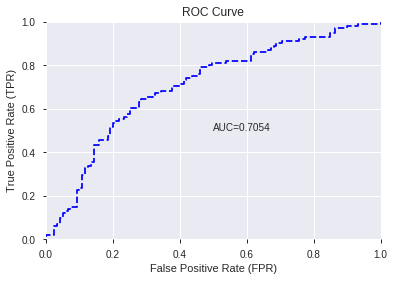

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


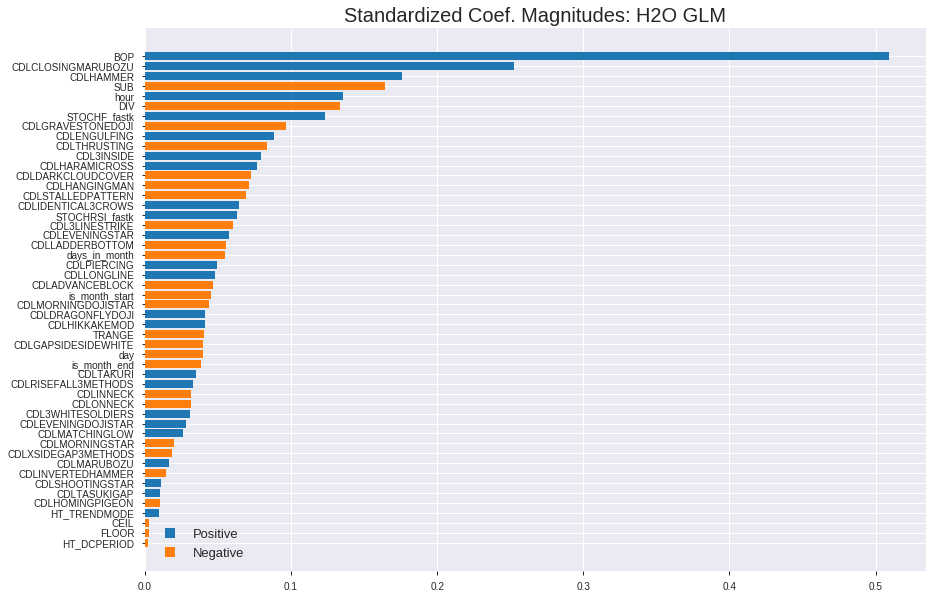

'log_likelihood'
--2019-08-28 13:09:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_130904_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_130904_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'SUB',
 'hour',
 'DIV',
 'STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'CDLENGULFING',
 'CDLTHRUSTING',
 'CDL3INSIDE',
 'CDLHARAMICROSS',
 'CDLDARKCLOUDCOVER',
 'CDLHANGINGMAN',
 'CDLSTALLEDPATTERN',
 'CDLIDENTICAL3CROWS',
 'STOCHRSI_fastk',
 'CDL3LINESTRIKE',
 'CDLEVENINGSTAR',
 'CDLLADDERBOTTOM',
 'days_in_month',
 'CDLPIERCING',
 'CDLLONGLINE',
 'CDLADVANCEBLOCK',
 'is_month_start',
 'CDLMORNINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLHIKKAKEMOD',
 'TRANGE',
 'CDLGAPSIDESIDEWHITE',
 'day',
 'is_month_end',
 'CDLTAKURI',
 'CDLRISEFALL3METHODS',
 'CDLINNECK',
 'CDLONNECK',
 'CDL3WHITESOLDIERS',
 'CDLEVENINGDOJISTAR',
 'CDLMATCHINGLOW',
 'CDLMORNINGSTAR',
 'CDLXSIDEGAP3METHODS',
 'CDLMARUBOZU',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLTASUKIGAP',
 'CDLHOMINGPIGEON',
 'HT_TRENDMODE',
 'CEIL',
 'FLOOR',
 'HT_DCPERIOD']

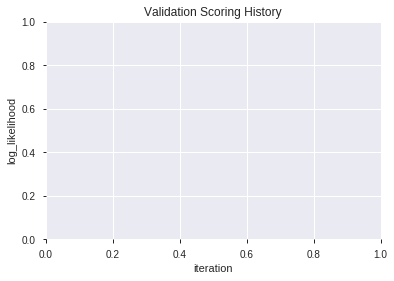

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_130919_model_1  0.731508  0.608110              0.331766  0.457506  0.209312
1  XGBoost_grid_1_AutoML_20190828_130919_model_2  0.728014  0.607392              0.324403  0.458550  0.210268
2               XGBoost_1_AutoML_20190828_130919  0.723771  0.617723              0.335968  0.462721  0.214111
3               XGBoost_3_AutoML_20190828_130919  0.722439  0.613134              0.309094  0.460271  0.211850
4  XGBoost_grid_1_AutoML_20190828_130919_model_6  0.720775  0.613994              0.317955  0.460827  0.212362
5  XGBoost_grid_1_AutoML_20190828_130919_model_4  0.715908  0.617393              0.326358  0.463353  0.214696
6  XGBoost_grid_1_AutoML_20190828_130919_model_7  0.715284  0.626271              0.341376  0.466094  0.217244
7               XGBoost_2_AutoML_20190828_130919  0.710292  0.621279              0.351277  0.465201  0.216412
8  XGBoost_grid_1_AutoML_20190828_130919_model_5  0.709626  0.634349              0.320201  0.469963  0.220866
9  XGBoost_grid_1_AutoML_20190828_130919_model_3  0.708711  0.621445              0.324112  0.465701  0.216878

variable  relative_importance  scaled_importance  percentage
0                  BOP          2997.033447           1.000000    0.427475
1               TRANGE           742.158875           0.247631    0.105856
2         STOCHF_fastk           706.943787           0.235881    0.100833
3       STOCHRSI_fastk           391.691528           0.130693    0.055868
4          HT_DCPERIOD           376.817627           0.125730    0.053747
5                 hour           369.971710           0.123446    0.052770
6                  DIV           349.848541           0.116732    0.049900
7                  SUB           291.902069           0.097397    0.041635
8   CDLCLOSINGMARUBOZU           262.639618           0.087633    0.037461
9            CDLHAMMER           188.102936           0.062763    0.026830
10                 day           155.323456           0.051826    0.022154
11       days_in_month            54.338646           0.018131    0.007750
12   CDLGRAVESTONEDOJI            34.354717           0.011463    0.004900
13         CDLLONGLINE            28.454914           0.009494    0.004059
14        HT_TRENDMODE            25.683384           0.008570    0.003663
15    CDLDRAGONFLYDOJI            18.851799           0.006290    0.002689
16        CDLENGULFING            12.280169           0.004097    0.001752
17           CDLTAKURI             4.614300           0.001540    0.000658

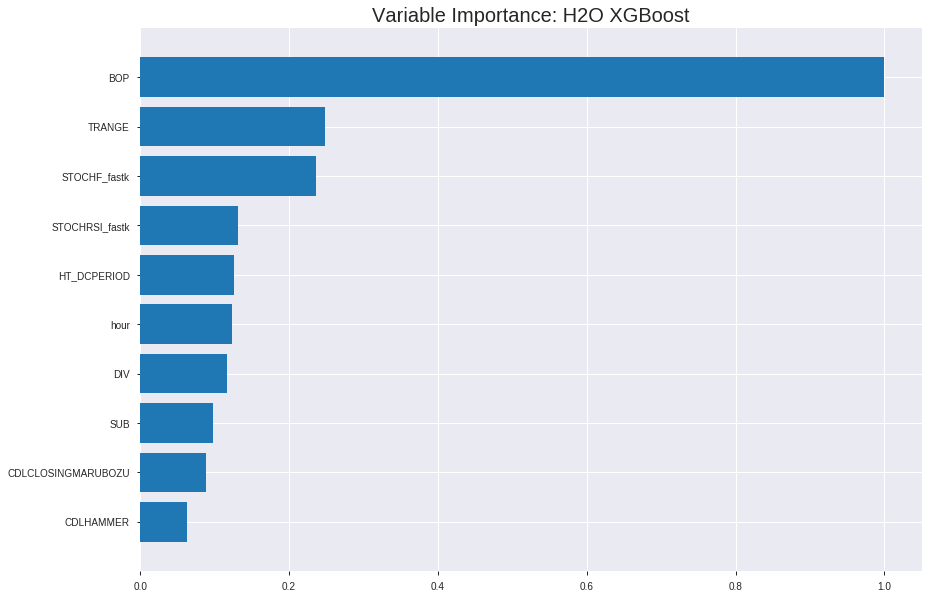

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_130919_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15259306440231607
RMSE: 0.39063162237882904
LogLoss: 0.4702598133458212
Mean Per-Class Error: 0.21035362957937576
AUC: 0.8732895183175035
pr_auc: 0.8634267890832901
Gini: 0.7465790366350069
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40223707258701324: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      510  290  0.3625   (290.0/800.0)
1      69   668  0.0936   (69.0/737.0)
Total  579  958  0.2336   (359.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402237     0.788201  240
max f2                       0.265671     0.86696   295
max f0point5                 0.624623     0.791444  135
max accuracy                 0.531814     0.7892    189
max precision                0.928461     1         0
max recall                   0.0809129    1         377
max specificity              0.928461     1         0
max absolute_mcc             0.531814     0.578807  189
max min_per_class_accuracy   0.5373       0.782904  185
max mean_per_class_accuracy  0.531814     0.789646  189

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 48.03 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.904088           2.08548    2.08548            1                0.915649   1                           0.915649            0.0217096       0.0217096                  108.548   108.548
    2        0.0201692                   0.884688           2.08548    2.08548            1                0.894503   1                           0.905417            0.0203528       0.0420624                  108.548   108.548
    3        0.0305791                   0.864159           2.08548    2.08548            1                0.8717     1                           0.893939            0.0217096       0.063772                   108.548   108.548
    4        0.0403383                   0.852131           2.08548    2.08548            1                0.857589   1                           0.885144            0.0203528       0.0841248                  108.548   108.548
    5        0.0500976                   0.836961           2.08548    2.08548            1                0.846668   1                           0.877649            0.0203528       0.104478                   108.548   108.548
    6        0.100195                    0.791399           2.03131    2.0584             0.974026         0.812217   0.987013                    0.844933            0.101764        0.206242                   103.131   105.84
    7        0.150293                    0.746107           1.76047    1.95909            0.844156         0.770609   0.939394                    0.820158            0.0881954       0.294437                   76.0472   95.9089
    8        0.20039                     0.706807           1.89589    1.94329            0.909091         0.724669   0.931818                    0.796286            0.0949796       0.389417                   89.5892   94.329
    9        0.299935                    0.645611           1.59478    1.82762            0.764706         0.678329   0.876356                    0.757138            0.158752        0.548168                   59.478    82.7624
    10       0.40013                     0.587743           1.32712    1.7023             0.636364         0.616597   0.81626                     0.721945            0.132972        0.68114                    32.7125   70.2296
    11       0.500325                    0.530355           1.1917     1.60004            0.571429         0.560447   0.76723                     0.689604            0.119403        0.800543                   19.1704   60.0044
    12       0.59987                     0.434488           0.831467   1.4725             0.398693         0.489612   0.706074                    0.656416            0.082768        0.883311                   -16.8533  47.2504
    13       0.700065                    0.314087           0.568768   1.34316            0.272727         0.373602   0.644052                    0.615939            0.0569878       0.940299                   -43.1232  34.3159
    14       0.79961                     0.213487           0.408918   1.22685            0.196078         0.258018   0.588283                    0.571381            0.0407056       0.981004                   -59.1082  22.6854
    15       0.899805                    0.107856           0.162505   1.10834            0.0779221        0.161507   0.531453                    0.525741            0.0162822       0.997286                   -83.7495  10.8336
    16       1                           0.0322981          0.0270842  1                  0.012987         0.0721213  0.479506   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18102116552406217
RMSE: 0.4254658218048333
LogLoss: 0.5428062481749906
Mean Per-Class Error: 0.241838168443673
AUC: 0.7992499380114059
pr_auc: 0.7610400045134833
Gini: 0.5984998760228117
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4363827407360077: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      142  76   0.3486   (76.0/218.0)
1      30   192  0.1351   (30.0/222.0)
Total  172  268  0.2409   (106.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436383     0.783673  241
max f2                       0.109799     0.856245  349
max f0point5                 0.525644     0.754039  199
max accuracy                 0.445345     0.759091  239
max precision                0.920998     1         0
max recall                   0.0544212    1         387
max specificity              0.920998     1         0
max absolute_mcc             0.436383     0.528963  241
max min_per_class_accuracy   0.527212     0.747706  197
max mean_per_class_accuracy  0.445345     0.758162  239

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 47.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.897327           1.98198   1.98198            1                0.90474    1                           0.90474             0.0225225       0.0225225                  98.1982   98.1982
    2        0.0204545                   0.879411           1.48649   1.76176            0.75             0.887737   0.888889                    0.897183            0.0135135       0.036036                   48.6486   76.1762
    3        0.0318182                   0.848665           1.58559   1.69884            0.8              0.868842   0.857143                    0.887061            0.018018        0.0540541                  58.5586   69.8842
    4        0.0409091                   0.84093            1.48649   1.65165            0.75             0.843254   0.833333                    0.877326            0.0135135       0.0675676                  48.6486   65.1652
    5        0.05                        0.829153           1.48649   1.62162            0.75             0.837741   0.818182                    0.870129            0.0135135       0.0810811                  48.6486   62.1622
    6        0.1                         0.779657           1.53153   1.57658            0.772727         0.80603    0.795455                    0.838079            0.0765766       0.157658                   53.1532   57.6577
    7        0.15                        0.738878           1.8018    1.65165            0.909091         0.763051   0.833333                    0.81307             0.0900901       0.247748                   80.1802   65.1652
    8        0.2                         0.708741           1.26126   1.55405            0.636364         0.72604    0.784091                    0.791313            0.0630631       0.310811                   26.1261   55.4054
    9        0.3                         0.654073           1.62162   1.57658            0.818182         0.680897   0.795455                    0.754508            0.162162        0.472973                   62.1622   57.6577
    10       0.4                         0.596177           1.17117   1.47523            0.590909         0.626955   0.744318                    0.722619            0.117117        0.59009                    17.1171   47.5225
    11       0.5                         0.528214           1.53153   1.48649            0.772727         0.561262   0.75                        0.690348            0.153153        0.743243                   53.1532   48.6486
    12       0.6                         0.447592           1.08108   1.41892            0.545455         0.493294   0.715909                    0.657506            0.108108        0.851351                   8.10811   41.8919
    13       0.7                         0.279131           0.540541  1.29344            0.272727         0.350633   0.652597                    0.613667            0.0540541       0.905405                   -45.9459  29.3436
    14       0.8                         0.205984           0.45045   1.18806            0.227273         0.240707   0.599432                    0.567047            0.045045        0.95045                    -54.955   18.8063
    15       0.9                         0.0896631          0.36036   1.0961             0.181818         0.147736   0.55303                     0.520457            0.036036        0.986486                   -63.964   9.60961
    16       1                           0.0275633          0.135135  1                  0.0681818        0.0629524  0.504545                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:09:25  0.034 sec   0                  0.5              0.693147            0.5             0                  1                0.520494                         0.5                0.693147              0.5               0                    1                  0.495455
    2019-08-28 13:09:25  0.134 sec   5                  0.468907         0.632406            0.835272        0.793712           2.08548          0.260247                         0.471816           0.637927              0.790716          0.750372             1.98198            0.245455
    2019-08-28 13:09:25  0.224 sec   10                 0.448141         0.592332            0.838435        0.797166           2.08548          0.248536                         0.453875           0.603002              0.795758          0.75326              1.98198            0.252273
    2019-08-28 13:09:25  0.295 sec   15                 0.433641         0.563674            0.843296        0.817688           2.08548          0.25244                          0.443973           0.58297               0.793516          0.768184             1.98198            0.254545
    2019-08-28 13:09:25  0.388 sec   20                 0.423277         0.542464            0.847642        0.831904           2.08548          0.249187                         0.436806           0.568007              0.795293          0.768903             1.98198            0.245455
    2019-08-28 13:09:25  0.471 sec   25                 0.415303         0.525594            0.85275         0.839728           2.08548          0.244632                         0.433574           0.560593              0.79303           0.764283             1.98198            0.245455
    2019-08-28 13:09:25  0.537 sec   30                 0.40981          0.513453            0.855979        0.843678           2.08548          0.249837                         0.430701           0.55418               0.79458           0.758512             1.98198            0.247727
    2019-08-28 13:09:26  0.627 sec   35                 0.405357         0.503528            0.858914        0.846813           2.08548          0.245934                         0.428805           0.549933              0.795345          0.75784              1.98198            0.240909
    2019-08-28 13:09:26  0.700 sec   40                 0.402253         0.496243            0.860451        0.84908            2.08548          0.244632                         0.427958           0.547678              0.794363          0.757705             1.98198            0.240909
    2019-08-28 13:09:26  0.781 sec   45                 0.399886         0.490612            0.862177        0.850323           2.08548          0.24203                          0.426698           0.545075              0.797638          0.759132             1.98198            0.245455
    2019-08-28 13:09:26  0.861 sec   50                 0.397287         0.484693            0.86522         0.855565           2.08548          0.240729                         0.426143           0.543766              0.798175          0.761385             1.98198            0.238636
    2019-08-28 13:09:26  0.945 sec   55                 0.395216         0.480008            0.867188        0.858157           2.08548          0.234223                         0.425626           0.54292               0.799581          0

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
BOP                 2997.03                1                    0.427475
TRANGE              742.159                0.247631             0.105856
STOCHF_fastk        706.944                0.235881             0.100833
STOCHRSI_fastk      391.692                0.130693             0.055868
HT_DCPERIOD         376.818                0.12573              0.0537465
hour                369.972                0.123446             0.0527701
DIV                 349.849                0.116732             0.0498999
SUB                 291.902                0.097397             0.0416348
CDLCLOSINGMARUBOZU  262.64                 0.0876332            0.037461
CDLHAMMER           188.103                0.062763             0.0268296
day                 155.323                0.0518257            0.0221542
days_in_month       54.3386                0.0181308            0.00775047
CDLGRAVESTONEDOJI   34.3547                0.0114629            0.00490011
CDLLONGLINE         28.4549                0.00949436           0.0040586
HT_TRENDMODE        25.6834                0.0085696            0.00366329
CDLDRAGONFLYDOJI    18.8518                0.00629015           0.00268888
CDLENGULFING        12.2802                0.00409744           0.00175155
CDLTAKURI           4.6143                 0.00153962           0.00065815

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6954545454545454)

('F1', 0.7003891050583656)

('auc', 0.7315084449621433)

('logloss', 0.6081102695630806)

('mean_per_class_error', 0.3062234794908062)

('rmse', 0.45750599882547965)

('mse', 0.2093117389612998)

xgboost prediction progress: |████████████████████████████████████████████| 100%


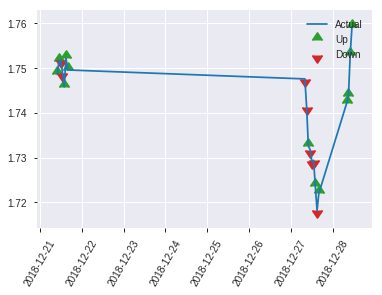


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2093117389612998
RMSE: 0.45750599882547965
LogLoss: 0.6081102695630806
Mean Per-Class Error: 0.3062234794908062
AUC: 0.7315084449621433
pr_auc: 0.6641813455151161
Gini: 0.4630168899242866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2627909183502197: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   66   0.5546   (66.0/119.0)
1      11   90   0.1089   (11.0/101.0)
Total  64   156  0.35     (77.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.262791     0.700389  154
max f2                       0.121108     0.823529  189
max f0point5                 0.54603      0.667976  100
max accuracy                 0.54603      0.695455  100
max precision                0.881804     1         0
max recall                   0.0457699    1         216
max specificity              0.881804     1         0
max absolute_mcc             0.54603      0.387279  100
max min_per_class_accuracy   0.537394     0.683168  104
max mean_per_class_accuracy  0.54603      0.693777  100

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 45.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.843375           1.45215   1.45215            0.666667         0.858615   0.666667                    0.858615            0.019802        0.019802                   45.2145   45.2145
    2        0.0227273                   0.836291           2.17822   1.74257            1                0.841076   0.8                         0.851599            0.019802        0.039604                   117.822   74.2574
    3        0.0318182                   0.826173           2.17822   1.86704            1                0.829109   0.857143                    0.845173            0.019802        0.0594059                  117.822   86.7044
    4        0.0409091                   0.811178           2.17822   1.93619            1                0.818665   0.888889                    0.839283            0.019802        0.0792079                  117.822   93.6194
    5        0.05                        0.805003           1.08911   1.78218            0.5              0.808193   0.818182                    0.83363             0.00990099      0.0891089                  8.91089   78.2178
    6        0.1                         0.755883           1.58416   1.68317            0.727273         0.789191   0.772727                    0.81141             0.0792079       0.168317                   58.4158   68.3168
    7        0.15                        0.703763           1.58416   1.65017            0.727273         0.733036   0.757576                    0.785286            0.0792079       0.247525                   58.4158   65.0165
    8        0.2                         0.67577            1.38614   1.58416            0.636364         0.69423    0.727273                    0.762522            0.0693069       0.316832                   38.6139   58.4158
    9        0.3                         0.601653           1.08911   1.41914            0.5              0.638536   0.651515                    0.721193            0.108911        0.425743                   8.91089   41.9142
    10       0.4                         0.56475            1.48515   1.43564            0.681818         0.586672   0.659091                    0.687563            0.148515        0.574257                   48.5149   43.5644
    11       0.5                         0.529327           1.28713   1.40594            0.590909         0.549934   0.645455                    0.660037            0.128713        0.70297                    28.7129   40.5941
    12       0.6                         0.427526           0.891089  1.32013            0.409091         0.486342   0.606061                    0.631088            0.0891089       0.792079                   -10.8911  32.0132
    13       0.7                         0.26853            0.792079  1.2447             0.363636         0.342464   0.571429                    0.589856            0.0792079       0.871287                   -20.7921  24.4696
    14       0.8                         0.192659           0.594059  1.16337            0.272727         0.22911    0.534091                    0.544763            0.0594059       0.930693                   -40.5941  16.3366
    15       0.9                         0.104432           0.49505   1.08911            0.227273         0.143217   0.5                         0.500147            0.049505        0.980198                   -50.495   8.91089
    16       1                           0.0407443          0.19802   1                  0.0909091        0.0665048  0.459091                   

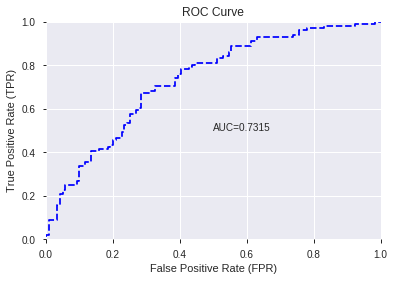

This function is available for GLM models only


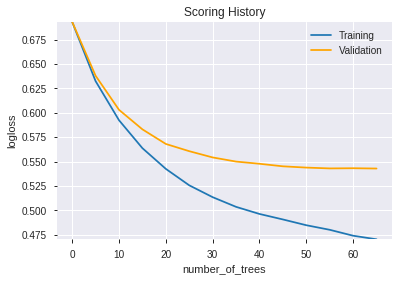

--2019-08-28 13:09:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_130919_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_130919_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'HT_DCPERIOD',
 'hour',
 'DIV',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'day',
 'days_in_month',
 'CDLGRAVESTONEDOJI',
 'CDLLONGLINE',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLTAKURI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_130952_model_1  0.723604  0.620616              0.363882  0.461568  0.213045

variable  relative_importance  scaled_importance    percentage
0                          BOP         3.382168e-01           1.000000  3.689945e-02
1           CDLCLOSINGMARUBOZU         2.041494e-01           0.603605  2.227269e-02
2                    CDLHAMMER         1.563415e-01           0.462252  1.705685e-02
3                          SUB         1.509935e-01           0.446440  1.647339e-02
4                          DIV         1.414735e-01           0.418292  1.543476e-02
...                        ...                  ...                ...           ...
1033  BBANDS_middleband_20_2_3         1.052403e-05           0.000031  1.148171e-06
1034  BBANDS_middleband_20_2_5         9.539191e-06           0.000028  1.040726e-06
1035                    EMA_20         8.624306e-06           0.000025  9.409116e-07
1036  BBANDS_middleband_20_1_4         2.072400e-06           0.000006  2.260987e-07
1037  BBANDS_middleband_20_1_3         7.061620e-07           0.000002  7.704225e-08

[1038 rows x 4 columns]

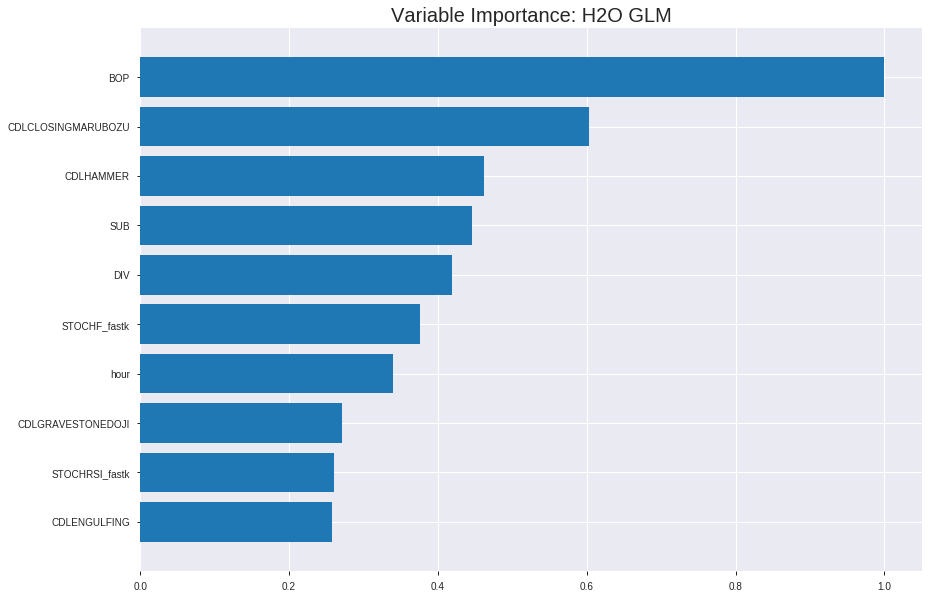

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_130952_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18082972680372622
RMSE: 0.42524078685343225
LogLoss: 0.5393478228591304
Null degrees of freedom: 1536
Residual degrees of freedom: 498
Null deviance: 2128.1514062818787
Residual deviance: 1657.9552074689668
AIC: 3735.955207468967
AUC: 0.8098685549525102
pr_auc: 0.7695495072387462
Gini: 0.6197371099050204
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38283056688990447: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      443  357   0.4462   (357.0/800.0)
1      89   648   0.1208   (89.0/737.0)
Total  532  1005  0.2902   (446.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382831     0.743972  249
max f2                       0.17834      0.850127  341
max f0point5                 0.572739     0.743265  156
max accuracy                 0.572739     0.735198  156
max precision                0.97328      1         0
max recall                   0.0694585    1         383
max specificity              0.97328      1         0
max absolute_mcc             0.572739     0.474628  156
max min_per_class_accuracy   0.499517     0.7275    193
max mean_per_class_accuracy  0.445791     0.734289  217

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 47.95 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.890496           1.95514    1.95514            0.9375           0.913443  0.9375                      0.913443            0.0203528       0.0203528                  95.5139   95.5139
    2        0.0201692                   0.868967           1.39032    1.68184            0.666667         0.883293  0.806452                    0.898854            0.0135685       0.0339213                  39.0321   68.184
    3        0.0305791                   0.848742           1.69445    1.68613            0.8125           0.859572  0.808511                    0.885482            0.0176391       0.0515604                  69.4454   68.6134
    4        0.0403383                   0.839467           1.94645    1.74911            0.933333         0.844946  0.83871                     0.875675            0.0189959       0.0705563                  94.645    74.9114
    5        0.0500976                   0.827724           1.94645    1.78756            0.933333         0.83358   0.857143                    0.867474            0.0189959       0.0895522                  94.645    78.7556
    6        0.100195                    0.761173           1.84172    1.81464            0.883117         0.790407  0.87013                     0.828941            0.0922659       0.181818                   84.1724   81.464
    7        0.150293                    0.718982           1.59797    1.74242            0.766234         0.736985  0.835498                    0.798289            0.0800543       0.261872                   59.7966   74.2415
    8        0.20039                     0.683123           1.7063     1.73339            0.818182         0.699939  0.831169                    0.773701            0.0854817       0.347354                   70.6303   73.3387
    9        0.299935                    0.626438           1.59478    1.68739            0.764706         0.65533   0.809111                    0.734416            0.158752        0.506106                   59.478    68.7385
    10       0.40013                     0.561666           1.2865     1.587              0.616883         0.591513  0.760976                    0.698632            0.128901        0.635007                   28.6498   58.7001
    11       0.500325                    0.491126           0.988572   1.46716            0.474026         0.527131  0.703511                    0.664287            0.0990502       0.734057                   -1.14275  46.7159
    12       0.59987                     0.42197            1.00866    1.39108            0.48366          0.455725  0.667028                    0.629678            0.100407        0.834464                   0.866434  39.1075
    13       0.700065                    0.345926           0.731273   1.29664            0.350649         0.383748  0.621747                    0.59448             0.07327         0.907734                   -26.8727  29.6642
    14       0.79961                     0.273575           0.477071   1.19461            0.228758         0.30964   0.572823                    0.559019            0.0474898       0.955224                   -52.2929  19.4613
    15       0.899805                    0.163174           0.406263   1.10683            0.194805         0.222984  0.53073                     0.521601            0.0407056       0.995929                   -59.3737  10.6828
    16       1                           0.0181833          0.0406263  1                  0.0194805        0.101465  0.479506                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.193273951789572
RMSE: 0.4396293345416932
LogLoss: 0.5676679214509386
Null degrees of freedom: 439
Residual degrees of freedom: -599
Null deviance: 611.0374769186825
Residual deviance: 499.54777087682595
AIC: 2577.547770876826
AUC: 0.7734833457310522
pr_auc: 0.7355220824190846
Gini: 0.5469666914621043
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32835118242152245: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      105  113  0.5183   (113.0/218.0)
1      19   203  0.0856   (19.0/222.0)
Total  124  316  0.3      (132.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.328351     0.754647  286
max f2                       0.174544     0.85815   353
max f0point5                 0.456857     0.722037  221
max accuracy                 0.435543     0.729545  230
max precision                0.931568     1         0
max recall                   0.0796624    1         385
max specificity              0.931568     1         0
max absolute_mcc             0.428196     0.464861  235
max min_per_class_accuracy   0.50235      0.697248  199
max mean_per_class_accuracy  0.435543     0.728883  230

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 47.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.874411           1.58559   1.58559            0.8              0.898323   0.8                         0.898323            0.018018        0.018018                   58.5586   58.5586
    2        0.0204545                   0.856472           1.48649   1.54154            0.75             0.868451   0.777778                    0.885046            0.0135135       0.0315315                  48.6486   54.1542
    3        0.0318182                   0.846292           1.98198   1.69884            1                0.849408   0.857143                    0.872318            0.0225225       0.0540541                  98.1982   69.8842
    4        0.0409091                   0.832162           1.98198   1.76176            1                0.84066    0.888889                    0.865283            0.018018        0.0720721                  98.1982   76.1762
    5        0.05                        0.827375           1.98198   1.8018             1                0.829529   0.909091                    0.858782            0.018018        0.0900901                  98.1982   80.1802
    6        0.1                         0.770631           1.44144   1.62162            0.727273         0.795748   0.818182                    0.827265            0.0720721       0.162162                   44.1441   62.1622
    7        0.15                        0.725556           1.35135   1.53153            0.681818         0.743996   0.772727                    0.799509            0.0675676       0.22973                    35.1351   53.1532
    8        0.2                         0.673677           1.71171   1.57658            0.863636         0.698702   0.795455                    0.774307            0.0855856       0.315315                   71.1712   57.6577
    9        0.3                         0.628945           1.30631   1.48649            0.659091         0.650808   0.75                        0.733141            0.130631        0.445946                   30.6306   48.6486
    10       0.4                         0.560637           1.35135   1.4527             0.681818         0.594138   0.732955                    0.69839             0.135135        0.581081                   35.1351   45.2703
    11       0.5                         0.502523           1.12613   1.38739            0.568182         0.530316   0.7                         0.664775            0.112613        0.693694                   12.6126   38.7387
    12       0.6                         0.412542           1.21622   1.35886            0.613636         0.459454   0.685606                    0.630555            0.121622        0.815315                   21.6216   35.8859
    13       0.7                         0.342277           0.720721  1.2677             0.363636         0.37799    0.63961                     0.594474            0.0720721       0.887387                   -27.9279  26.7696
    14       0.8                         0.255278           0.585586  1.18243            0.295455         0.296112   0.596591                    0.557179            0.0585586       0.945946                   -41.4414  18.2432
    15       0.9                         0.14879            0.405405  1.0961             0.204545         0.208396   0.55303                     0.518425            0.0405405       0.986486                   -59.4595  9.60961
    16       1                           0.0121265          0.135135  1                  0.0681818        0.0974439  0.504545                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 13:09:55  0.000 sec   2            .21E2     1038          1.3555303093014088  1.3583902789243487
     2019-08-28 13:09:57  1.702 sec   4            .15E2     1038          1.3478703000344687  1.350411441546862
     2019-08-28 13:09:59  3.383 sec   6            .11E2     1039          1.338438342177777   1.340510890851735
     2019-08-28 13:10:00  5.105 sec   8            .82E1     1039          1.3269998037888067  1.3285247611650708
     2019-08-28 13:10:02  6.825 sec   10           .59E1     1039          1.313358586251909   1.3142756828923223
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 13:10:27  31.581 sec  38           .7E-1     1039          1.0683318754348612  1.137175226970111
     2019-08-28 13:10:29  33.285 sec  40           .51E-1    1039          1.0591140390019804  1.1411333745797803
     2019-08-28 13:10:30  34.987 sec  42           .37E-1    1039          1.0508759199668394  1.1468482524016432
     2019-08-28 13:10:32  36.750 sec  44           .27E-1    1039          1.0434398648913774  1.1540841228736907
     2019-08-28 13:10:34  38.468 sec  46           .2E-1     1039          1.0366474248522946  1.1626021980538863


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7)

('F1', 0.6840148698884758)

('auc', 0.7236042932024295)

('logloss', 0.6206157592617563)

('mean_per_class_error', 0.30501705632748144)

('rmse', 0.4615678353827655)

('mse', 0.21304486665993172)

glm prediction progress: |████████████████████████████████████████████████| 100%


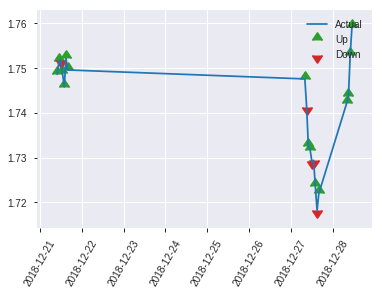


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21304486665993172
RMSE: 0.4615678353827655
LogLoss: 0.6206157592617563
Null degrees of freedom: 219
Residual degrees of freedom: -819
Null deviance: 303.8782617497692
Residual deviance: 273.0709340751728
AIC: 2351.0709340751728
AUC: 0.7236042932024295
pr_auc: 0.6502875884085224
Gini: 0.44720858640485894
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26108433729131303: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      43   76   0.6387   (76.0/119.0)
1      9    92   0.0891   (9.0/101.0)
Total  52   168  0.3864   (85.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.261084     0.684015  167
max f2                       0.21646      0.822034  185
max f0point5                 0.548605     0.676533  92
max accuracy                 0.548605     0.7       92
max precision                0.939618     1         0
max recall                   0.0176439    1         219
max specificity              0.939618     1         0
max absolute_mcc             0.548605     0.393385  92
max min_per_class_accuracy   0.504157     0.663366  105
max mean_per_class_accuracy  0.548605     0.694983  92

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 46.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0136364                   0.84992            2.17822   2.17822            1                0.890946  1                           0.890946            0.029703        0.029703                   117.822    117.822
    2        0.0227273                   0.846297           1.08911   1.74257            0.5              0.848376  0.8                         0.873918            0.00990099      0.039604                   8.91089    74.2574
    3        0.0318182                   0.839317           1.08911   1.55587            0.5              0.844908  0.714286                    0.865629            0.00990099      0.049505                   8.91089    55.587
    4        0.0409091                   0.830961           2.17822   1.69417            1                0.833909  0.777778                    0.85858             0.019802        0.0693069                  117.822    69.4169
    5        0.05                        0.811442           1.08911   1.58416            0.5              0.829987  0.727273                    0.853381            0.00990099      0.0792079                  8.91089    58.4158
    6        0.1                         0.754671           1.38614   1.48515            0.636364         0.78292   0.681818                    0.818151            0.0693069       0.148515                   38.6139    48.5149
    7        0.15                        0.707976           1.58416   1.51815            0.727273         0.733794  0.69697                     0.790032            0.0792079       0.227723                   58.4158    51.8152
    8        0.2                         0.668946           1.58416   1.53465            0.727273         0.69095   0.704545                    0.765261            0.0792079       0.306931                   58.4158    53.4653
    9        0.3                         0.616213           1.38614   1.48515            0.636364         0.644387  0.681818                    0.72497             0.138614        0.445545                   38.6139    48.5149
    10       0.4                         0.562187           1.38614   1.4604             0.636364         0.588874  0.670455                    0.690946            0.138614        0.584158                   38.6139    46.0396
    11       0.5                         0.485536           0.990099  1.36634            0.454545         0.529675  0.627273                    0.658692            0.0990099       0.683168                   -0.990099  36.6337
    12       0.6                         0.381261           0.891089  1.28713            0.409091         0.441343  0.590909                    0.622467            0.0891089       0.772277                   -10.8911   28.7129
    13       0.7                         0.317743           0.693069  1.20226            0.318182         0.349048  0.551948                    0.583407            0.0693069       0.841584                   -30.6931   20.2263
    14       0.8                         0.241704           0.891089  1.16337            0.409091         0.275354  0.534091                    0.5449              0.0891089       0.930693                   -10.8911   16.3366
    15       0.9                         0.166231           0.29703   1.06711            0.136364         0.207152  0.489899                    0.507373            0.029703        0.960396                   -70.297    6.71067
    16       1                           0.0176439          0.39604   1                  0.181818         0.110397  0.459091                    0

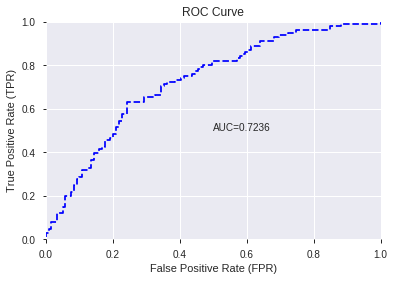

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


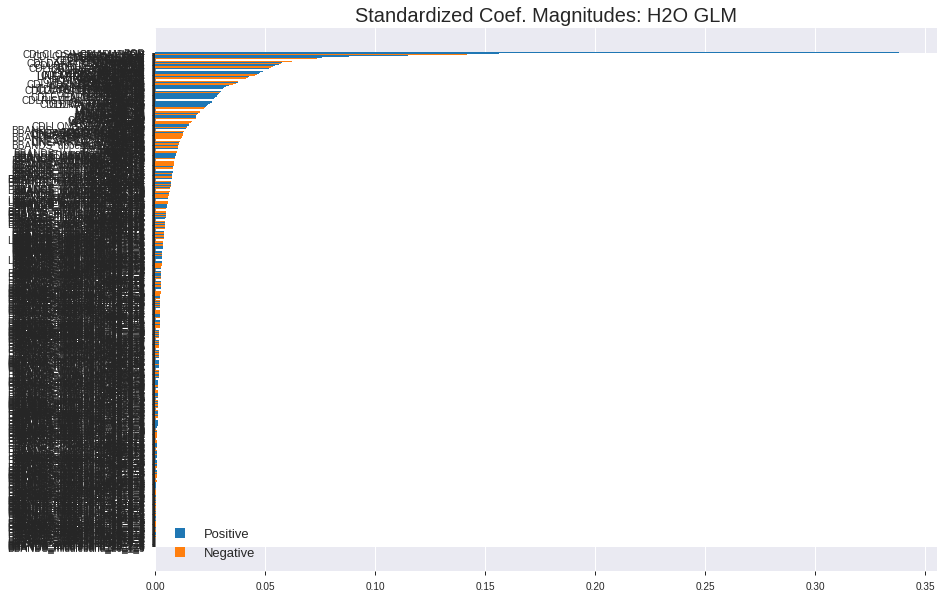

'log_likelihood'
--2019-08-28 13:10:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.252
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.252|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_130952_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_130952_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

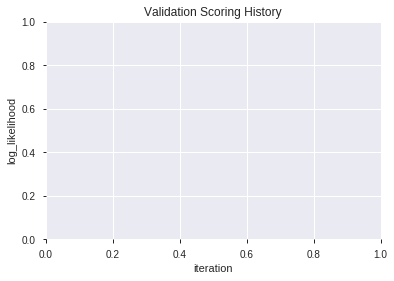

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190828_131107  0.748981  0.585813              0.294991  0.448333  0.201002
1               XGBoost_2_AutoML_20190828_131107  0.747733  0.588101              0.298444  0.449765  0.202288
2               XGBoost_1_AutoML_20190828_131107  0.746734  0.585316              0.318870  0.450154  0.202639
3  XGBoost_grid_1_AutoML_20190828_131107_model_2  0.744821  0.591403              0.318413  0.451554  0.203901
4  XGBoost_grid_1_AutoML_20190828_131107_model_6  0.743573  0.594538              0.343331  0.452393  0.204660
5  XGBoost_grid_1_AutoML_20190828_131107_model_7  0.740078  0.590408              0.297404  0.451654  0.203991
6  XGBoost_grid_1_AutoML_20190828_131107_model_4  0.736667  0.597292              0.302646  0.454783  0.206828
7  XGBoost_grid_1_AutoML_20190828_131107_model_1  0.732424  0.598011              0.306847  0.454727  0.206777
8  XGBoost_grid_1_AutoML_20190828_131107_model_5  0.726849  0.612235              0.325609  0.460292  0.211869
9  XGBoost_grid_1_AutoML_20190828_131107_model_3  0.718529  0.604786              0.299651  0.458142  0.209894

variable  relative_importance  scaled_importance  percentage
0                        BOP          2075.656250           1.000000    0.224284
1                     TRANGE           367.269867           0.176942    0.039685
2               STOCHF_fastk           312.264435           0.150441    0.033742
3                        SUB           298.200165           0.143665    0.032222
4             STOCHRSI_fastk           279.084900           0.134456    0.030156
..                       ...                  ...                ...         ...
307              AROONOSC_30             0.852024           0.000410    0.000092
308                  ROCP_14             0.801879           0.000386    0.000087
309   LINEARREG_INTERCEPT_14             0.761390           0.000367    0.000082
310    LINEARREG_INTERCEPT_8             0.717592           0.000346    0.000078
311  BBANDS_upperband_24_5_2             0.279085           0.000134    0.000030

[312 rows x 4 columns]

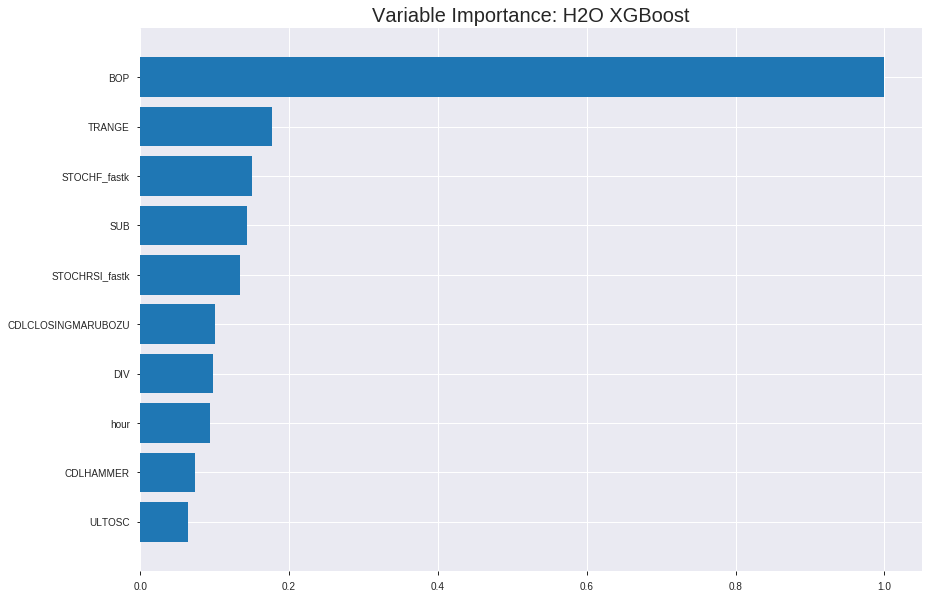

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190828_131107


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11213990192940505
RMSE: 0.33487296386750165
LogLoss: 0.38057921999645883
Mean Per-Class Error: 0.1102518656716418
AUC: 0.9595683514246948
pr_auc: 0.9602695830481562
Gini: 0.9191367028493895
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5598833986691066: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      743  57   0.0712   (57.0/800.0)
1      110  627  0.1493   (110.0/737.0)
Total  853  684  0.1087   (167.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.559883     0.882477  170
max f2                       0.380245     0.909792  241
max f0point5                 0.623523     0.92331   139
max accuracy                 0.559883     0.891347  170
max precision                0.931986     1         0
max recall                   0.139869     1         346
max specificity              0.931986     1         0
max absolute_mcc             0.559883     0.783592  170
max min_per_class_accuracy   0.527989     0.87924   183
max mean_per_class_accuracy  0.559883     0.889748  170

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 48.06 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.912001           2.08548    2.08548            1                0.922419   1                           0.922419            0.0217096       0.0217096                  108.548   108.548
    2        0.0201692                   0.894088           2.08548    2.08548            1                0.904255   1                           0.91363             0.0203528       0.0420624                  108.548   108.548
    3        0.0305791                   0.873826           2.08548    2.08548            1                0.883163   1                           0.903258            0.0217096       0.063772                   108.548   108.548
    4        0.0403383                   0.86245            2.08548    2.08548            1                0.866843   1                           0.894448            0.0203528       0.0841248                  108.548   108.548
    5        0.0500976                   0.852081           2.08548    2.08548            1                0.8562     1                           0.886997            0.0203528       0.104478                   108.548   108.548
    6        0.100195                    0.808087           2.08548    2.08548            1                0.828342   1                           0.85767             0.104478        0.208955                   108.548   108.548
    7        0.150293                    0.772781           2.08548    2.08548            1                0.790765   1                           0.835368            0.104478        0.313433                   108.548   108.548
    8        0.20039                     0.740309           2.08548    2.08548            1                0.75644    1                           0.815636            0.104478        0.41791                    108.548   108.548
    9        0.299935                    0.66714            2.07185    2.08096            0.993464         0.705826   0.997831                    0.779192            0.206242        0.624152                   107.185   108.096
    10       0.40013                     0.593958           1.66568    1.97697            0.798701         0.631672   0.947967                    0.742252            0.166893        0.791045                   66.5677   97.6969
    11       0.500325                    0.50694            1.0292     1.78717            0.493506         0.551933   0.856957                    0.704139            0.103121        0.894166                   2.91988   78.7168
    12       0.59987                     0.394231           0.613377   1.59239            0.294118         0.455618   0.763557                    0.662898            0.0610583       0.955224                   -38.6623  59.2385
    13       0.700065                    0.300249           0.243758   1.39937            0.116883         0.347544   0.671004                    0.617764            0.0244233       0.979647                   -75.6242  39.9366
    14       0.79961                     0.201033           0.190828   1.24891            0.0915033        0.246692   0.598861                    0.571569            0.0189959       0.998643                   -80.9172  24.8913
    15       0.899805                    0.112854           0.0135421  1.11135            0.00649351       0.158115   0.532899                    0.52553             0.00135685      1                          -98.6458  11.1352
    16       1                           0.0333559          0          1                  0                0.0766216  0.479506 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17998486078556356
RMSE: 0.42424622660144373
LogLoss: 0.5382479311052701
Mean Per-Class Error: 0.24150756260848005
AUC: 0.8090131415819489
pr_auc: 0.7743789093224863
Gini: 0.6180262831638978
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26966214179992676: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      116  102  0.4679   (102.0/218.0)
1      16   206  0.0721   (16.0/222.0)
Total  132  308  0.2682   (118.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.269662     0.777358  280
max f2                       0.215285     0.870809  304
max f0point5                 0.495619     0.755064  194
max accuracy                 0.439568     0.759091  223
max precision                0.91661      1         0
max recall                   0.0479111    1         395
max specificity              0.91661      1         0
max absolute_mcc             0.439568     0.521838  223
max min_per_class_accuracy   0.488857     0.747706  198
max mean_per_class_accuracy  0.439568     0.758492  223

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 45.42 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113636                   0.882954           1.98198    1.98198            1                0.896329   1                           0.896329            0.0225225       0.0225225                  98.1982    98.1982
    2        0.0204545                   0.870752           1.98198    1.98198            1                0.878579   1                           0.88844             0.018018        0.0405405                  98.1982    98.1982
    3        0.0318182                   0.845912           1.58559    1.84041            0.8              0.860008   0.928571                    0.878286            0.018018        0.0585586                  58.5586    84.0412
    4        0.0409091                   0.830366           1.48649    1.76176            0.75             0.835796   0.888889                    0.868844            0.0135135       0.0720721                  48.6486    76.1762
    5        0.05                        0.813643           0.990991   1.62162            0.5              0.823739   0.818182                    0.860643            0.00900901      0.0810811                  -0.900901  62.1622
    6        0.1                         0.75331            1.8018     1.71171            0.909091         0.775334   0.863636                    0.817988            0.0900901       0.171171                   80.1802    71.1712
    7        0.15                        0.712058           1.71171    1.71171            0.863636         0.733947   0.863636                    0.789974            0.0855856       0.256757                   71.1712    71.1712
    8        0.2                         0.681307           1.17117    1.57658            0.590909         0.699981   0.795455                    0.767476            0.0585586       0.315315                   17.1171    57.6577
    9        0.3                         0.630115           1.44144    1.53153            0.727273         0.654114   0.772727                    0.729689            0.144144        0.459459                   44.1441    53.1532
    10       0.4                         0.555473           1.53153    1.53153            0.772727         0.598513   0.772727                    0.696895            0.153153        0.612613                   53.1532    53.1532
    11       0.5                         0.489287           1.30631    1.48649            0.659091         0.520552   0.75                        0.661626            0.130631        0.743243                   30.6306    48.6486
    12       0.6                         0.399393           0.990991   1.4039             0.5              0.450335   0.708333                    0.626411            0.0990991       0.842342                   -0.900901  40.3904
    13       0.7                         0.269451           0.855856   1.32561            0.431818         0.336145   0.668831                    0.584945            0.0855856       0.927928                   -14.4144   32.5611
    14       0.8                         0.190218           0.36036    1.20495            0.181818         0.223107   0.607955                    0.539715            0.036036        0.963964                   -63.964    20.4955
    15       0.9                         0.108777           0.27027    1.1011             0.136364         0.150779   0.555556                    0.4965              0.027027        0.990991                   -72.973    10.1101
    16       1                           0.0418246          0.0900901  1                  0.0454545        0.0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:11:21  0.014 sec   0                  0.5              0.693147            0.5             0                  1                0.520494                         0.5                0.693147              0.5               0                    1                  0.495455
    2019-08-28 13:11:22  1.205 sec   5                  0.466895         0.628647            0.873022        0.851016           2.08548          0.225114                         0.474973           0.643933              0.765972          0.691092             1.98198            0.290909
    2019-08-28 13:11:22  1.420 sec   10                 0.444148         0.585518            0.889942        0.878128           2.08548          0.214053                         0.460199           0.615103              0.787172          0.7543               1.98198            0.270455
    2019-08-28 13:11:22  1.640 sec   15                 0.424565         0.548564            0.902151        0.897581           2.08548          0.186077                         0.449315           0.593372              0.78864           0.755433             1.98198            0.268182
    2019-08-28 13:11:23  1.853 sec   20                 0.408778         0.518505            0.909404        0.906099           2.08548          0.180221                         0.440388           0.57517               0.795686          0.76366              1.98198            0.261364
    2019-08-28 13:11:23  2.055 sec   25                 0.396092         0.494156            0.91603         0.913521           2.08548          0.170462                         0.435585           0.564905              0.79864           0.762784             1.98198            0.284091
    2019-08-28 13:11:23  2.265 sec   30                 0.38532          0.473575            0.923323        0.925541           2.08548          0.172414                         0.431905           0.556771              0.801802          0.768132             1.98198            0.245455
    2019-08-28 13:11:23  2.467 sec   35                 0.376642         0.45681             0.928471        0.928953           2.08548          0.158751                         0.429204           0.550405              0.803796          0.771482             1.98198            0.25
    2019-08-28 13:11:23  2.677 sec   40                 0.368999         0.442247            0.933606        0.93507            2.08548          0.160052                         0.426828           0.545036              0.805728          0.77538              1.98198            0.247727
    2019-08-28 13:11:24  2.880 sec   45                 0.361761         0.428584            0.938855        0.939383           2.08548          0.150293                         0.425539           0.541937              0.806637          0.775042             1.98198            0.243182
    2019-08-28 13:11:24  3.070 sec   50                 0.356027         0.417983            0.943763        0.944614           2.08548          0.145738                         0.424945           0.540409              0.806585          0.7708               1.98198            0.236364
    2019-08-28 13:11:24  3.271 sec   55                 0.350891         0.408419            0.9467          0.947375           2.08548          0.135979                         0.424568           0.539298              0.806327          0.771

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      2075.65625             1.0                     0.22428449708440276
TRANGE                   367.2698669433594      0.1769415658027958      0.039685250099406814
STOCHF_fastk             312.2644348144531      0.1504413049195661      0.03374165241460617
SUB                      298.2001647949219      0.14366548641901658     0.032221941369875225
STOCHRSI_fastk           279.08489990234375     0.13445622313537886     0.03015644638578669
---                      ---                    ---                     ---
AROONOSC_30              0.8520240783691406     0.0004104841918642071   9.206524053336118e-05
ROCP_14                  0.8018789291381836     0.00038632549543701354  8.664681945497332e-05
LINEARREG_INTERCEPT_14   0.7613897323608398     0.0003668187988068062   8.227176981148925e-05
LINEARREG_INTERCEPT_8    0.7175922393798828     0.00034571824664121663  7.753924308082678e-05
BBANDS_upperband_24_5_2  0.2790851593017578     0.00013445634810762034  3.0156474415123015e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7)

('F1', 0.7124463519313304)

('auc', 0.7489807804309844)

('logloss', 0.5858128089271857)

('mean_per_class_error', 0.2949912638322656)

('rmse', 0.44833262918401967)

('mse', 0.2010021463910557)

xgboost prediction progress: |████████████████████████████████████████████| 100%


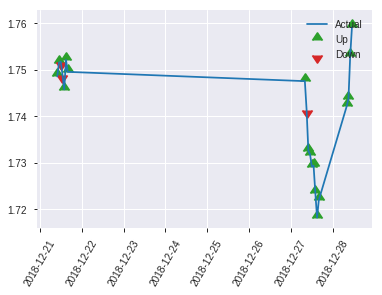


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2010021463910557
RMSE: 0.44833262918401967
LogLoss: 0.5858128089271857
Mean Per-Class Error: 0.2949912638322656
AUC: 0.7489807804309844
pr_auc: 0.67844359618645
Gini: 0.49796156086196874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4375901222229004: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   49   0.4118   (49.0/119.0)
1      18   83   0.1782   (18.0/101.0)
Total  88   132  0.3045   (67.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43759      0.712446  131
max f2                       0.295631     0.836237  169
max f0point5                 0.518458     0.668449  114
max accuracy                 0.518458     0.7       114
max precision                0.863596     1         0
max recall                   0.0923336    1         214
max specificity              0.863596     1         0
max absolute_mcc             0.43759      0.417069  131
max min_per_class_accuracy   0.536299     0.672269  106
max mean_per_class_accuracy  0.43759      0.705009  131

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 48.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.814814           1.45215   1.45215            0.666667         0.834439  0.666667                    0.834439            0.019802        0.019802                   45.2145   45.2145
    2        0.0227273                   0.799165           2.17822   1.74257            1                0.801626  0.8                         0.821314            0.019802        0.039604                   117.822   74.2574
    3        0.0318182                   0.788498           1.08911   1.55587            0.5              0.794225  0.714286                    0.813574            0.00990099      0.049505                   8.91089   55.587
    4        0.0409091                   0.778776           2.17822   1.69417            1                0.783941  0.777778                    0.806989            0.019802        0.0693069                  117.822   69.4169
    5        0.05                        0.77352            2.17822   1.78218            1                0.776777  0.818182                    0.801496            0.019802        0.0891089                  117.822   78.2178
    6        0.1                         0.744068           1.78218   1.78218            0.818182         0.759436  0.818182                    0.780466            0.0891089       0.178218                   78.2178   78.2178
    7        0.15                        0.709395           1.18812   1.58416            0.545455         0.731976  0.727273                    0.764302            0.0594059       0.237624                   18.8119   58.4158
    8        0.2                         0.685278           1.9802    1.68317            0.909091         0.699481  0.772727                    0.748097            0.0990099       0.336634                   98.0198   68.3168
    9        0.3                         0.623586           1.08911   1.48515            0.5              0.65589   0.681818                    0.717362            0.108911        0.445545                   8.91089   48.5149
    10       0.4                         0.577202           1.18812   1.41089            0.545455         0.602685  0.647727                    0.688692            0.118812        0.564356                   18.8119   41.0891
    11       0.5                         0.523914           1.28713   1.38614            0.590909         0.553359  0.636364                    0.661626            0.128713        0.693069                   28.7129   38.6139
    12       0.6                         0.436088           1.28713   1.36964            0.590909         0.49189   0.628788                    0.633336            0.128713        0.821782                   28.7129   36.9637
    13       0.7                         0.360704           0.693069  1.27298            0.318182         0.399535  0.584416                    0.599936            0.0693069       0.891089                   -30.6931  27.2984
    14       0.8                         0.262203           0.594059  1.18812            0.272727         0.314734  0.545455                    0.564286            0.0594059       0.950495                   -40.5941  18.8119
    15       0.9                         0.156069           0.29703   1.08911            0.136364         0.207199  0.5                         0.52461             0.029703        0.980198                   -70.297   8.91089
    16       1                           0.0549891          0.19802   1                  0.0909091        0.107438  0.459091                    0.482892          

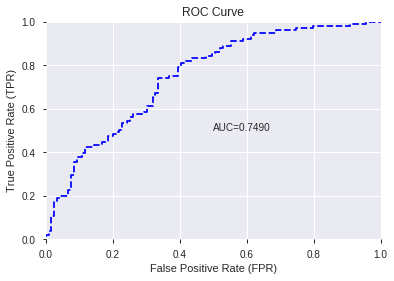

This function is available for GLM models only


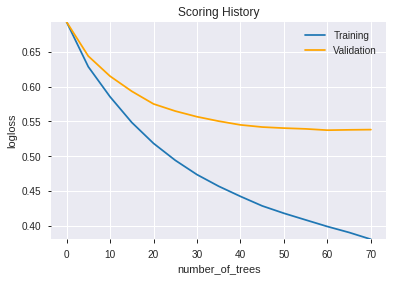

--2019-08-28 13:12:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.64.48
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.64.48|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setRightChild(SharedTreeNode.java:220)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeRightEdge(SharedT

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190828_131107',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190828_131107',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_b106',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_131222  0.732257  0.647015              0.276521  0.465987  0.217144
1  DeepLearning_grid_1_AutoML_20190828_131222_model_9  0.718030  0.634035              0.310883  0.467258  0.218330
2  DeepLearning_grid_1_AutoML_20190828_131222_model_8  0.717031  0.672035              0.325901  0.484740  0.234973
3  DeepLearning_grid_1_AutoML_20190828_131222_model_6  0.712455  0.647672              0.368833  0.471203  0.222032
4  DeepLearning_grid_1_AutoML_20190828_131222_model_3  0.709626  0.882730              0.321241  0.482934  0.233225
5  DeepLearning_grid_1_AutoML_20190828_131222_model_5  0.704302  0.688667              0.368833  0.479979  0.230380
6  DeepLearning_grid_1_AutoML_20190828_131222_model_2  0.683168  1.001279              0.336550  0.496664  0.246675
7  DeepLearning_grid_1_AutoML_20190828_131222_model_7  0.679674  0.772302              0.372577  0.511381  0.261511
8  DeepLearning_grid_1_AutoML_20190828_131222_model_1  0.665030  1.226653              0.383975  0.513344  0.263522
9  DeepLearning_grid_1_AutoML_20190828_131222_model_4  0.662118  0.961069              0.398536  0.505579  0.255610

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.031130
1      CDLDRAGONFLYDOJI             0.917118           0.917118    0.028550
2     CDLSTALLEDPATTERN             0.866880           0.866880    0.026986
3                   SUB             0.866477           0.866477    0.026974
4             CDLONNECK             0.845355           0.845355    0.026316
5             CDLHAMMER             0.785264           0.785264    0.024446
6          STOCHF_fastk             0.782462           0.782462    0.024358
7   CDLXSIDEGAP3METHODS             0.770887           0.770887    0.023998
8         days_in_month             0.769046           0.769046    0.023941
9        CDLMATCHINGLOW             0.744449           0.744449    0.023175
10         CDLTASUKIGAP             0.727877           0.727877    0.022659
11       CDL3LINESTRIKE             0.708012           0.708012    0.022041
12                 CEIL             0.700452           0.700452    0.021805
13          CDLMARUBOZU             0.698101           0.698101    0.021732
14                FLOOR             0.690689           0.690689    0.021501
15   CDLIDENTICAL3CROWS             0.681674           0.681674    0.021221
16        CDLHANGINGMAN             0.677965           0.677965    0.021105
17       STOCHRSI_fastk             0.663833           0.663833    0.020665
18      CDLADVANCEBLOCK             0.660885           0.660885    0.020574
19           CDL3INSIDE             0.656754           0.656754    0.020445
20    CDLDARKCLOUDCOVER             0.651794           0.651794    0.020291
21                  DIV             0.639070           0.639070    0.019895
22    CDLGRAVESTONEDOJI             0.637192           0.637192    0.019836
23       CDLEVENINGSTAR             0.637114           0.637114    0.019834
24   CDLMORNINGDOJISTAR             0.621988           0.621988    0.019363
25   CDLCLOSINGMARUBOZU             0.613782           0.613782    0.019107
26      CDLHOMINGPIGEON             0.612171           0.612171    0.019057
27      CDLSHOOTINGSTAR             0.609422           0.609422    0.018972
28          HT_DCPERIOD             0.607770           0.607770    0.018920
29         is_month_end             0.606109           0.606109    0.018868
30        CDLHIKKAKEMOD             0.604692           0.604692    0.018824
31          CDLPIERCING             0.596436           0.596436    0.018567
32    CDL3WHITESOLDIERS             0.594798           0.594798    0.018516
33      CDLLADDERBOTTOM             0.584489           0.584489    0.018195
34   CDLEVENINGDOJISTAR             0.577161           0.577161    0.017967
35         CDLENGULFING             0.574857           0.574857    0.017896
36       is_month_start             0.573877           0.573877    0.017865
37    CDLINVERTEDHAMMER             0.567817           0.567817    0.017676
38  CDLRISEFALL3METHODS             0.553020           0.553020    0.017216
39            CDLINNECK             0.538536           0.538536    0.016765
40            CDLTAKURI             0.536358           0.536358    0.016697
41               TRANGE             0.533109           0.533109    0.016596
42         HT_TRENDMODE             0.521348           0.521348    0.016230
43       CDLMORNINGSTAR             0.519030           0.519030    0.016158
44                 hour             0.516833           0.516833    0.016089
45         CDLTHRUSTING             0.485602           0.485602    0.015117
46          CDLLONGLINE             0.484585           0.484585    0.015085
47                  day             0.482546           0.482546    0.015022
48  CDLGAPSIDESIDEWHITE             0.427771           0.427771    0.013317
49       CDLHARAMICROSS             0.399446           0.399446    0.012435

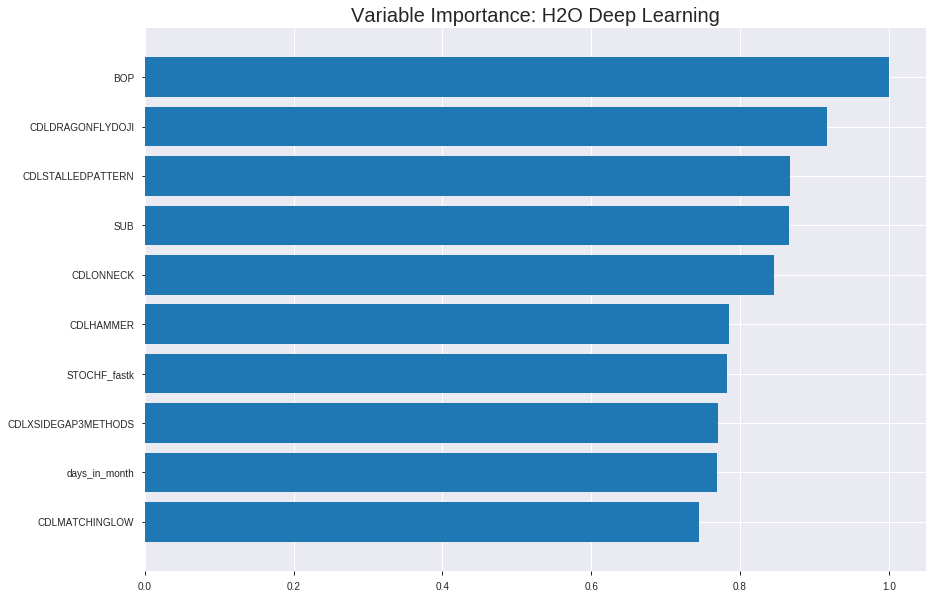

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_131222


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18424593669788633
RMSE: 0.4292387875039793
LogLoss: 0.5449817184096638
Mean Per-Class Error: 0.26451492537313426
AUC: 0.8022710312075984
pr_auc: 0.7667705893226094
Gini: 0.6045420624151967
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3390541064659801: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      486  314  0.3925   (314.0/800.0)
1      114  623  0.1547   (114.0/737.0)
Total  600  937  0.2785   (428.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.339054     0.744325  251
max f2                       0.156048     0.85124   331
max f0point5                 0.435181     0.71676   208
max accuracy                 0.378527     0.732596  234
max precision                0.999466     1         0
max recall                   0.0170022    1         392
max specificity              0.999466     1         0
max absolute_mcc             0.378527     0.474096  234
max min_per_class_accuracy   0.435181     0.729986  208
max mean_per_class_accuracy  0.378527     0.735485  234

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 43.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.9577             1.8248    1.8248             0.875            0.979383   0.875                       0.979383            0.0189959       0.0189959                  82.4796   82.4796
    2        0.0201692                   0.909775           2.08548   1.95093            1                0.932276   0.935484                    0.956589            0.0203528       0.0393487                  108.548   95.0934
    3        0.0305791                   0.887883           1.95514   1.95237            0.9375           0.898098   0.93617                     0.936677            0.0203528       0.0597015                  95.5139   95.2366
    4        0.0403383                   0.866546           1.80742   1.9173             0.866667         0.877418   0.919355                    0.92234             0.0176391       0.0773406                  80.7417   91.7298
    5        0.0500976                   0.842232           2.08548   1.95006            1                0.855218   0.935065                    0.909264            0.0203528       0.0976934                  108.548   95.0061
    6        0.100195                    0.770255           1.7063    1.82818            0.818182         0.802534   0.876623                    0.855899            0.0854817       0.183175                   70.6303   82.8182
    7        0.150293                    0.707609           1.59797   1.75144            0.766234         0.737617   0.839827                    0.816472            0.0800543       0.263229                   59.7966   75.1443
    8        0.20039                     0.658224           1.57088   1.7063             0.753247         0.681516   0.818182                    0.782733            0.0786974       0.341927                   57.0882   70.6303
    9        0.299935                    0.583697           1.44484   1.61953            0.69281          0.620774   0.776573                    0.728981            0.143826        0.485753                   44.4844   61.9528
    10       0.40013                     0.511624           1.25941   1.52935            0.603896         0.550167   0.733333                    0.684205            0.126187        0.61194                    25.9414   52.9353
    11       0.500325                    0.425292           1.25941   1.4753             0.603896         0.468547   0.707412                    0.641017            0.126187        0.738128                   25.9414   47.5295
    12       0.59987                     0.344498           0.954142  1.38881            0.457516         0.384861   0.665944                    0.59851             0.0949796       0.833107                   -4.58581  38.8813
    13       0.700065                    0.266406           0.798983  1.3044             0.383117         0.305447   0.625465                    0.556566            0.0800543       0.913161                   -20.1017  30.4395
    14       0.79961                     0.187081           0.44981   1.19801            0.215686         0.229913   0.574451                    0.5159              0.0447761       0.957938                   -55.019   19.8007
    15       0.899805                    0.0949151          0.311468  1.09929            0.149351         0.141542   0.527115                    0.474215            0.0312076       0.989145                   -68.8532  9.92886
    16       1                           0.000659749        0.108337  1                  0.0519481        0.0475909  0.479506                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20339726218069504
RMSE: 0.4509958560571206
LogLoss: 0.6173920988207928
Mean Per-Class Error: 0.28504421853045714
AUC: 0.7649805769071824
pr_auc: 0.6996287877843168
Gini: 0.5299611538143647
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2698958858406411: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  105  0.4817   (105.0/218.0)
1      23   199  0.1036   (23.0/222.0)
Total  136  304  0.2909   (128.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.269896     0.756654  274
max f2                       0.132894     0.858626  330
max f0point5                 0.44688      0.707381  205
max accuracy                 0.369755     0.715909  240
max precision                0.688198     0.788889  83
max recall                   0.0248064    1         386
max specificity              0.995096     0.995413  0
max absolute_mcc             0.332012     0.449204  257
max min_per_class_accuracy   0.462422     0.692661  197
max mean_per_class_accuracy  0.369755     0.714956  240

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 44.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.978668           0.396396  0.396396           0.2              0.988505  0.2                         0.988505            0.0045045       0.0045045                  -60.3604  -60.3604
    2        0.0204545                   0.93459            1.48649   0.880881           0.75             0.949141  0.444444                    0.97101             0.0135135       0.018018                   48.6486   -11.9119
    3        0.0318182                   0.891654           1.58559   1.13256            0.8              0.907313  0.571429                    0.948261            0.018018        0.036036                   58.5586   13.2561
    4        0.0409091                   0.884742           1.98198   1.32132            1                0.887392  0.666667                    0.934734            0.018018        0.0540541                  98.1982   32.1321
    5        0.05                        0.871997           1.48649   1.35135            0.75             0.880865  0.681818                    0.92494             0.0135135       0.0675676                  48.6486   35.1351
    6        0.1                         0.80142            1.62162   1.48649            0.818182         0.835738  0.75                        0.880339            0.0810811       0.148649                   62.1622   48.6486
    7        0.15                        0.74265            1.53153   1.5015             0.772727         0.764778  0.757576                    0.841818            0.0765766       0.225225                   53.1532   50.1502
    8        0.2                         0.689464           1.71171   1.55405            0.863636         0.711705  0.784091                    0.80929             0.0855856       0.310811                   71.1712   55.4054
    9        0.3                         0.619398           1.3964    1.5015             0.704545         0.646659  0.757576                    0.75508             0.13964         0.45045                    39.6396   50.1502
    10       0.4                         0.546058           1.26126   1.44144            0.636364         0.582106  0.727273                    0.711836            0.126126        0.576577                   26.1261   44.1441
    11       0.5                         0.462547           1.12613   1.37838            0.568182         0.503492  0.695455                    0.670168            0.112613        0.689189                   12.6126   37.8378
    12       0.6                         0.373832           1.17117   1.34384            0.590909         0.416566  0.67803                     0.627901            0.117117        0.806306                   17.1171   34.3844
    13       0.7                         0.26382            0.900901  1.28057            0.454545         0.315923  0.646104                    0.583332            0.0900901       0.896396                   -9.90991  28.0566
    14       0.8                         0.164766           0.540541  1.18806            0.272727         0.211393  0.599432                    0.53684             0.0540541       0.95045                    -45.9459  18.8063
    15       0.9                         0.0842526          0.315315  1.09109            0.159091         0.119827  0.550505                    0.490505            0.0315315       0.981982                   -68.4685  9.10911
    16       1                           0.00716822         0.18018   1                  0.0909091        0.039815  0.504545                    0.445436       


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:12:23  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:12:23  0.068 sec   59115 obs/sec     1         1             1537       0.471745         0.6969              0.108327       0.719676        0.65866            1.17308          0.370852                         0.474136           0.748711              0.100705         0.714863          0.645604             1.18919            0.302273
    2019-08-28 13:12:23  0.339 sec   56300 obs/sec     10        10            15370      0.429239         0.544982            0.261776       0.802271        0.766771           1.8248           0.278465                         0.450996           0.617392              0.186344         0.764981          0.699629             0.396396           0.290909

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
BOP                  1.0                    1.0                  0.031130433263503836
CDLDRAGONFLYDOJI     0.9171180725097656     0.9171180725097656   0.02855028295101853
CDLSTALLEDPATTERN    0.8668804168701172     0.8668804168701172   0.02698636296481357
SUB                  0.8664774298667908     0.8664774298667908   0.026973817804800456
CDLONNECK            0.8453549742698669     0.8453549742698669   0.026316266610479096
---                  ---                    ---                  ---
CDLTHRUSTING         0.4856017827987671     0.4856017827987671   0.015116993892055505
CDLLONGLINE          0.484584778547287      0.484584778547287    0.015085334109076103
day                  0.48254629969596863    0.48254629969596863  0.015021875379236072
CDLGAPSIDESIDEWHITE  0.42777135968208313    0.42777135968208313  0.013316707764621384
CDLHARAMICROSS       0.3994458317756653     0.3994458317756653   0.012434921808477127


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7227272727272728)

('F1', 0.708133971291866)

('auc', 0.7322572593393792)

('logloss', 0.647015302106819)

('mean_per_class_error', 0.2765205091937766)

('rmse', 0.4659868949575058)

('mse', 0.2171437862721375)

deeplearning prediction progress: |███████████████████████████████████████| 100%


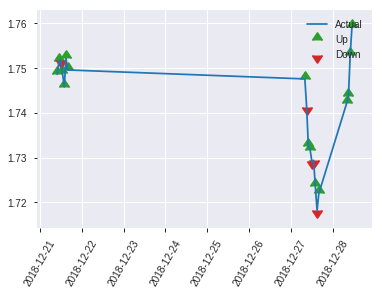


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2171437862721375
RMSE: 0.4659868949575058
LogLoss: 0.647015302106819
Mean Per-Class Error: 0.2765205091937766
AUC: 0.7322572593393792
pr_auc: 0.6465167603807588
Gini: 0.4645145186787585
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4289603166433077: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      85   34   0.2857   (34.0/119.0)
1      27   74   0.2673   (27.0/101.0)
Total  112  108  0.2773   (61.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42896      0.708134  107
max f2                       0.0345213    0.819805  211
max f0point5                 0.42896      0.694184  107
max accuracy                 0.42896      0.722727  107
max precision                0.984891     1         0
max recall                   0.0345213    1         211
max specificity              0.984891     1         0
max absolute_mcc             0.42896      0.445534  107
max min_per_class_accuracy   0.432826     0.714286  106
max mean_per_class_accuracy  0.42896      0.723479  107

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 41.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.981328           2.17822   2.17822            1                0.982939   1                           0.982939            0.029703        0.029703                   117.822   117.822
    2        0.0227273                   0.928234           1.08911   1.74257            0.5              0.959392   0.8                         0.973521            0.00990099      0.039604                   8.91089   74.2574
    3        0.0318182                   0.876167           0         1.2447             0                0.893661   0.571429                    0.950704            0               0.039604                   -100      24.4696
    4        0.0409091                   0.841533           2.17822   1.45215            1                0.863231   0.666667                    0.931265            0.019802        0.0594059                  117.822   45.2145
    5        0.05                        0.830591           0         1.18812            0                0.836704   0.545455                    0.914072            0               0.0594059                  -100      18.8119
    6        0.1                         0.785153           1.78218   1.48515            0.818182         0.81518    0.681818                    0.864626            0.0891089       0.148515                   78.2178   48.5149
    7        0.15                        0.678943           1.38614   1.45215            0.636364         0.749391   0.666667                    0.826214            0.0693069       0.217822                   38.6139   45.2145
    8        0.2                         0.623083           1.78218   1.53465            0.818182         0.650763   0.704545                    0.782352            0.0891089       0.306931                   78.2178   53.4653
    9        0.3                         0.547436           1.38614   1.48515            0.636364         0.582873   0.681818                    0.715859            0.138614        0.445545                   38.6139   48.5149
    10       0.4                         0.485146           1.58416   1.5099             0.727273         0.513776   0.693182                    0.665338            0.158416        0.60396                    58.4158   50.9901
    11       0.5                         0.421786           1.28713   1.46535            0.590909         0.458032   0.672727                    0.623877            0.128713        0.732673                   28.7129   46.5347
    12       0.6                         0.344173           0.693069  1.33663            0.318182         0.38615    0.613636                    0.584256            0.0693069       0.80198                    -30.6931  33.6634
    13       0.7                         0.24741            0.594059  1.23055            0.272727         0.301647   0.564935                    0.543883            0.0594059       0.861386                   -40.5941  23.0552
    14       0.8                         0.156507           0.49505   1.13861            0.227273         0.194784   0.522727                    0.500246            0.049505        0.910891                   -50.495   13.8614
    15       0.9                         0.0819848          0.39604   1.05611            0.181818         0.113118   0.484848                    0.457232            0.039604        0.950495                   -60.396   5.61056
    16       1                           0.0085676          0.49505   1                  0.227273         0.0459229  0.459091                   

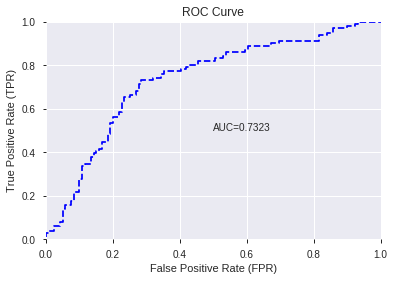

This function is available for GLM models only


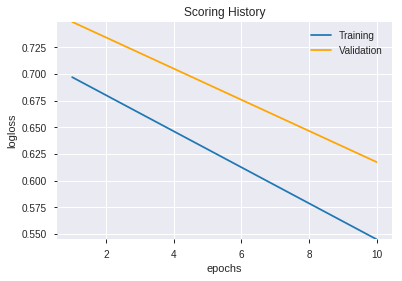

--2019-08-28 13:19:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_131222',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_131222',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_50_sid_b106'

['BOP',
 'CDLDRAGONFLYDOJI',
 'CDLSTALLEDPATTERN',
 'SUB',
 'CDLONNECK',
 'CDLHAMMER',
 'STOCHF_fastk',
 'CDLXSIDEGAP3METHODS',
 'days_in_month',
 'CDLMATCHINGLOW',
 'CDLTASUKIGAP',
 'CDL3LINESTRIKE',
 'CEIL',
 'CDLMARUBOZU',
 'FLOOR',
 'CDLIDENTICAL3CROWS',
 'CDLHANGINGMAN',
 'STOCHRSI_fastk',
 'CDLADVANCEBLOCK',
 'CDL3INSIDE',
 'CDLDARKCLOUDCOVER',
 'DIV',
 'CDLGRAVESTONEDOJI',
 'CDLEVENINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLCLOSINGMARUBOZU',
 'CDLHOMINGPIGEON',
 'CDLSHOOTINGSTAR',
 'HT_DCPERIOD',
 'is_month_end',
 'CDLHIKKAKEMOD',
 'CDLPIERCING',
 'CDL3WHITESOLDIERS',
 'CDLLADDERBOTTOM',
 'CDLEVENINGDOJISTAR',
 'CDLENGULFING',
 'is_month_start',
 'CDLINVERTEDHAMMER',
 'CDLRISEFALL3METHODS',
 'CDLINNECK',
 'CDLTAKURI',
 'TRANGE',
 'HT_TRENDMODE',
 'CDLMORNINGSTAR',
 'hour',
 'CDLTHRUSTING',
 'CDLLONGLINE',
 'day',
 'CDLGAPSIDESIDEWHITE',
 'CDLHARAMICROSS']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_131947_model_1  0.705383  0.647174              0.335053  0.471329  0.222151

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.509056           1.000000    0.154341
1    CDLCLOSINGMARUBOZU             0.252502           0.496020    0.076556
2             CDLHAMMER             0.176169           0.346070    0.053413
3                   SUB             0.164105           0.322371    0.049755
4                  hour             0.135919           0.267002    0.041209
5                   DIV             0.133221           0.261703    0.040391
6          STOCHF_fastk             0.123607           0.242816    0.037477
7     CDLGRAVESTONEDOJI             0.096785           0.190127    0.029344
8          CDLENGULFING             0.088610           0.174067    0.026866
9          CDLTHRUSTING             0.083830           0.164678    0.025417
10           CDL3INSIDE             0.079808           0.156776    0.024197
11       CDLHARAMICROSS             0.076876           0.151017    0.023308
12    CDLDARKCLOUDCOVER             0.072505           0.142431    0.021983
13        CDLHANGINGMAN             0.071400           0.140261    0.021648
14    CDLSTALLEDPATTERN             0.068884           0.135317    0.020885
15   CDLIDENTICAL3CROWS             0.064230           0.126176    0.019474
16       STOCHRSI_fastk             0.063047           0.123850    0.019115
17       CDL3LINESTRIKE             0.060114           0.118088    0.018226
18       CDLEVENINGSTAR             0.057344           0.112647    0.017386
19      CDLLADDERBOTTOM             0.055315           0.108662    0.016771
20        days_in_month             0.055012           0.108068    0.016679
21          CDLPIERCING             0.049319           0.096882    0.014953
22          CDLLONGLINE             0.047989           0.094270    0.014550
23      CDLADVANCEBLOCK             0.046370           0.091090    0.014059
24       is_month_start             0.045458           0.089298    0.013782
25   CDLMORNINGDOJISTAR             0.044146           0.086721    0.013385
26     CDLDRAGONFLYDOJI             0.041115           0.080767    0.012466
27        CDLHIKKAKEMOD             0.040861           0.080268    0.012389
28               TRANGE             0.040330           0.079225    0.012228
29  CDLGAPSIDESIDEWHITE             0.039749           0.078083    0.012051
30                  day             0.039689           0.077966    0.012033
31         is_month_end             0.038461           0.075553    0.011661
32            CDLTAKURI             0.034972           0.068701    0.010603
33  CDLRISEFALL3METHODS             0.033188           0.065196    0.010062
34            CDLINNECK             0.031853           0.062573    0.009658
35            CDLONNECK             0.031798           0.062464    0.009641
36    CDL3WHITESOLDIERS             0.030999           0.060896    0.009399
37   CDLEVENINGDOJISTAR             0.028417           0.055822    0.008616
38       CDLMATCHINGLOW             0.026439           0.051938    0.008016
39       CDLMORNINGSTAR             0.020062           0.039411    0.006083
40  CDLXSIDEGAP3METHODS             0.018423           0.036190    0.005586
41          CDLMARUBOZU             0.016637           0.032682    0.005044
42    CDLINVERTEDHAMMER             0.014605           0.028690    0.004428
43      CDLSHOOTINGSTAR             0.011053           0.021713    0.003351
44         CDLTASUKIGAP             0.010389           0.020409    0.003150
45      CDLHOMINGPIGEON             0.010112           0.019863    0.003066
46         HT_TRENDMODE             0.009773           0.019197    0.002963
47                 CEIL             0.002714           0.005332    0.000823
48                FLOOR             0.002678           0.005261    0.000812
49          HT_DCPERIOD             0.002316           0.004550    0.000702

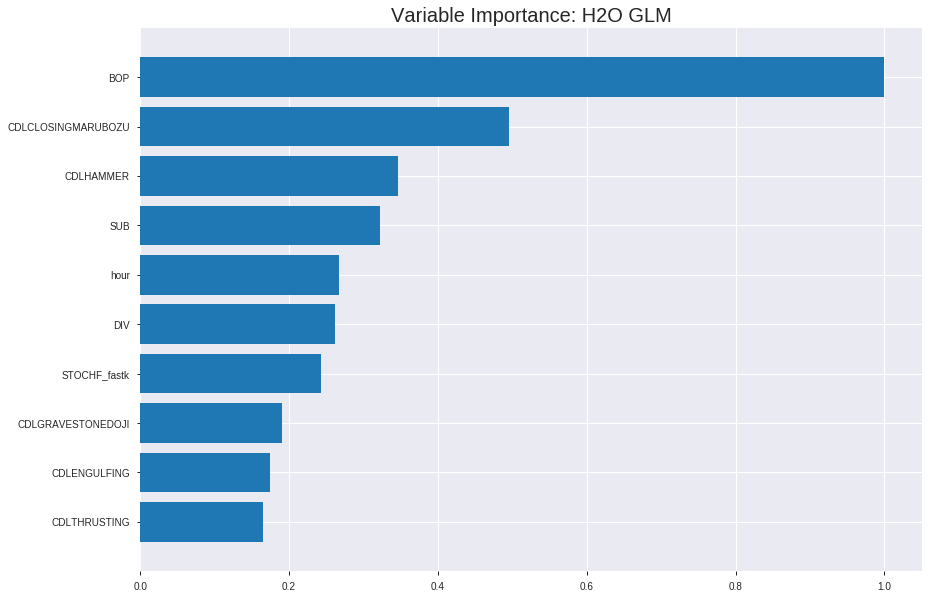

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_131947_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18856591080828716
RMSE: 0.4342417653891518
LogLoss: 0.556221631753524
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2128.1514062818787
Residual deviance: 1709.8252960103327
AIC: 1811.8252960103327
AUC: 0.7890323948439619
pr_auc: 0.751654886795708
Gini: 0.5780647896879239
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39045072892424676: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      426  374   0.4675   (374.0/800.0)
1      97   640   0.1316   (97.0/737.0)
Total  523  1014  0.3064   (471.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390451     0.731011  251
max f2                       0.257382     0.85026   314
max f0point5                 0.536848     0.715777  173
max accuracy                 0.529541     0.720234  177
max precision                0.948636     1         0
max recall                   0.0991955    1         376
max specificity              0.948636     1         0
max absolute_mcc             0.529541     0.43911   177
max min_per_class_accuracy   0.498664     0.708277  195
max mean_per_class_accuracy  0.529541     0.718107  177

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 47.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104099                   0.897644           1.95514   1.95514            0.9375           0.915223  0.9375                      0.915223            0.0203528       0.0203528                  95.5139    95.5139
    2        0.0201692                   0.874731           1.52935   1.74911            0.733333         0.886149  0.83871                     0.901155            0.0149254       0.0352782                  52.9353    74.9114
    3        0.0305791                   0.862379           1.8248    1.77488            0.875            0.867474  0.851064                    0.889689            0.0189959       0.0542741                  82.4796    77.4878
    4        0.0403383                   0.853555           1.80742   1.78275            0.866667         0.857409  0.854839                    0.881879            0.0176391       0.0719132                  80.7417    78.275
    5        0.0500976                   0.831523           1.80742   1.78756            0.866667         0.845172  0.857143                    0.874729            0.0176391       0.0895522                  80.7417    78.7556
    6        0.100195                    0.750428           1.81464   1.8011             0.87013          0.789146  0.863636                    0.831937            0.0909091       0.180461                   81.464     80.1098
    7        0.150293                    0.70539            1.65213   1.75144            0.792208         0.726806  0.839827                    0.796894            0.082768        0.263229                   65.2135    75.1443
    8        0.20039                     0.669607           1.46255   1.67922            0.701299         0.687896  0.805195                    0.769644            0.07327         0.336499                   46.2546    67.9219
    9        0.299935                    0.611656           1.44484   1.60143            0.69281          0.638998  0.767896                    0.726284            0.143826        0.480326                   44.4844    60.1433
    10       0.40013                     0.552296           1.36775   1.54292            0.655844         0.581093  0.739837                    0.689928            0.137042        0.617368                   36.7751    54.2917
    11       0.500325                    0.491647           1.01566   1.43733            0.487013         0.521274  0.689207                    0.656153            0.101764        0.719132                   1.56567    43.7328
    12       0.59987                     0.419928           0.995034  1.36393            0.477124         0.453914  0.654013                    0.622593            0.0990502       0.818182                   -0.496626  36.3932
    13       0.700065                    0.358542           0.785441  1.28114            0.376623         0.392375  0.614312                    0.589643            0.0786974       0.896879                   -21.4559   28.1137
    14       0.79961                     0.286359           0.599746  1.19631            0.287582         0.322441  0.573637                    0.556379            0.0597015       0.956581                   -40.0254   19.631
    15       0.899805                    0.174679           0.311468  1.09778            0.149351         0.237055  0.526392                    0.520822            0.0312076       0.987788                   -68.8532   9.77807
    16       1                           0.0200866          0.121879  1                  0.0584416        0.108467  0.479506                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19648900758294457
RMSE: 0.44327080614782716
LogLoss: 0.5781043654270921
Null degrees of freedom: 439
Residual degrees of freedom: 389
Null deviance: 611.0374769186825
Residual deviance: 508.73184157584103
AIC: 610.731841575841
AUC: 0.7680593437474171
pr_auc: 0.7130422051518472
Gini: 0.5361186874948343
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4572664947329277: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      144  74   0.3394   (74.0/218.0)
1      41   181  0.1847   (41.0/222.0)
Total  185  255  0.2614   (115.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457266     0.75891   229
max f2                       0.226489     0.853755  340
max f0point5                 0.457266     0.728663  229
max accuracy                 0.457266     0.738636  229
max precision                0.927655     1         0
max recall                   0.0995645    1         383
max specificity              0.927655     1         0
max absolute_mcc             0.457266     0.481985  229
max min_per_class_accuracy   0.50876      0.706422  201
max mean_per_class_accuracy  0.457266     0.737933  229

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 48.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.891291           1.18919   1.18919            0.6              0.907273  0.6                         0.907273            0.0135135       0.0135135                  18.9189   18.9189
    2        0.0204545                   0.876391           1.48649   1.32132            0.75             0.880069  0.666667                    0.895182            0.0135135       0.027027                   48.6486   32.1321
    3        0.0318182                   0.856398           1.98198   1.55727            1                0.869829  0.785714                    0.886127            0.0225225       0.0495495                  98.1982   55.7272
    4        0.0409091                   0.84365            1.48649   1.54154            0.75             0.85257   0.777778                    0.87867             0.0135135       0.0630631                  48.6486   54.1542
    5        0.05                        0.833474           1.98198   1.62162            1                0.838959  0.818182                    0.87145             0.018018        0.0810811                  98.1982   62.1622
    6        0.1                         0.765012           1.44144   1.53153            0.727273         0.798643  0.772727                    0.835046            0.0720721       0.153153                   44.1441   53.1532
    7        0.15                        0.723279           1.35135   1.47147            0.681818         0.743689  0.742424                    0.804594            0.0675676       0.220721                   35.1351   47.1471
    8        0.2                         0.683735           1.53153   1.48649            0.772727         0.701019  0.75                        0.7787              0.0765766       0.297297                   53.1532   48.6486
    9        0.3                         0.612819           1.53153   1.5015             0.772727         0.643299  0.757576                    0.733566            0.153153        0.45045                    53.1532   50.1502
    10       0.4                         0.569767           1.26126   1.44144            0.636364         0.591543  0.727273                    0.69806             0.126126        0.576577                   26.1261   44.1441
    11       0.5                         0.50876            1.26126   1.40541            0.636364         0.543853  0.709091                    0.667219            0.126126        0.702703                   26.1261   40.5405
    12       0.6                         0.446616           1.21622   1.37387            0.613636         0.475104  0.693182                    0.6352              0.121622        0.824324                   21.6216   37.3874
    13       0.7                         0.363398           0.720721  1.28057            0.363636         0.401409  0.646104                    0.601801            0.0720721       0.896396                   -27.9279  28.0566
    14       0.8                         0.268832           0.45045   1.1768             0.227273         0.316744  0.59375                     0.566169            0.045045        0.941441                   -54.955   17.6802
    15       0.9                         0.170143           0.36036   1.08609            0.181818         0.227122  0.54798                     0.528497            0.036036        0.977477                   -63.964   8.60861
    16       1                           0.04101            0.225225  1                  0.113636         0.105909  0.504545                    0.486238         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 13:19:47  0.000 sec   2            21        51            1.36914           1.37265
    2019-08-28 13:19:47  0.013 sec   4            13        51            1.36056           1.36376
    2019-08-28 13:19:47  0.028 sec   6            8.2       51            1.34793           1.35074
    2019-08-28 13:19:47  0.039 sec   8            5.1       51            1.33014           1.33251
    2019-08-28 13:19:47  0.053 sec   10           3.1       51            1.30668           1.30873
    2019-08-28 13:19:47  0.065 sec   12           2         51            1.27817           1.28036
    2019-08-28 13:19:47  0.077 sec   14           1.2       51            1.24668           1.24997
    2019-08-28 13:19:47  0.086 sec   16           0.75      51            1.21509           1.22093
    2019-08-28 13:19:48  0.098 sec   18           0.47      51            1.18602           1.19621
    2019-08-28 13:19:48  0.115 sec   20           0.29      51            1.16108           1.17746
    2019-08-28 13:19:48  0.127 sec   22           0.18      51            1.14074           1.16498
    2019-08-28 13:19:48  0.136 sec   24           0.11      51            1.12471           1.15819
    2019-08-28 13:19:48  0.143 sec   26           0.07      51            1.11244           1.15621
    2019-08-28 13:19:48  0.152 sec   28           0.043     51            1.10339           1.15825
    2019-08-28 13:19:48  0.169 sec   30           0.027     51            1.09707           1.16356
    2019-08-28 13:19:48  0.182 sec   32           0.017     51            1.09293           1.17141
    2019-08-28 13:19:48  0.194 sec   34           0.01      51            1.09035           1.18101
    2019-08-28 13:19:48  0.205 sec   36           0.0064    51            1.08871           1.19165

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6818181818181818)

('F1', 0.6779661016949152)

('auc', 0.7053831433563524)

('logloss', 0.6471738156599806)

('mean_per_class_error', 0.32107496463932106)

('rmse', 0.47132908231796)

('mse', 0.22215110383869033)

glm prediction progress: |████████████████████████████████████████████████| 100%


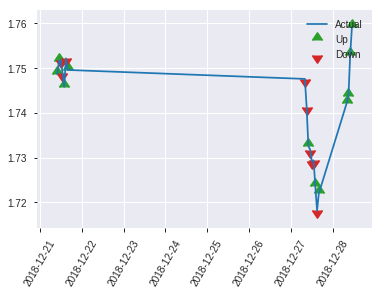


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22215110383869033
RMSE: 0.47132908231796
LogLoss: 0.6471738156599806
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 303.8782617497692
Residual deviance: 284.75647889039146
AIC: 386.75647889039146
AUC: 0.7053831433563524
pr_auc: 0.6194147174168805
Gini: 0.4107662867127049
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39898735946653874: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   55   0.4622   (55.0/119.0)
1      21   80   0.2079   (21.0/101.0)
Total  85   135  0.3455   (76.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398987     0.677966  134
max f2                       0.0968756    0.813008  210
max f0point5                 0.528388     0.655914  90
max accuracy                 0.528388     0.681818  90
max precision                0.935394     1         0
max recall                   0.0142595    1         219
max specificity              0.935394     1         0
max absolute_mcc             0.508249     0.358447  98
max min_per_class_accuracy   0.49018      0.672269  106
max mean_per_class_accuracy  0.508249     0.678925  98

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 45.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.865822           1.45215   1.45215            0.666667         0.909669   0.666667                    0.909669            0.019802        0.019802                   45.2145   45.2145
    2        0.0227273                   0.845              0         0.871287           0                0.85425    0.4                         0.887501            0               0.019802                   -100      -12.8713
    3        0.0318182                   0.822518           2.17822   1.2447             1                0.837719   0.571429                    0.873278            0.019802        0.039604                   117.822   24.4696
    4        0.0409091                   0.810615           2.17822   1.45215            1                0.811504   0.666667                    0.85955             0.019802        0.0594059                  117.822   45.2145
    5        0.05                        0.809505           1.08911   1.38614            0.5              0.810273   0.636364                    0.850591            0.00990099      0.0693069                  8.91089   38.6139
    6        0.1                         0.726131           1.38614   1.38614            0.636364         0.776062   0.636364                    0.813326            0.0693069       0.138614                   38.6139   38.6139
    7        0.15                        0.668647           1.58416   1.45215            0.727273         0.703864   0.666667                    0.776839            0.0792079       0.217822                   58.4158   45.2145
    8        0.2                         0.630704           1.58416   1.48515            0.727273         0.648115   0.681818                    0.744658            0.0792079       0.29703                    58.4158   48.5149
    9        0.3                         0.5805             1.58416   1.51815            0.727273         0.606543   0.69697                     0.69862             0.158416        0.455446                   58.4158   51.8152
    10       0.4                         0.529667           1.18812   1.43564            0.545455         0.559068   0.659091                    0.663732            0.118812        0.574257                   18.8119   43.5644
    11       0.5                         0.481114           1.08911   1.36634            0.5              0.507892   0.627273                    0.632564            0.108911        0.683168                   8.91089   36.6337
    12       0.6                         0.405725           0.792079  1.27063            0.363636         0.438784   0.583333                    0.600267            0.0792079       0.762376                   -20.7921  27.0627
    13       0.7                         0.344107           0.594059  1.17397            0.272727         0.37586    0.538961                    0.568209            0.0594059       0.821782                   -40.5941  17.3975
    14       0.8                         0.253583           0.891089  1.13861            0.409091         0.296547   0.522727                    0.534251            0.0891089       0.910891                   -10.8911  13.8614
    15       0.9                         0.147055           0.39604   1.05611            0.181818         0.209026   0.484848                    0.498115            0.039604        0.950495                   -60.396   5.61056
    16       1                           0.0142595          0.49505   1                  0.227273         0.0980445  0.459091                  

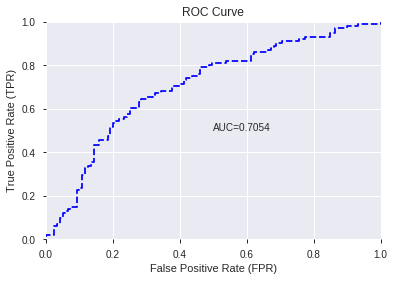

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


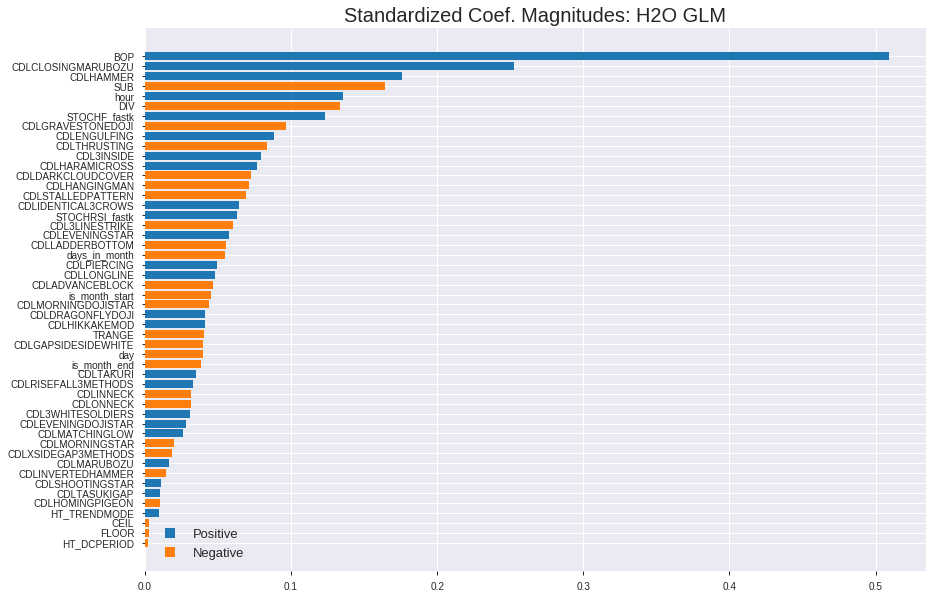

'log_likelihood'
--2019-08-28 13:19:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.101.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.101.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_131947_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_131947_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'SUB',
 'hour',
 'DIV',
 'STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'CDLENGULFING',
 'CDLTHRUSTING',
 'CDL3INSIDE',
 'CDLHARAMICROSS',
 'CDLDARKCLOUDCOVER',
 'CDLHANGINGMAN',
 'CDLSTALLEDPATTERN',
 'CDLIDENTICAL3CROWS',
 'STOCHRSI_fastk',
 'CDL3LINESTRIKE',
 'CDLEVENINGSTAR',
 'CDLLADDERBOTTOM',
 'days_in_month',
 'CDLPIERCING',
 'CDLLONGLINE',
 'CDLADVANCEBLOCK',
 'is_month_start',
 'CDLMORNINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLHIKKAKEMOD',
 'TRANGE',
 'CDLGAPSIDESIDEWHITE',
 'day',
 'is_month_end',
 'CDLTAKURI',
 'CDLRISEFALL3METHODS',
 'CDLINNECK',
 'CDLONNECK',
 'CDL3WHITESOLDIERS',
 'CDLEVENINGDOJISTAR',
 'CDLMATCHINGLOW',
 'CDLMORNINGSTAR',
 'CDLXSIDEGAP3METHODS',
 'CDLMARUBOZU',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLTASUKIGAP',
 'CDLHOMINGPIGEON',
 'HT_TRENDMODE',
 'CEIL',
 'FLOOR',
 'HT_DCPERIOD']

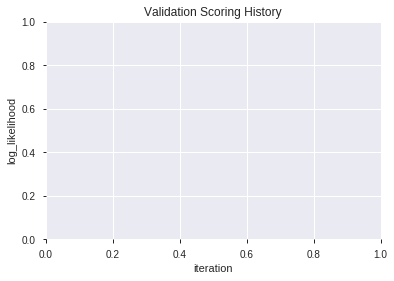

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_132002_model_1  0.731508  0.608110              0.331766  0.457506  0.209312
1  XGBoost_grid_1_AutoML_20190828_132002_model_2  0.728014  0.607392              0.324403  0.458550  0.210268
2               XGBoost_1_AutoML_20190828_132002  0.723771  0.617723              0.335968  0.462721  0.214111
3               XGBoost_3_AutoML_20190828_132002  0.722439  0.613134              0.309094  0.460271  0.211850
4  XGBoost_grid_1_AutoML_20190828_132002_model_6  0.720775  0.613994              0.317955  0.460827  0.212362
5  XGBoost_grid_1_AutoML_20190828_132002_model_4  0.715908  0.617393              0.326358  0.463353  0.214696
6  XGBoost_grid_1_AutoML_20190828_132002_model_7  0.715284  0.626271              0.341376  0.466094  0.217244
7               XGBoost_2_AutoML_20190828_132002  0.710292  0.621279              0.351277  0.465201  0.216412
8  XGBoost_grid_1_AutoML_20190828_132002_model_5  0.709626  0.634349              0.320201  0.469963  0.220866
9  XGBoost_grid_1_AutoML_20190828_132002_model_3  0.708711  0.621445              0.324112  0.465701  0.216878

variable  relative_importance  scaled_importance  percentage
0                  BOP          2997.033447           1.000000    0.427475
1               TRANGE           742.158875           0.247631    0.105856
2         STOCHF_fastk           706.943787           0.235881    0.100833
3       STOCHRSI_fastk           391.691528           0.130693    0.055868
4          HT_DCPERIOD           376.817627           0.125730    0.053747
5                 hour           369.971710           0.123446    0.052770
6                  DIV           349.848541           0.116732    0.049900
7                  SUB           291.902069           0.097397    0.041635
8   CDLCLOSINGMARUBOZU           262.639618           0.087633    0.037461
9            CDLHAMMER           188.102936           0.062763    0.026830
10                 day           155.323456           0.051826    0.022154
11       days_in_month            54.338646           0.018131    0.007750
12   CDLGRAVESTONEDOJI            34.354717           0.011463    0.004900
13         CDLLONGLINE            28.454914           0.009494    0.004059
14        HT_TRENDMODE            25.683384           0.008570    0.003663
15    CDLDRAGONFLYDOJI            18.851799           0.006290    0.002689
16        CDLENGULFING            12.280169           0.004097    0.001752
17           CDLTAKURI             4.614300           0.001540    0.000658

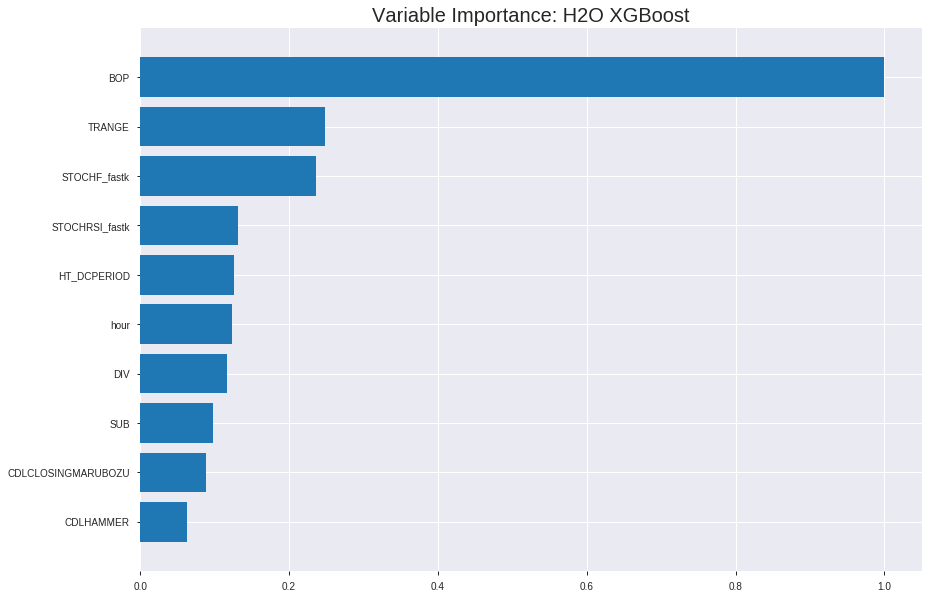

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_132002_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15259306440231607
RMSE: 0.39063162237882904
LogLoss: 0.4702598133458212
Mean Per-Class Error: 0.21035362957937576
AUC: 0.8732895183175035
pr_auc: 0.8634267890832901
Gini: 0.7465790366350069
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40223707258701324: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      510  290  0.3625   (290.0/800.0)
1      69   668  0.0936   (69.0/737.0)
Total  579  958  0.2336   (359.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402237     0.788201  240
max f2                       0.265671     0.86696   295
max f0point5                 0.624623     0.791444  135
max accuracy                 0.531814     0.7892    189
max precision                0.928461     1         0
max recall                   0.0809129    1         377
max specificity              0.928461     1         0
max absolute_mcc             0.531814     0.578807  189
max min_per_class_accuracy   0.5373       0.782904  185
max mean_per_class_accuracy  0.531814     0.789646  189

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 48.03 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.904088           2.08548    2.08548            1                0.915649   1                           0.915649            0.0217096       0.0217096                  108.548   108.548
    2        0.0201692                   0.884688           2.08548    2.08548            1                0.894503   1                           0.905417            0.0203528       0.0420624                  108.548   108.548
    3        0.0305791                   0.864159           2.08548    2.08548            1                0.8717     1                           0.893939            0.0217096       0.063772                   108.548   108.548
    4        0.0403383                   0.852131           2.08548    2.08548            1                0.857589   1                           0.885144            0.0203528       0.0841248                  108.548   108.548
    5        0.0500976                   0.836961           2.08548    2.08548            1                0.846668   1                           0.877649            0.0203528       0.104478                   108.548   108.548
    6        0.100195                    0.791399           2.03131    2.0584             0.974026         0.812217   0.987013                    0.844933            0.101764        0.206242                   103.131   105.84
    7        0.150293                    0.746107           1.76047    1.95909            0.844156         0.770609   0.939394                    0.820158            0.0881954       0.294437                   76.0472   95.9089
    8        0.20039                     0.706807           1.89589    1.94329            0.909091         0.724669   0.931818                    0.796286            0.0949796       0.389417                   89.5892   94.329
    9        0.299935                    0.645611           1.59478    1.82762            0.764706         0.678329   0.876356                    0.757138            0.158752        0.548168                   59.478    82.7624
    10       0.40013                     0.587743           1.32712    1.7023             0.636364         0.616597   0.81626                     0.721945            0.132972        0.68114                    32.7125   70.2296
    11       0.500325                    0.530355           1.1917     1.60004            0.571429         0.560447   0.76723                     0.689604            0.119403        0.800543                   19.1704   60.0044
    12       0.59987                     0.434488           0.831467   1.4725             0.398693         0.489612   0.706074                    0.656416            0.082768        0.883311                   -16.8533  47.2504
    13       0.700065                    0.314087           0.568768   1.34316            0.272727         0.373602   0.644052                    0.615939            0.0569878       0.940299                   -43.1232  34.3159
    14       0.79961                     0.213487           0.408918   1.22685            0.196078         0.258018   0.588283                    0.571381            0.0407056       0.981004                   -59.1082  22.6854
    15       0.899805                    0.107856           0.162505   1.10834            0.0779221        0.161507   0.531453                    0.525741            0.0162822       0.997286                   -83.7495  10.8336
    16       1                           0.0322981          0.0270842  1                  0.012987         0.0721213  0.479506   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18102116552406217
RMSE: 0.4254658218048333
LogLoss: 0.5428062481749906
Mean Per-Class Error: 0.241838168443673
AUC: 0.7992499380114059
pr_auc: 0.7610400045134833
Gini: 0.5984998760228117
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4363827407360077: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      142  76   0.3486   (76.0/218.0)
1      30   192  0.1351   (30.0/222.0)
Total  172  268  0.2409   (106.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436383     0.783673  241
max f2                       0.109799     0.856245  349
max f0point5                 0.525644     0.754039  199
max accuracy                 0.445345     0.759091  239
max precision                0.920998     1         0
max recall                   0.0544212    1         387
max specificity              0.920998     1         0
max absolute_mcc             0.436383     0.528963  241
max min_per_class_accuracy   0.527212     0.747706  197
max mean_per_class_accuracy  0.445345     0.758162  239

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 47.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.897327           1.98198   1.98198            1                0.90474    1                           0.90474             0.0225225       0.0225225                  98.1982   98.1982
    2        0.0204545                   0.879411           1.48649   1.76176            0.75             0.887737   0.888889                    0.897183            0.0135135       0.036036                   48.6486   76.1762
    3        0.0318182                   0.848665           1.58559   1.69884            0.8              0.868842   0.857143                    0.887061            0.018018        0.0540541                  58.5586   69.8842
    4        0.0409091                   0.84093            1.48649   1.65165            0.75             0.843254   0.833333                    0.877326            0.0135135       0.0675676                  48.6486   65.1652
    5        0.05                        0.829153           1.48649   1.62162            0.75             0.837741   0.818182                    0.870129            0.0135135       0.0810811                  48.6486   62.1622
    6        0.1                         0.779657           1.53153   1.57658            0.772727         0.80603    0.795455                    0.838079            0.0765766       0.157658                   53.1532   57.6577
    7        0.15                        0.738878           1.8018    1.65165            0.909091         0.763051   0.833333                    0.81307             0.0900901       0.247748                   80.1802   65.1652
    8        0.2                         0.708741           1.26126   1.55405            0.636364         0.72604    0.784091                    0.791313            0.0630631       0.310811                   26.1261   55.4054
    9        0.3                         0.654073           1.62162   1.57658            0.818182         0.680897   0.795455                    0.754508            0.162162        0.472973                   62.1622   57.6577
    10       0.4                         0.596177           1.17117   1.47523            0.590909         0.626955   0.744318                    0.722619            0.117117        0.59009                    17.1171   47.5225
    11       0.5                         0.528214           1.53153   1.48649            0.772727         0.561262   0.75                        0.690348            0.153153        0.743243                   53.1532   48.6486
    12       0.6                         0.447592           1.08108   1.41892            0.545455         0.493294   0.715909                    0.657506            0.108108        0.851351                   8.10811   41.8919
    13       0.7                         0.279131           0.540541  1.29344            0.272727         0.350633   0.652597                    0.613667            0.0540541       0.905405                   -45.9459  29.3436
    14       0.8                         0.205984           0.45045   1.18806            0.227273         0.240707   0.599432                    0.567047            0.045045        0.95045                    -54.955   18.8063
    15       0.9                         0.0896631          0.36036   1.0961             0.181818         0.147736   0.55303                     0.520457            0.036036        0.986486                   -63.964   9.60961
    16       1                           0.0275633          0.135135  1                  0.0681818        0.0629524  0.504545                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:20:07  0.020 sec   0                  0.5              0.693147            0.5             0                  1                0.520494                         0.5                0.693147              0.5               0                    1                  0.495455
    2019-08-28 13:20:07  0.102 sec   5                  0.468907         0.632406            0.835272        0.793712           2.08548          0.260247                         0.471816           0.637927              0.790716          0.750372             1.98198            0.245455
    2019-08-28 13:20:07  0.159 sec   10                 0.448141         0.592332            0.838435        0.797166           2.08548          0.248536                         0.453875           0.603002              0.795758          0.75326              1.98198            0.252273
    2019-08-28 13:20:07  0.212 sec   15                 0.433641         0.563674            0.843296        0.817688           2.08548          0.25244                          0.443973           0.58297               0.793516          0.768184             1.98198            0.254545
    2019-08-28 13:20:07  0.272 sec   20                 0.423277         0.542464            0.847642        0.831904           2.08548          0.249187                         0.436806           0.568007              0.795293          0.768903             1.98198            0.245455
    2019-08-28 13:20:07  0.329 sec   25                 0.415303         0.525594            0.85275         0.839728           2.08548          0.244632                         0.433574           0.560593              0.79303           0.764283             1.98198            0.245455
    2019-08-28 13:20:07  0.385 sec   30                 0.40981          0.513453            0.855979        0.843678           2.08548          0.249837                         0.430701           0.55418               0.79458           0.758512             1.98198            0.247727
    2019-08-28 13:20:07  0.435 sec   35                 0.405357         0.503528            0.858914        0.846813           2.08548          0.245934                         0.428805           0.549933              0.795345          0.75784              1.98198            0.240909
    2019-08-28 13:20:07  0.485 sec   40                 0.402253         0.496243            0.860451        0.84908            2.08548          0.244632                         0.427958           0.547678              0.794363          0.757705             1.98198            0.240909
    2019-08-28 13:20:07  0.529 sec   45                 0.399886         0.490612            0.862177        0.850323           2.08548          0.24203                          0.426698           0.545075              0.797638          0.759132             1.98198            0.245455
    2019-08-28 13:20:07  0.575 sec   50                 0.397287         0.484693            0.86522         0.855565           2.08548          0.240729                         0.426143           0.543766              0.798175          0.761385             1.98198            0.238636
    2019-08-28 13:20:07  0.622 sec   55                 0.395216         0.480008            0.867188        0.858157           2.08548          0.234223                         0.425626           0.54292               0.799581          0

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
BOP                 2997.03                1                    0.427475
TRANGE              742.159                0.247631             0.105856
STOCHF_fastk        706.944                0.235881             0.100833
STOCHRSI_fastk      391.692                0.130693             0.055868
HT_DCPERIOD         376.818                0.12573              0.0537465
hour                369.972                0.123446             0.0527701
DIV                 349.849                0.116732             0.0498999
SUB                 291.902                0.097397             0.0416348
CDLCLOSINGMARUBOZU  262.64                 0.0876332            0.037461
CDLHAMMER           188.103                0.062763             0.0268296
day                 155.323                0.0518257            0.0221542
days_in_month       54.3386                0.0181308            0.00775047
CDLGRAVESTONEDOJI   34.3547                0.0114629            0.00490011
CDLLONGLINE         28.4549                0.00949436           0.0040586
HT_TRENDMODE        25.6834                0.0085696            0.00366329
CDLDRAGONFLYDOJI    18.8518                0.00629015           0.00268888
CDLENGULFING        12.2802                0.00409744           0.00175155
CDLTAKURI           4.6143                 0.00153962           0.00065815

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6954545454545454)

('F1', 0.7003891050583656)

('auc', 0.7315084449621433)

('logloss', 0.6081102695630806)

('mean_per_class_error', 0.3062234794908062)

('rmse', 0.45750599882547965)

('mse', 0.2093117389612998)

xgboost prediction progress: |████████████████████████████████████████████| 100%


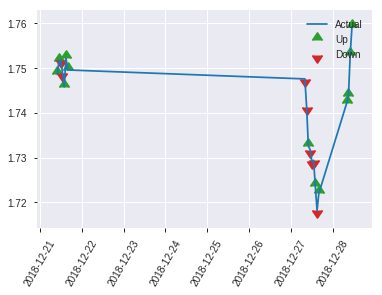


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2093117389612998
RMSE: 0.45750599882547965
LogLoss: 0.6081102695630806
Mean Per-Class Error: 0.3062234794908062
AUC: 0.7315084449621433
pr_auc: 0.6641813455151161
Gini: 0.4630168899242866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2627909183502197: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   66   0.5546   (66.0/119.0)
1      11   90   0.1089   (11.0/101.0)
Total  64   156  0.35     (77.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.262791     0.700389  154
max f2                       0.121108     0.823529  189
max f0point5                 0.54603      0.667976  100
max accuracy                 0.54603      0.695455  100
max precision                0.881804     1         0
max recall                   0.0457699    1         216
max specificity              0.881804     1         0
max absolute_mcc             0.54603      0.387279  100
max min_per_class_accuracy   0.537394     0.683168  104
max mean_per_class_accuracy  0.54603      0.693777  100

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 45.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.843375           1.45215   1.45215            0.666667         0.858615   0.666667                    0.858615            0.019802        0.019802                   45.2145   45.2145
    2        0.0227273                   0.836291           2.17822   1.74257            1                0.841076   0.8                         0.851599            0.019802        0.039604                   117.822   74.2574
    3        0.0318182                   0.826173           2.17822   1.86704            1                0.829109   0.857143                    0.845173            0.019802        0.0594059                  117.822   86.7044
    4        0.0409091                   0.811178           2.17822   1.93619            1                0.818665   0.888889                    0.839283            0.019802        0.0792079                  117.822   93.6194
    5        0.05                        0.805003           1.08911   1.78218            0.5              0.808193   0.818182                    0.83363             0.00990099      0.0891089                  8.91089   78.2178
    6        0.1                         0.755883           1.58416   1.68317            0.727273         0.789191   0.772727                    0.81141             0.0792079       0.168317                   58.4158   68.3168
    7        0.15                        0.703763           1.58416   1.65017            0.727273         0.733036   0.757576                    0.785286            0.0792079       0.247525                   58.4158   65.0165
    8        0.2                         0.67577            1.38614   1.58416            0.636364         0.69423    0.727273                    0.762522            0.0693069       0.316832                   38.6139   58.4158
    9        0.3                         0.601653           1.08911   1.41914            0.5              0.638536   0.651515                    0.721193            0.108911        0.425743                   8.91089   41.9142
    10       0.4                         0.56475            1.48515   1.43564            0.681818         0.586672   0.659091                    0.687563            0.148515        0.574257                   48.5149   43.5644
    11       0.5                         0.529327           1.28713   1.40594            0.590909         0.549934   0.645455                    0.660037            0.128713        0.70297                    28.7129   40.5941
    12       0.6                         0.427526           0.891089  1.32013            0.409091         0.486342   0.606061                    0.631088            0.0891089       0.792079                   -10.8911  32.0132
    13       0.7                         0.26853            0.792079  1.2447             0.363636         0.342464   0.571429                    0.589856            0.0792079       0.871287                   -20.7921  24.4696
    14       0.8                         0.192659           0.594059  1.16337            0.272727         0.22911    0.534091                    0.544763            0.0594059       0.930693                   -40.5941  16.3366
    15       0.9                         0.104432           0.49505   1.08911            0.227273         0.143217   0.5                         0.500147            0.049505        0.980198                   -50.495   8.91089
    16       1                           0.0407443          0.19802   1                  0.0909091        0.0665048  0.459091                   

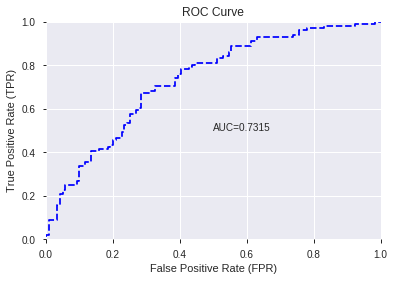

This function is available for GLM models only


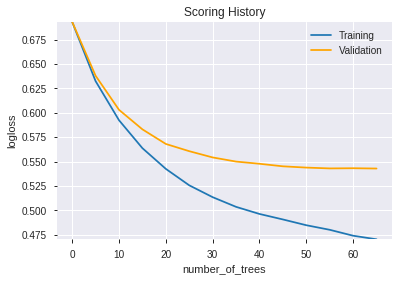

--2019-08-28 13:20:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_132002_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_132002_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'HT_DCPERIOD',
 'hour',
 'DIV',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'day',
 'days_in_month',
 'CDLGRAVESTONEDOJI',
 'CDLLONGLINE',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLTAKURI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [12] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


45

['Volume',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MOM_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLHAMMER',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_132035  0.752392  0.628809              0.329978  0.455516  0.207494
1  DeepLearning_grid_1_AutoML_20190828_132035_model_7  0.739745  0.686471              0.288086  0.466536  0.217656
2  DeepLearning_grid_1_AutoML_20190828_132035_model_4  0.738081  0.685188              0.347824  0.468310  0.219314
3  DeepLearning_grid_1_AutoML_20190828_132035_model_2  0.737998  0.693518              0.320201  0.470007  0.220907
4  DeepLearning_grid_1_AutoML_20190828_132035_model_8  0.737166  0.620189              0.288834  0.457613  0.209410
5  DeepLearning_grid_1_AutoML_20190828_132035_model_9  0.728846  0.622307              0.318704  0.458567  0.210284
6  DeepLearning_grid_1_AutoML_20190828_132035_model_5  0.726932  0.624268              0.319453  0.461874  0.213327
7  DeepLearning_grid_1_AutoML_20190828_132035_model_6  0.725601  0.637108              0.301897  0.464967  0.216194
8  DeepLearning_grid_1_AutoML_20190828_132035_model_3  0.725268  0.826716              0.304892  0.479715  0.230127
9  DeepLearning_grid_1_AutoML_20190828_132035_model_1  0.711124  0.904301              0.290623  0.486510  0.236692

variable  relative_importance  scaled_importance  percentage
0             WILLR_20             1.000000           1.000000    0.031238
1                  BOP             0.980387           0.980387    0.030625
2             WILLR_30             0.976031           0.976031    0.030489
3   CDLCLOSINGMARUBOZU             0.964120           0.964120    0.030117
4               TRANGE             0.951388           0.951388    0.029719
5          STOCH_slowk             0.934116           0.934116    0.029180
6                  SUB             0.888172           0.888172    0.027745
7               Volume             0.826980           0.826980    0.025833
8               CCI_14             0.805829           0.805829    0.025172
9               RSI_20             0.799019           0.799019    0.024960
10             WILLR_8             0.772868           0.772868    0.024143
11              CMO_14             0.755478           0.755478    0.023599
12            WILLR_14             0.754971           0.754971    0.023584
13               MOM_8             0.752972           0.752972    0.023521
14              ROCR_8             0.733339           0.733339    0.022908
15           ROCR100_8             0.733185           0.733185    0.022903
16        STOCHF_fastd             0.732112           0.732112    0.022870
17            WILLR_24             0.732053           0.732053    0.022868
18                 DIV             0.731328           0.731328    0.022845
19        CDLENGULFING             0.730757           0.730757    0.022827
20         CDLMARUBOZU             0.728099           0.728099    0.022744
21              CCI_12             0.724576           0.724576    0.022634
22        CDLSHORTLINE             0.721009           0.721009    0.022523
23              RSI_30             0.712386           0.712386    0.022253
24              CMO_12             0.699693           0.699693    0.021857
25              RSI_14             0.683424           0.683424    0.021349
26            WILLR_12             0.673603           0.673603    0.021042
27              CMO_20             0.664780           0.664780    0.020766
28      STOCHRSI_fastk             0.648784           0.648784    0.020267
29              MOM_12             0.647430           0.647430    0.020224
30              ULTOSC             0.622462           0.622462    0.019444
31           CDLHAMMER             0.618558           0.618558    0.019322
32               ADOSC             0.608256           0.608256    0.019001
33               RSI_8             0.606189           0.606189    0.018936
34              CMO_30             0.604416           0.604416    0.018881
35              ROCP_8             0.593467           0.593467    0.018539
36               CMO_8             0.590730           0.590730    0.018453
37               ROC_8             0.582814           0.582814    0.018206
38              RSI_12             0.580502           0.580502    0.018134
39              CMO_24             0.570132           0.570132    0.017810
40         CDLBELTHOLD             0.554228           0.554228    0.017313
41              RSI_24             0.542805           0.542805    0.016956
42         CDLLONGLINE             0.523075           0.523075    0.016340
43        STOCHF_fastk             0.511051           0.511051    0.015964
44               CCI_8             0.444919           0.444919    0.013898

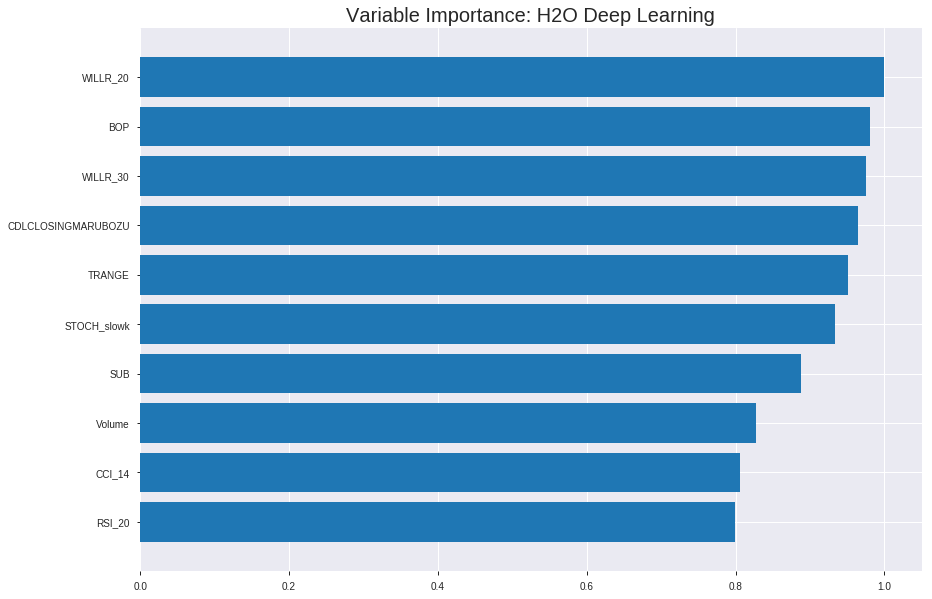

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_132035


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1838958166057971
RMSE: 0.42883075520046027
LogLoss: 0.5403529069470585
Mean Per-Class Error: 0.26750084803256446
AUC: 0.8088882293080054
pr_auc: 0.775459482632086
Gini: 0.6177764586160108
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2820196974013629: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      437  363   0.4537   (363.0/800.0)
1      67   670   0.0909   (67.0/737.0)
Total  504  1033  0.2798   (430.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.28202      0.757062  277
max f2                       0.216441     0.855087  308
max f0point5                 0.483462     0.725833  179
max accuracy                 0.34587      0.728042  248
max precision                0.995078     1         0
max recall                   0.0111746    1         392
max specificity              0.995078     1         0
max absolute_mcc             0.28202      0.484563  277
max min_per_class_accuracy   0.412415     0.7175    214
max mean_per_class_accuracy  0.335741     0.732499  252

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 41.45 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.962652           1.95514    1.95514            0.9375           0.976366   0.9375                      0.976366            0.0203528       0.0203528                  95.5139   95.5139
    2        0.0201692                   0.930021           1.80742    1.88366            0.866667         0.942835   0.903226                    0.960141            0.0176391       0.0379919                  80.7417   88.3661
    3        0.0305791                   0.915173           2.08548    1.95237            1                0.921857   0.93617                     0.947108            0.0217096       0.0597015                  108.548   95.2366
    4        0.0403383                   0.898493           2.08548    1.98457            1                0.906369   0.951613                    0.937252            0.0203528       0.0800543                  108.548   98.4571
    5        0.0500976                   0.87779            1.94645    1.97714            0.933333         0.890648   0.948052                    0.928173            0.0189959       0.0990502                  94.645    97.7145
    6        0.100195                    0.780817           1.76047    1.86881            0.844156         0.832303   0.896104                    0.880238            0.0881954       0.187246                   76.0472   86.8808
    7        0.150293                    0.696684           1.5438     1.76047            0.74026          0.734978   0.844156                    0.831818            0.0773406       0.264586                   54.3798   76.0472
    8        0.20039                     0.638954           1.5438     1.7063             0.74026          0.666545   0.818182                    0.7905              0.0773406       0.341927                   54.3798   70.6303
    9        0.299935                    0.544628           1.45847    1.62405            0.699346         0.589201   0.778742                    0.723691            0.145183        0.48711                    45.8474   62.4052
    10       0.40013                     0.470826           1.36775    1.55987            0.655844         0.50667    0.747967                    0.669348            0.137042        0.624152                   36.7751   55.9872
    11       0.500325                    0.404756           1.06983    1.46174            0.512987         0.438707   0.70091                     0.62316             0.107191        0.731343                   6.9825    46.1736
    12       0.59987                     0.333706           1.10408    1.40238            0.529412         0.372326   0.672451                    0.581535            0.109905        0.841248                   10.4079   40.2385
    13       0.700065                    0.261129           0.826067   1.3199             0.396104         0.29746    0.6329                      0.540878            0.082768        0.924016                   -17.3933  31.9901
    14       0.79961                     0.166001           0.395287   1.20479            0.189542         0.214881   0.577705                    0.500294            0.0393487       0.963365                   -60.4713  20.4794
    15       0.899805                    0.0673369          0.284384   1.1023             0.136364         0.116439   0.528561                    0.457551            0.0284939       0.991859                   -71.5616  10.2304
    16       1                           0.000505453        0.0812525  1                  0.038961         0.0273884  0.479506 



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20505549697028194
RMSE: 0.4528305389108402
LogLoss: 0.606305406575981
Mean Per-Class Error: 0.2669435490536408
AUC: 0.7854471443920985
pr_auc: 0.7390394479566933
Gini: 0.570894288784197
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2877630847510465: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      135  83   0.3807   (83.0/218.0)
1      34   188  0.1532   (34.0/222.0)
Total  169  271  0.2659   (117.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.287763     0.762677  251
max f2                       0.0972406    0.869048  342
max f0point5                 0.371968     0.72973   206
max accuracy                 0.287763     0.734091  251
max precision                0.776509     0.862069  54
max recall                   0.0028248    1         397
max specificity              0.99611      0.995413  0
max absolute_mcc             0.287763     0.479146  251
max min_per_class_accuracy   0.375012     0.724771  205
max mean_per_class_accuracy  0.287763     0.733056  251

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 40.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.97757            1.18919   1.18919            0.6              0.989129   0.6                         0.989129            0.0135135       0.0135135                  18.9189   18.9189
    2        0.0204545                   0.961162           1.48649   1.32132            0.75             0.97164    0.666667                    0.981356            0.0135135       0.027027                   48.6486   32.1321
    3        0.0318182                   0.931779           1.98198   1.55727            1                0.945963   0.785714                    0.968716            0.0225225       0.0495495                  98.1982   55.7272
    4        0.0409091                   0.9234             1.98198   1.65165            1                0.927454   0.833333                    0.959546            0.018018        0.0675676                  98.1982   65.1652
    5        0.05                        0.914645           1.48649   1.62162            0.75             0.918508   0.818182                    0.952085            0.0135135       0.0810811                  48.6486   62.1622
    6        0.1                         0.842641           1.71171   1.66667            0.863636         0.880346   0.840909                    0.916215            0.0855856       0.166667                   71.1712   66.6667
    7        0.15                        0.746695           1.53153   1.62162            0.772727         0.789752   0.818182                    0.874061            0.0765766       0.243243                   53.1532   62.1622
    8        0.2                         0.638893           1.44144   1.57658            0.727273         0.692493   0.795455                    0.828669            0.0720721       0.315315                   44.1441   57.6577
    9        0.3                         0.526872           1.26126   1.47147            0.636364         0.580233   0.742424                    0.745857            0.126126        0.441441                   26.1261   47.1471
    10       0.4                         0.449397           1.48649   1.47523            0.75             0.488007   0.744318                    0.681395            0.148649        0.59009                    48.6486   47.5225
    11       0.5                         0.375216           1.30631   1.44144            0.659091         0.409221   0.727273                    0.62696             0.130631        0.720721                   30.6306   44.1441
    12       0.6                         0.294498           1.03604   1.37387            0.522727         0.337194   0.693182                    0.578666            0.103604        0.824324                   3.6036    37.3874
    13       0.7                         0.228375           0.720721  1.28057            0.363636         0.260827   0.646104                    0.53326             0.0720721       0.896396                   -27.9279  28.0566
    14       0.8                         0.123827           0.630631  1.19932            0.318182         0.181223   0.605114                    0.489255            0.0630631       0.959459                   -36.9369  19.9324
    15       0.9                         0.0574572          0.36036   1.10611            0.181818         0.092646   0.558081                    0.445188            0.036036        0.995495                   -63.964   10.6106
    16       1                           0.000913256        0.045045  1                  0.0227273        0.0232528  0.504545                   


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:20:35  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:20:35  0.053 sec   102466 obs/sec    1         1             1537       0.45728          0.610438            0.162174       0.752938        0.699932           1.43377          0.343526                         0.469457           0.669505              0.118368         0.757263          0.737072             1.18919            0.35
    2019-08-28 13:20:35  0.214 sec   98525 obs/sec     10        10            15370      0.428831         0.540353            0.263179       0.808888        0.775459           1.95514          0.279766                         0.452831           0.606305              0.17971          0.785447          0.739039             1.18919            0.265909

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
WILLR_20            1.0                    1.0                  0.031237803795763415
BOP                 0.9803874492645264     0.9803874492645264   0.030625150783954235
WILLR_30            0.9760308265686035     0.9760308265686035   0.030489059458966825
CDLCLOSINGMARUBOZU  0.9641200304031372     0.9641200304031372   0.03011699234529866
TRANGE              0.9513882994651794     0.9513882994651794   0.029719281032278284
---                 ---                    ---                  ---
CDLBELTHOLD         0.5542278289794922     0.5542278289794922   0.0173128601798133
RSI_24              0.5428053140640259     0.5428053140640259   0.01695604590002978
CDLLONGLINE         0.5230753421783447     0.5230753421783447   0.016339724909368945
STOCHF_fastk        0.5110507011413574     0.5110507011413574   0.015964101531941048
CCI_8               0.4449188709259033     0.4449188709259033   0.013898288395015956


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7045454545454546)

('F1', 0.7153284671532847)

('auc', 0.7523920459272818)

('logloss', 0.6288094883452103)

('mean_per_class_error', 0.29707130376903235)

('rmse', 0.45551550975478633)

('mse', 0.20749437962716283)

deeplearning prediction progress: |███████████████████████████████████████| 100%


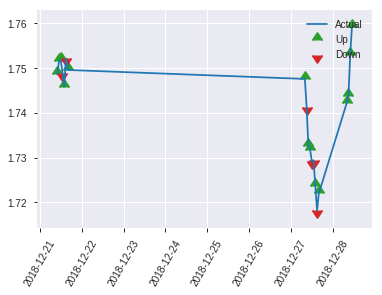


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20749437962716283
RMSE: 0.45551550975478633
LogLoss: 0.6288094883452103
Mean Per-Class Error: 0.29707130376903235
AUC: 0.7523920459272818
pr_auc: 0.6739662655665394
Gini: 0.5047840918545636
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1902171990922551: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      44   75   0.6303   (75.0/119.0)
1      3    98   0.0297   (3.0/101.0)
Total  47   173  0.3545   (78.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.190217     0.715328  172
max f2                       0.190217     0.84922   172
max f0point5                 0.503889     0.681234  71
max accuracy                 0.423908     0.704545  99
max precision                0.873885     0.866667  14
max recall                   0.00294202   1         219
max specificity              0.989225     0.991597  0
max absolute_mcc             0.190217     0.413427  172
max min_per_class_accuracy   0.407506     0.689076  106
max mean_per_class_accuracy  0.419536     0.702929  101

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 40.83 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0136364                   0.955394           1.45215    1.45215            0.666667         0.974516  0.666667                    0.974516            0.019802        0.019802                   45.2145    45.2145
    2        0.0227273                   0.935682           1.08911    1.30693            0.5              0.943744  0.6                         0.962207            0.00990099      0.029703                   8.91089    30.6931
    3        0.0318182                   0.906877           2.17822    1.55587            1                0.918424  0.714286                    0.949698            0.019802        0.049505                   117.822    55.587
    4        0.0409091                   0.896276           2.17822    1.69417            1                0.899543  0.777778                    0.938552            0.019802        0.0693069                  117.822    69.4169
    5        0.05                        0.887359           2.17822    1.78218            1                0.893758  0.818182                    0.930408            0.019802        0.0891089                  117.822    78.2178
    6        0.1                         0.754983           1.38614    1.58416            0.636364         0.821769  0.727273                    0.876089            0.0693069       0.158416                   38.6139    58.4158
    7        0.15                        0.682362           1.38614    1.51815            0.636364         0.71801   0.69697                     0.823396            0.0693069       0.227723                   38.6139    51.8152
    8        0.2                         0.610621           1.58416    1.53465            0.727273         0.639547  0.704545                    0.777434            0.0792079       0.306931                   58.4158    53.4653
    9        0.3                         0.51729            1.78218    1.61716            0.818182         0.570096  0.742424                    0.708321            0.178218        0.485149                   78.2178    61.7162
    10       0.4                         0.467853           1.08911    1.48515            0.5              0.493861  0.681818                    0.654706            0.108911        0.594059                   8.91089    48.5149
    11       0.5                         0.403835           0.990099   1.38614            0.454545         0.433119  0.636364                    0.610389            0.0990099       0.693069                   -0.990099  38.6139
    12       0.6                         0.334072           0.891089   1.30363            0.409091         0.370139  0.598485                    0.570347            0.0891089       0.782178                   -10.8911   30.363
    13       0.7                         0.260035           0.990099   1.25884            0.454545         0.293334  0.577922                    0.530774            0.0990099       0.881188                   -0.990099  25.884
    14       0.8                         0.179691           0.891089   1.21287            0.409091         0.216774  0.556818                    0.491524            0.0891089       0.970297                   -10.8911   21.2871
    15       0.9                         0.0753829          0.0990099  1.08911            0.0454545        0.121715  0.5                         0.450434            0.00990099      0.980198                   -90.099    8.91089
    16       1                           0.00294202         0.19802    1                  0.0909091        0.029056  0.459091     

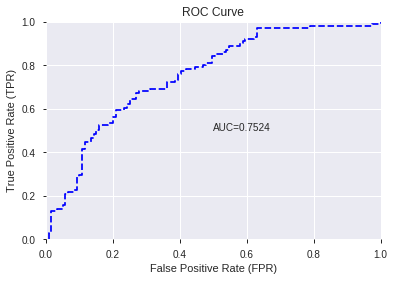

This function is available for GLM models only


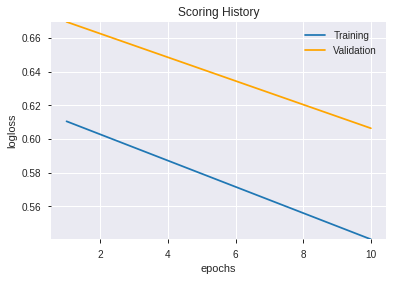

--2019-08-28 13:27:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_132035',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_132035',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_b106'

['WILLR_20',
 'BOP',
 'WILLR_30',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'STOCH_slowk',
 'SUB',
 'Volume',
 'CCI_14',
 'RSI_20',
 'WILLR_8',
 'CMO_14',
 'WILLR_14',
 'MOM_8',
 'ROCR_8',
 'ROCR100_8',
 'STOCHF_fastd',
 'WILLR_24',
 'DIV',
 'CDLENGULFING',
 'CDLMARUBOZU',
 'CCI_12',
 'CDLSHORTLINE',
 'RSI_30',
 'CMO_12',
 'RSI_14',
 'WILLR_12',
 'CMO_20',
 'STOCHRSI_fastk',
 'MOM_12',
 'ULTOSC',
 'CDLHAMMER',
 'ADOSC',
 'RSI_8',
 'CMO_30',
 'ROCP_8',
 'CMO_8',
 'ROC_8',
 'RSI_12',
 'CMO_24',
 'CDLBELTHOLD',
 'RSI_24',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'CCI_8']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_132754_model_1  0.746235  0.600348              0.281929  0.451571  0.203917

variable  relative_importance  scaled_importance  percentage
0                  SUB             2.591566           1.000000    0.191161
1                  DIV             1.920533           0.741070    0.141664
2                  BOP             0.882120           0.340381    0.065068
3               CCI_12             0.612257           0.236250    0.045162
4               CMO_20             0.544994           0.210295    0.040200
5               CCI_14             0.536947           0.207190    0.039607
6         STOCHF_fastk             0.502394           0.193857    0.037058
7                CCI_8             0.475011           0.183291    0.035038
8                CMO_8             0.465936           0.179789    0.034369
9               CMO_30             0.419348           0.161812    0.030932
10               RSI_8             0.365178           0.140910    0.026937
11            WILLR_30             0.329641           0.127198    0.024315
12  CDLCLOSINGMARUBOZU             0.316634           0.122179    0.023356
13              ULTOSC             0.282042           0.108831    0.020804
14           CDLHAMMER             0.249301           0.096197    0.018389
15        STOCHF_fastd             0.215642           0.083209    0.015906
16              RSI_20             0.214497           0.082767    0.015822
17         STOCH_slowk             0.203717           0.078608    0.015027
18              RSI_12             0.199285           0.076897    0.014700
19              CMO_14             0.195695           0.075512    0.014435
20              RSI_30             0.174080           0.067172    0.012841
21         CDLLONGLINE             0.172433           0.066536    0.012719
22            WILLR_14             0.156344           0.060328    0.011532
23               MOM_8             0.151423           0.058429    0.011169
24            WILLR_24             0.130346           0.050296    0.009615
25            WILLR_20             0.125086           0.048267    0.009227
26              TRANGE             0.122894           0.047421    0.009065
27              MOM_12             0.112982           0.043596    0.008334
28            WILLR_12             0.111439           0.043001    0.008220
29              CMO_12             0.110770           0.042743    0.008171
30              RSI_14             0.098705           0.038087    0.007281
31             WILLR_8             0.077711           0.029986    0.005732
32               ROC_8             0.069828           0.026944    0.005151
33        CDLSHORTLINE             0.068248           0.026335    0.005034
34         CDLBELTHOLD             0.061549           0.023750    0.004540
35      STOCHRSI_fastk             0.059618           0.023004    0.004398
36        CDLENGULFING             0.049837           0.019230    0.003676
37               ADOSC             0.040073           0.015463    0.002956
38         CDLMARUBOZU             0.035093           0.013541    0.002589
39              ROCP_8             0.034147           0.013176    0.002519
40              CMO_24             0.023020           0.008883    0.001698
41              RSI_24             0.019506           0.007527    0.001439
42              ROCR_8             0.016999           0.006559    0.001254
43           ROCR100_8             0.011446           0.004417    0.000844
44              Volume             0.000635           0.000245    0.000047

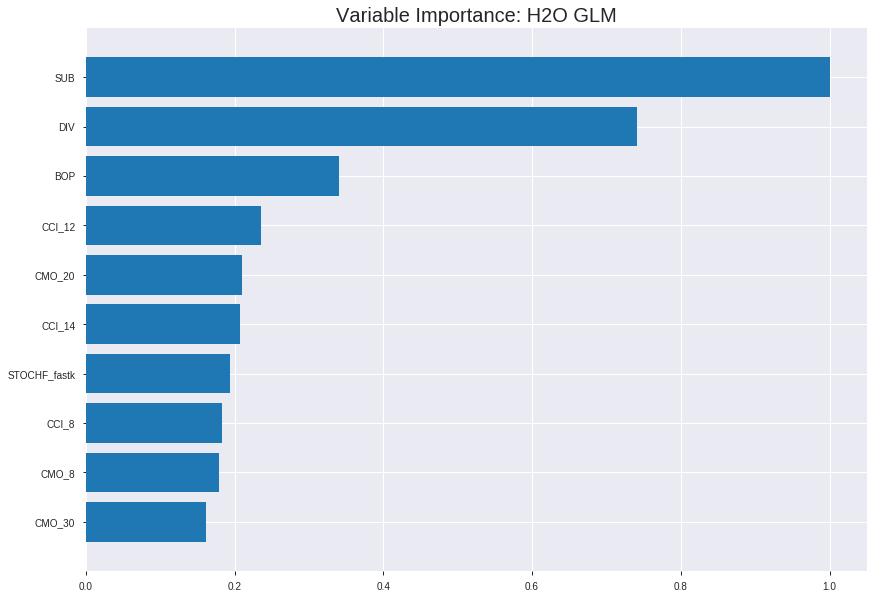

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_132754_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18700694005893065
RMSE: 0.43244299053046364
LogLoss: 0.5515522705981021
Null degrees of freedom: 1536
Residual degrees of freedom: 1491
Null deviance: 2128.1514062818787
Residual deviance: 1695.471679818566
AIC: 1787.471679818566
AUC: 0.7876534938941656
pr_auc: 0.7461942494076138
Gini: 0.5753069877883312
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3544652194741911: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      428  372   0.465    (372.0/800.0)
1      90   647   0.1221   (90.0/737.0)
Total  518  1019  0.3006   (462.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.354465     0.736902  259
max f2                       0.175557     0.850059  333
max f0point5                 0.521071     0.70703   187
max accuracy                 0.481703     0.723487  203
max precision                0.953977     1         0
max recall                   0.0372665    1         388
max specificity              0.953977     1         0
max absolute_mcc             0.481703     0.450395  203
max min_per_class_accuracy   0.518313     0.72      188
max mean_per_class_accuracy  0.481703     0.725025  203

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 47.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.915258           1.8248    1.8248             0.875            0.933257   0.875                       0.933257            0.0189959       0.0189959                  82.4796   82.4796
    2        0.0201692                   0.902007           1.94645   1.88366            0.933333         0.90895    0.903226                    0.921496            0.0189959       0.0379919                  94.645    88.3661
    3        0.0305791                   0.888555           1.95514   1.90799            0.9375           0.895282   0.914894                    0.912572            0.0203528       0.0583446                  95.5139   90.7994
    4        0.0403383                   0.878902           1.80742   1.88366            0.866667         0.883936   0.903226                    0.905644            0.0176391       0.0759837                  80.7417   88.3661
    5        0.0500976                   0.862348           1.66839   1.84172            0.8              0.869649   0.883117                    0.898632            0.0162822       0.0922659                  66.8385   84.1724
    6        0.100195                    0.795502           1.81464   1.82818            0.87013          0.82855    0.876623                    0.863591            0.0909091       0.183175                   81.464    82.8182
    7        0.150293                    0.748522           1.43546   1.69728            0.688312         0.769448   0.813853                    0.83221             0.0719132       0.255088                   43.5461   69.7275
    8        0.20039                     0.714701           1.43546   1.63182            0.688312         0.731157   0.782468                    0.806947            0.0719132       0.327001                   43.5461   63.1822
    9        0.299935                    0.652671           1.4721    1.57881            0.705882         0.685899   0.75705                     0.766773            0.14654         0.473541                   47.2105   57.8814
    10       0.40013                     0.585613           1.34067   1.51918            0.642857         0.618878   0.728455                    0.729739            0.134328        0.60787                    34.0667   51.918
    11       0.500325                    0.51106            1.21879   1.45902            0.584416         0.550333   0.69961                     0.693811            0.122117        0.729986                   21.8788   45.9024
    12       0.59987                     0.417587           0.926881  1.37072            0.444444         0.460634   0.657267                    0.655117            0.0922659       0.822252                   -7.31193  37.0718
    13       0.700065                    0.323159           0.785441  1.28695            0.376623         0.36769    0.6171                      0.613979            0.0786974       0.90095                    -21.4559  28.6952
    14       0.79961                     0.21609            0.490702  1.18783            0.235294         0.27069    0.569569                    0.571243            0.0488467       0.949796                   -50.9298  18.7825
    15       0.899805                    0.114835           0.392721  1.09929            0.188312         0.164197   0.527115                    0.525917            0.0393487       0.989145                   -60.7279  9.92886
    16       1                           0.00693435         0.108337  1                  0.0519481        0.0627061  0.479506                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18577111689567416
RMSE: 0.4310117363781109
LogLoss: 0.5476440385961158
Null degrees of freedom: 439
Residual degrees of freedom: 394
Null deviance: 611.0374769186825
Residual deviance: 481.9267539645819
AIC: 573.9267539645818
AUC: 0.7928237870898421
pr_auc: 0.775655366597347
Gini: 0.5856475741796843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32137247609156705: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  105  0.4817   (105.0/218.0)
1      21   201  0.0946   (21.0/222.0)
Total  134  306  0.2864   (126.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321372     0.761364  274
max f2                       0.189418     0.869391  323
max f0point5                 0.483293     0.722417  206
max accuracy                 0.439257     0.727273  226
max precision                0.924535     1         0
max recall                   0.0487686    1         383
max specificity              0.924535     1         0
max absolute_mcc             0.321372     0.460368  274
max min_per_class_accuracy   0.496014     0.706422  197
max mean_per_class_accuracy  0.439257     0.726672  226

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 46.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.891045           1.98198   1.98198            1                0.906259   1                           0.906259            0.0225225       0.0225225                  98.1982   98.1982
    2        0.0204545                   0.875914           1.98198   1.98198            1                0.882802   1                           0.895834            0.018018        0.0405405                  98.1982   98.1982
    3        0.0318182                   0.863569           1.98198   1.98198            1                0.868738   1                           0.886157            0.0225225       0.0630631                  98.1982   98.1982
    4        0.0409091                   0.847631           1.48649   1.87187            0.75             0.855166   0.944444                    0.87927             0.0135135       0.0765766                  48.6486   87.1872
    5        0.05                        0.839363           1.48649   1.8018             0.75             0.842259   0.909091                    0.872541            0.0135135       0.0900901                  48.6486   80.1802
    6        0.1                         0.778594           1.71171   1.75676            0.863636         0.808772   0.886364                    0.840656            0.0855856       0.175676                   71.1712   75.6757
    7        0.15                        0.733103           1.71171   1.74174            0.863636         0.752354   0.878788                    0.811222            0.0855856       0.261261                   71.1712   74.1742
    8        0.2                         0.703331           1.26126   1.62162            0.636364         0.716506   0.818182                    0.787543            0.0630631       0.324324                   26.1261   62.1622
    9        0.3                         0.627121           1.48649   1.57658            0.75             0.667697   0.795455                    0.747594            0.148649        0.472973                   48.6486   57.6577
    10       0.4                         0.569886           1.17117   1.47523            0.590909         0.598039   0.744318                    0.710206            0.117117        0.59009                    17.1171   47.5225
    11       0.5                         0.49694            1.12613   1.40541            0.568182         0.534424   0.709091                    0.675049            0.112613        0.702703                   12.6126   40.5405
    12       0.6                         0.407654           1.17117   1.36637            0.590909         0.453584   0.689394                    0.638138            0.117117        0.81982                    17.1171   36.6366
    13       0.7                         0.318199           0.855856  1.29344            0.431818         0.363464   0.652597                    0.598899            0.0855856       0.905405                   -14.4144  29.3436
    14       0.8                         0.205738           0.585586  1.20495            0.295455         0.26202    0.607955                    0.556789            0.0585586       0.963964                   -41.4414  20.4955
    15       0.9                         0.106157           0.225225  1.0961             0.113636         0.155471   0.55303                     0.512198            0.0225225       0.986486                   -77.4775  9.60961
    16       1                           0.00345206         0.135135  1                  0.0681818        0.0608352  0.504545                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 13:27:54  0.000 sec   2            .21E2     46            1.3599319368780778  1.361278473260011
     2019-08-28 13:27:54  0.017 sec   4            .13E2     46            1.3492895375999867  1.3495138014236852
     2019-08-28 13:27:54  0.034 sec   6            .82E1     46            1.3357353371766765  1.3345464616364417
     2019-08-28 13:27:54  0.051 sec   8            .51E1     46            1.3190575152979762  1.316093470214774
     2019-08-28 13:27:54  0.068 sec   10           .31E1     46            1.2990591818121937  1.2938600610607254
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 13:27:54  0.319 sec   51           .14E-3    46            1.1035587679981778  1.095862300197629
     2019-08-28 13:27:54  0.330 sec   52           .88E-4    46            1.103342253896617   1.0956152413534719
     2019-08-28 13:27:54  0.335 sec   53           .55E-4    46            1.1032189185964587  1.0954246313782943
     2019-08-28 13:27:54  0.341 sec   54           .34E-4    46            1.1031455961970809  1.0953279994953347
     2019-08-28 13:27:54  0.346 sec   55           .21E-4    46            1.1031045411962042  1.0952880771922315


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7136363636363636)

('F1', 0.7123287671232877)

('auc', 0.7462351277144521)

('logloss', 0.6003483448810121)

('mean_per_class_error', 0.2819286130293701)

('rmse', 0.45157134040663854)

('mse', 0.2039166754766482)

glm prediction progress: |████████████████████████████████████████████████| 100%


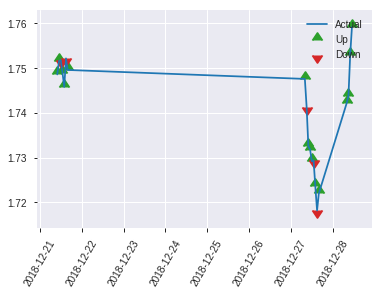


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2039166754766482
RMSE: 0.45157134040663854
LogLoss: 0.6003483448810121
Null degrees of freedom: 219
Residual degrees of freedom: 174
Null deviance: 303.8782617497692
Residual deviance: 264.1532717476453
AIC: 356.1532717476453
AUC: 0.7462351277144521
pr_auc: 0.660092616295468
Gini: 0.4924702554289042
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44678228004281545: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      79   40   0.3361   (40.0/119.0)
1      23   78   0.2277   (23.0/101.0)
Total  102  118  0.2864   (63.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446782     0.712329  117
max f2                       0.264419     0.828924  162
max f0point5                 0.556291     0.691824  93
max accuracy                 0.556291     0.713636  93
max precision                0.933374     1         0
max recall                   0.0491418    1         216
max specificity              0.933374     1         0
max absolute_mcc             0.446782     0.435835  117
max min_per_class_accuracy   0.51088      0.689076  106
max mean_per_class_accuracy  0.446782     0.718071  117

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 46.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0136364                   0.90714            1.45215   1.45215            0.666667         0.919794   0.666667                    0.919794            0.019802        0.019802                   45.2145    45.2145
    2        0.0227273                   0.884023           2.17822   1.74257            1                0.891492   0.8                         0.908473            0.019802        0.039604                   117.822    74.2574
    3        0.0318182                   0.872186           2.17822   1.86704            1                0.881782   0.857143                    0.900847            0.019802        0.0594059                  117.822    86.7044
    4        0.0409091                   0.860787           1.08911   1.69417            0.5              0.864086   0.777778                    0.892678            0.00990099      0.0693069                  8.91089    69.4169
    5        0.05                        0.854153           2.17822   1.78218            1                0.857964   0.818182                    0.886366            0.019802        0.0891089                  117.822    78.2178
    6        0.1                         0.776306           1.38614   1.58416            0.636364         0.815232   0.727273                    0.850799            0.0693069       0.158416                   38.6139    58.4158
    7        0.15                        0.730123           1.18812   1.45215            0.545455         0.753216   0.666667                    0.818272            0.0594059       0.217822                   18.8119    45.2145
    8        0.2                         0.696559           1.58416   1.48515            0.727273         0.712343   0.681818                    0.791789            0.0792079       0.29703                    58.4158    48.5149
    9        0.3                         0.644567           1.58416   1.51815            0.727273         0.67339    0.69697                     0.752323            0.158416        0.455446                   58.4158    51.8152
    10       0.4                         0.578562           1.48515   1.5099             0.681818         0.615298   0.693182                    0.718067            0.148515        0.60396                    48.5149    50.9901
    11       0.5                         0.484173           0.990099  1.40594            0.454545         0.536622   0.645455                    0.681778            0.0990099       0.70297                    -0.990099  40.5941
    12       0.6                         0.386672           0.990099  1.33663            0.454545         0.436692   0.613636                    0.64093             0.0990099       0.80198                    -0.990099  33.6634
    13       0.7                         0.283107           0.792079  1.25884            0.363636         0.33996    0.577922                    0.597934            0.0792079       0.881188                   -20.7921   25.884
    14       0.8                         0.214348           0.49505   1.16337            0.227273         0.256421   0.534091                    0.555245            0.049505        0.930693                   -50.495    16.3366
    15       0.9                         0.114706           0.39604   1.07811            0.181818         0.176678   0.494949                    0.513182            0.039604        0.970297                   -60.396    7.81078
    16       1                           0.0340559          0.29703   1                  0.136364         0.0782731  0.459091   

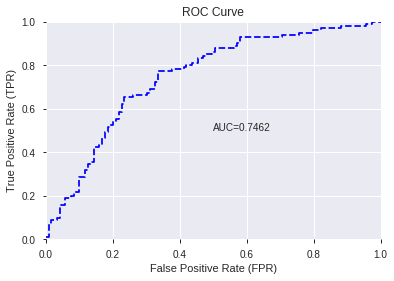

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


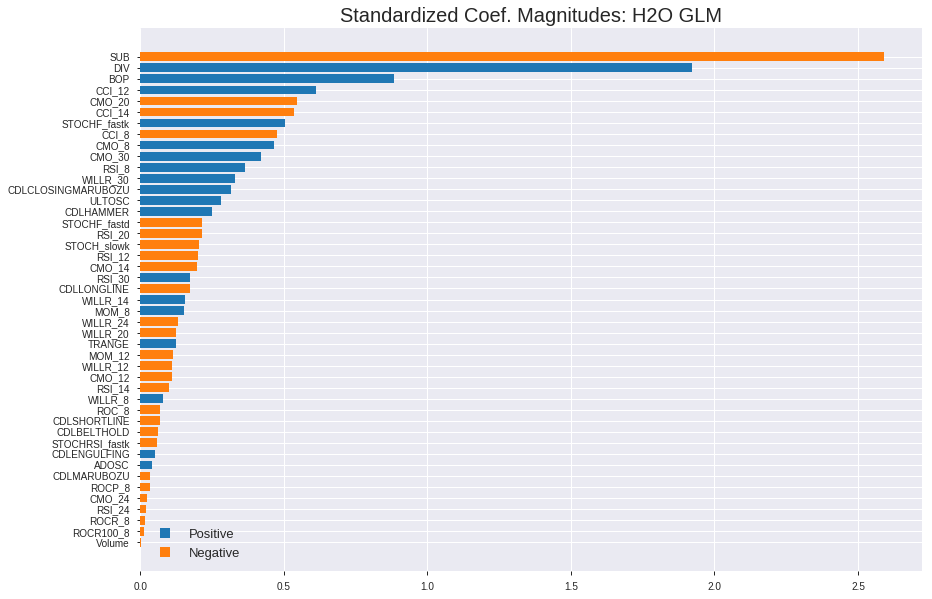

'log_likelihood'
--2019-08-28 13:28:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_132754_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_132754_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['SUB',
 'DIV',
 'BOP',
 'CCI_12',
 'CMO_20',
 'CCI_14',
 'STOCHF_fastk',
 'CCI_8',
 'CMO_8',
 'CMO_30',
 'RSI_8',
 'WILLR_30',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'CDLHAMMER',
 'STOCHF_fastd',
 'RSI_20',
 'STOCH_slowk',
 'RSI_12',
 'CMO_14',
 'RSI_30',
 'CDLLONGLINE',
 'WILLR_14',
 'MOM_8',
 'WILLR_24',
 'WILLR_20',
 'TRANGE',
 'MOM_12',
 'WILLR_12',
 'CMO_12',
 'RSI_14',
 'WILLR_8',
 'ROC_8',
 'CDLSHORTLINE',
 'CDLBELTHOLD',
 'STOCHRSI_fastk',
 'CDLENGULFING',
 'ADOSC',
 'CDLMARUBOZU',
 'ROCP_8',
 'CMO_24',
 'RSI_24',
 'ROCR_8',
 'ROCR100_8',
 'Volume']

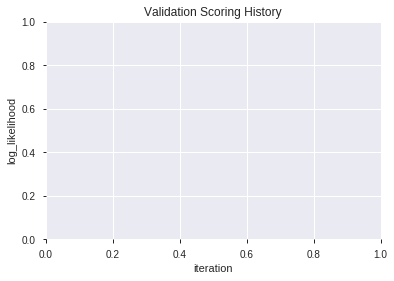

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190828_132808  0.742241  0.605558              0.311964  0.457680  0.209471
1  XGBoost_grid_1_AutoML_20190828_132808_model_6  0.739662  0.601276              0.330269  0.455774  0.207730
2  XGBoost_grid_1_AutoML_20190828_132808_model_4  0.734337  0.602393              0.305350  0.456455  0.208351
3  XGBoost_grid_1_AutoML_20190828_132808_model_7  0.731425  0.617771              0.316166  0.462692  0.214084
4               XGBoost_3_AutoML_20190828_132808  0.731342  0.608405              0.354730  0.458930  0.210617
5  XGBoost_grid_1_AutoML_20190828_132808_model_2  0.730427  0.605285              0.347824  0.457633  0.209428
6  XGBoost_grid_1_AutoML_20190828_132808_model_3  0.730094  0.603423              0.326067  0.456334  0.208241
7               XGBoost_2_AutoML_20190828_132808  0.729096  0.615531              0.308803  0.462428  0.213840
8  XGBoost_grid_1_AutoML_20190828_132808_model_5  0.725684  0.634684              0.336717  0.467964  0.218990
9  XGBoost_grid_1_AutoML_20190828_132808_model_1  0.718196  0.622084              0.348573  0.464424  0.215689

variable  relative_importance  scaled_importance  percentage
0                  BOP          2035.025391           1.000000    0.225984
1         STOCHF_fastk           506.508331           0.248895    0.056246
2               TRANGE           450.176086           0.221214    0.049991
3                CCI_8           399.716888           0.196419    0.044388
4                  DIV           369.245331           0.181445    0.041004
5                  SUB           360.637207           0.177215    0.040048
6               ULTOSC           317.931549           0.156230    0.035305
7       STOCHRSI_fastk           275.310486           0.135286    0.030573
8          STOCH_slowk           265.374847           0.130404    0.029469
9               Volume           257.768066           0.126666    0.028624
10              CCI_14           254.718399           0.125167    0.028286
11            WILLR_24           236.434052           0.116182    0.026255
12              CCI_12           235.405991           0.115677    0.026141
13             WILLR_8           221.225357           0.108709    0.024566
14            WILLR_30           196.852219           0.096732    0.021860
15               ADOSC           192.528183           0.094607    0.021380
16               MOM_8           182.602554           0.089730    0.020278
17               CMO_8           169.253281           0.083170    0.018795
18            WILLR_12           168.040634           0.082574    0.018660
19               ROC_8           167.885361           0.082498    0.018643
20              CMO_14           161.336533           0.079280    0.017916
21              MOM_12           159.938431           0.078593    0.017761
22            WILLR_14           153.300064           0.075331    0.017024
23              CMO_24           126.938705           0.062377    0.014096
24              CMO_30           122.228813           0.060063    0.013573
25        STOCHF_fastd           120.344299           0.059137    0.013364
26  CDLCLOSINGMARUBOZU           117.663345           0.057819    0.013066
27              CMO_12           104.305664           0.051255    0.011583
28            WILLR_20            97.137924           0.047733    0.010787
29              CMO_20            95.890427           0.047120    0.010648
30              ROCP_8            82.791840           0.040683    0.009194
31           CDLHAMMER            72.536118           0.035644    0.008055
32              RSI_12            56.331024           0.027681    0.006255
33              RSI_24            49.985229           0.024562    0.005551
34              RSI_30            45.322136           0.022271    0.005033
35        CDLSHORTLINE            35.188560           0.017291    0.003908
36              RSI_14            33.901924           0.016659    0.003765
37              ROCR_8            33.202377           0.016315    0.003687
38               RSI_8            30.739326           0.015105    0.003414
39              RSI_20            19.942089           0.009799    0.002215
40           ROCR100_8            16.676226           0.008195    0.001852
41         CDLBELTHOLD             3.193406           0.001569    0.000355
42        CDLENGULFING             2.887214           0.001419    0.000321
43         CDLLONGLINE             0.743183           0.000365    0.000083

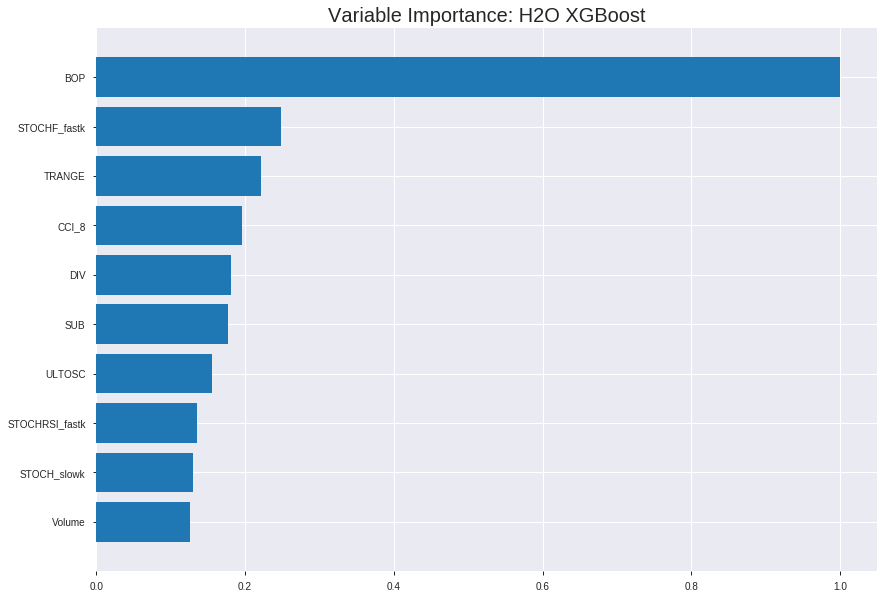

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190828_132808


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11212911138826714
RMSE: 0.33485685208498744
LogLoss: 0.37742967145088907
Mean Per-Class Error: 0.11685973541383987
AUC: 0.94781631614654
pr_auc: 0.9477992610231133
Gini: 0.8956326322930801
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5387391746044159: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      727  73   0.0912   (73.0/800.0)
1      105  632  0.1425   (105.0/737.0)
Total  832  705  0.1158   (178.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.538739     0.87656   183
max f2                       0.339436     0.90713   262
max f0point5                 0.612499     0.894652  150
max accuracy                 0.544636     0.88419   181
max precision                0.961339     1         0
max recall                   0.134011     1         349
max specificity              0.961339     1         0
max absolute_mcc             0.544636     0.768393  181
max min_per_class_accuracy   0.512303     0.8775    195
max mean_per_class_accuracy  0.538739     0.88314   183

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 47.95 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.911977           2.08548    2.08548            1                0.929318   1                           0.929318            0.0217096       0.0217096                  108.548   108.548
    2        0.0201692                   0.899844           2.08548    2.08548            1                0.906512   1                           0.918283            0.0203528       0.0420624                  108.548   108.548
    3        0.0305791                   0.889935           2.08548    2.08548            1                0.895222   1                           0.910432            0.0217096       0.063772                   108.548   108.548
    4        0.0403383                   0.87981            2.08548    2.08548            1                0.884788   1                           0.904228            0.0203528       0.0841248                  108.548   108.548
    5        0.0500976                   0.873365           2.08548    2.08548            1                0.876869   1                           0.898898            0.0203528       0.104478                   108.548   108.548
    6        0.100195                    0.831261           2.08548    2.08548            1                0.850798   1                           0.874848            0.104478        0.208955                   108.548   108.548
    7        0.150293                    0.800149           2.0584     2.07645            0.987013         0.818321   0.995671                    0.856006            0.103121        0.312076                   105.84    107.645
    8        0.20039                     0.76355            2.0584     2.07194            0.987013         0.780768   0.993506                    0.837197            0.103121        0.415197                   105.84    107.194
    9        0.299935                    0.68681            1.92191    2.02215            0.921569         0.724777   0.969631                    0.799886            0.191316        0.606513                   92.1914   102.215
    10       0.40013                     0.596358           1.67922    1.93628            0.805195         0.63979    0.928455                    0.759797            0.16825         0.774763                   67.9219   93.6276
    11       0.500325                    0.495436           1.12399    1.77361            0.538961         0.546857   0.850455                    0.717153            0.112619        0.887381                   12.3993   77.3609
    12       0.59987                     0.378193           0.558855   1.57203            0.267974         0.438297   0.753796                    0.670879            0.0556309       0.943012                   -44.1145  57.2028
    13       0.700065                    0.279989           0.32501    1.39355            0.155844         0.33029    0.668216                    0.622133            0.0325645       0.975577                   -67.499   39.3551
    14       0.79961                     0.182235           0.163567   1.24043            0.0784314        0.229628   0.594793                    0.573269            0.0162822       0.991859                   -83.6433  24.0429
    15       0.899805                    0.103762           0.0812525  1.11135            0.038961         0.140616   0.532899                    0.525093            0.00814111      1                          -91.8747  11.1352
    16       1                           0.0273938          0          1                  0                0.0705343  0.479506 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1785592933205298
RMSE: 0.42256276849780533
LogLoss: 0.5369895317910506
Mean Per-Class Error: 0.2367551037275808
AUC: 0.8119059426398876
pr_auc: 0.7724719510610081
Gini: 0.6238118852797752
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3487014174461365: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      141  77   0.3532   (77.0/218.0)
1      31   191  0.1396   (31.0/222.0)
Total  172  268  0.2455   (108.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348701     0.779592  246
max f2                       0.176998     0.857605  314
max f0point5                 0.510504     0.757282  185
max accuracy                 0.426225     0.763636  220
max precision                0.821016     0.882353  32
max recall                   0.0594778    1         383
max specificity              0.934884     0.995413  0
max absolute_mcc             0.426225     0.528657  220
max min_per_class_accuracy   0.484385     0.738739  201
max mean_per_class_accuracy  0.426225     0.763245  220

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 45.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.906949           1.58559    1.58559            0.8              0.917409   0.8                         0.917409            0.018018        0.018018                   58.5586   58.5586
    2        0.0204545                   0.891971           1.48649    1.54154            0.75             0.901802   0.777778                    0.910472            0.0135135       0.0315315                  48.6486   54.1542
    3        0.0318182                   0.881676           1.58559    1.55727            0.8              0.885474   0.785714                    0.901545            0.018018        0.0495495                  58.5586   55.7272
    4        0.0409091                   0.861852           1.98198    1.65165            1                0.86756    0.833333                    0.893992            0.018018        0.0675676                  98.1982   65.1652
    5        0.05                        0.840334           1.48649    1.62162            0.75             0.851485   0.818182                    0.886264            0.0135135       0.0810811                  48.6486   62.1622
    6        0.1                         0.804475           1.71171    1.66667            0.863636         0.822425   0.840909                    0.854344            0.0855856       0.166667                   71.1712   66.6667
    7        0.15                        0.763291           1.71171    1.68168            0.863636         0.784893   0.848485                    0.831194            0.0855856       0.252252                   71.1712   68.1682
    8        0.2                         0.714788           1.35135    1.5991             0.681818         0.738587   0.806818                    0.808042            0.0675676       0.31982                    35.1351   59.9099
    9        0.3                         0.658522           1.71171    1.63664            0.863636         0.68591    0.825758                    0.767332            0.171171        0.490991                   71.1712   63.6637
    10       0.4                         0.571474           1.21622    1.53153            0.613636         0.61825    0.772727                    0.730061            0.121622        0.612613                   21.6216   53.1532
    11       0.5                         0.480616           1.26126    1.47748            0.636364         0.522663   0.745455                    0.688581            0.126126        0.738739                   26.1261   47.7477
    12       0.6                         0.355744           1.08108    1.41141            0.545455         0.418798   0.712121                    0.643617            0.108108        0.846847                   8.10811   41.1411
    13       0.7                         0.255587           0.585586   1.29344            0.295455         0.300259   0.652597                    0.594566            0.0585586       0.905405                   -41.4414  29.3436
    14       0.8                         0.169142           0.495495   1.19369            0.25             0.214613   0.602273                    0.547072            0.0495495       0.954955                   -50.4505  19.3694
    15       0.9                         0.091176           0.36036    1.1011             0.181818         0.124438   0.555556                    0.500113            0.036036        0.990991                   -63.964   10.1101
    16       1                           0.0331324          0.0900901  1                  0.0454545        0.0618485  0.504545 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:28:09  0.016 sec   0                  0.5              0.693147            0.5             0                  1                0.520494                         0.5                0.693147              0.5               0                    1                  0.495455
    2019-08-28 13:28:09  0.137 sec   5                  0.470654         0.635784            0.844039        0.829095           2.08548          0.259597                         0.477318           0.648516              0.773494          0.74364              1.65165            0.259091
    2019-08-28 13:28:09  0.217 sec   10                 0.447741         0.592065            0.868892        0.857575           2.08548          0.211451                         0.460632           0.616017              0.790644          0.752224             1.65165            0.272727
    2019-08-28 13:28:09  0.297 sec   15                 0.428369         0.555158            0.879349        0.872193           2.08548          0.214704                         0.448371           0.591659              0.794942          0.758276             1.58559            0.243182
    2019-08-28 13:28:09  0.378 sec   20                 0.414107         0.527808            0.88969         0.886711           2.08548          0.20039                          0.440731           0.576248              0.799488          0.762702             1.58559            0.256818
    2019-08-28 13:28:09  0.463 sec   25                 0.40193          0.504407            0.899458        0.895312           2.08548          0.182824                         0.435561           0.565297              0.804137          0.768733             1.58559            0.231818
    2019-08-28 13:28:09  0.544 sec   30                 0.391563         0.484192            0.90584         0.90312            2.08548          0.176968                         0.431441           0.556594              0.805077          0.768762             1.58559            0.240909
    2019-08-28 13:28:09  0.628 sec   35                 0.38277          0.467086            0.91147         0.909242           2.08548          0.169811                         0.429941           0.552697              0.804075          0.765652             1.58559            0.25
    2019-08-28 13:28:10  0.714 sec   40                 0.375533         0.452657            0.915086        0.913869           2.08548          0.162004                         0.428903           0.550237              0.801957          0.760505             1.58559            0.252273
    2019-08-28 13:28:10  0.796 sec   45                 0.367915         0.438054            0.9216          0.920918           2.08548          0.149642                         0.426028           0.544613              0.806513          0.768437             1.58559            0.25
    2019-08-28 13:28:10  0.875 sec   50                 0.361669         0.425737            0.925717        0.925357           2.08548          0.141184                         0.423807           0.540326              0.809716          0.771989             1.58559            0.238636
    2019-08-28 13:28:10  0.955 sec   55                 0.355972         0.414745            0.929544        0.928404           2.08548          0.13728                          0.42349            0.539297              0.810584          0.772437 

Variable Importances: 


variable      relative_importance    scaled_importance       percentage
------------  ---------------------  ----------------------  ---------------------
BOP           2035.025390625         1.0                     0.22598424065188902
STOCHF_fastk  506.5083312988281      0.24889533744012332     0.05624642383320195
TRANGE        450.17608642578125     0.221213990007035       0.04999087555331437
CCI_8         399.7168884277344      0.19641862468604027     0.04438751374956319
DIV           369.2453308105469      0.18144507312370373     0.04100372706988666
---           ---                    ---                     ---
RSI_20        19.942089080810547     0.009799430106710316    0.0022145167714861906
ROCR100_8     16.676225662231445     0.008194603241343253    0.0018518511909384635
CDLBELTHOLD   3.193406105041504      0.001569221750132926    0.0003546193856182176
CDLENGULFING  2.887213706970215      0.0014187605325570358   0.0003206175216167714
CDLLONGLINE   0.7431831359863281     0.00036519600168628884  8.252854113018197e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6818181818181818)

('F1', 0.7203065134099617)

('auc', 0.7422414510358599)

('logloss', 0.6055576379820609)

('mean_per_class_error', 0.30759630584907227)

('rmse', 0.45768039107172115)

('mse', 0.2094713403715636)

xgboost prediction progress: |████████████████████████████████████████████| 100%


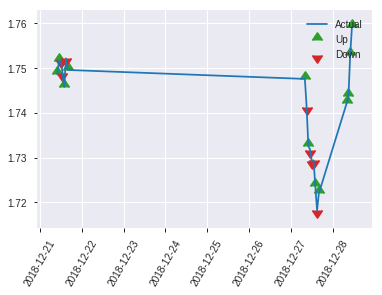


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2094713403715636
RMSE: 0.45768039107172115
LogLoss: 0.6055576379820609
Mean Per-Class Error: 0.30759630584907227
AUC: 0.7422414510358599
pr_auc: 0.6753346725820737
Gini: 0.48448290207171985
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20597407221794128: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   66   0.5546   (66.0/119.0)
1      7    94   0.0693   (7.0/101.0)
Total  60   160  0.3318   (73.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.205974     0.720307  159
max f2                       0.192009     0.84063   166
max f0point5                 0.618651     0.648855  72
max accuracy                 0.298694     0.681818  134
max precision                0.910125     1         0
max recall                   0.0538115    1         216
max specificity              0.910125     1         0
max absolute_mcc             0.205974     0.420793  159
max min_per_class_accuracy   0.484246     0.643564  106
max mean_per_class_accuracy  0.298694     0.692404  134

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 44.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0136364                   0.851905           2.17822   2.17822            1                0.877837   1                           0.877837            0.029703        0.029703                   117.822    117.822
    2        0.0227273                   0.846751           2.17822   2.17822            1                0.85005    1                           0.866722            0.019802        0.049505                   117.822    117.822
    3        0.0318182                   0.834799           1.08911   1.86704            0.5              0.840431   0.857143                    0.85921             0.00990099      0.0594059                  8.91089    86.7044
    4        0.0409091                   0.830725           2.17822   1.93619            1                0.83168    0.888889                    0.853092            0.019802        0.0792079                  117.822    93.6194
    5        0.05                        0.824453           0         1.58416            0                0.828061   0.727273                    0.848541            0               0.0792079                  -100       58.4158
    6        0.1                         0.770821           1.58416   1.58416            0.727273         0.795296   0.727273                    0.821919            0.0792079       0.158416                   58.4158    58.4158
    7        0.15                        0.737692           1.58416   1.58416            0.727273         0.755438   0.727273                    0.799759            0.0792079       0.237624                   58.4158    58.4158
    8        0.2                         0.704115           1.78218   1.63366            0.818182         0.724287   0.75                        0.780891            0.0891089       0.326733                   78.2178    63.3663
    9        0.3                         0.636157           1.18812   1.48515            0.545455         0.671777   0.681818                    0.74452             0.118812        0.445545                   18.8119    48.5149
    10       0.4                         0.565363           1.28713   1.43564            0.590909         0.603673   0.659091                    0.709308            0.128713        0.574257                   28.7129    43.5644
    11       0.5                         0.474247           0.891089  1.32673            0.409091         0.522496   0.609091                    0.671945            0.0891089       0.663366                   -10.8911   32.6733
    12       0.6                         0.319359           1.38614   1.33663            0.636364         0.399248   0.613636                    0.626496            0.138614        0.80198                    38.6139    33.6634
    13       0.7                         0.227711           0.990099  1.28713            0.454545         0.256561   0.590909                    0.573648            0.0990099       0.90099                    -0.990099  28.7129
    14       0.8                         0.1633             0.49505   1.18812            0.227273         0.195191   0.545455                    0.526341            0.049505        0.950495                   -50.495    18.8119
    15       0.9                         0.0939663          0.29703   1.08911            0.136364         0.123323   0.5                         0.481561            0.029703        0.980198                   -70.297    8.91089
    16       1                           0.0361583          0.19802   1                  0.0909091        0.0702843  0.459091  

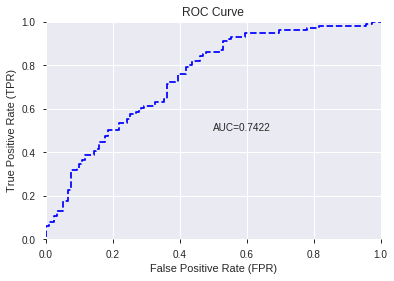

This function is available for GLM models only


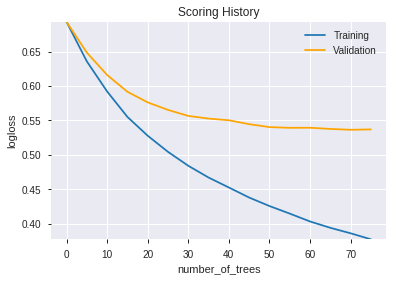

--2019-08-28 13:28:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190828_132808',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190828_132808',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_b106',
   'type

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'CCI_8',
 'DIV',
 'SUB',
 'ULTOSC',
 'STOCHRSI_fastk',
 'STOCH_slowk',
 'Volume',
 'CCI_14',
 'WILLR_24',
 'CCI_12',
 'WILLR_8',
 'WILLR_30',
 'ADOSC',
 'MOM_8',
 'CMO_8',
 'WILLR_12',
 'ROC_8',
 'CMO_14',
 'MOM_12',
 'WILLR_14',
 'CMO_24',
 'CMO_30',
 'STOCHF_fastd',
 'CDLCLOSINGMARUBOZU',
 'CMO_12',
 'WILLR_20',
 'CMO_20',
 'ROCP_8',
 'CDLHAMMER',
 'RSI_12',
 'RSI_24',
 'RSI_30',
 'CDLSHORTLINE',
 'RSI_14',
 'ROCR_8',
 'RSI_8',
 'RSI_20',
 'ROCR100_8',
 'CDLBELTHOLD',
 'CDLENGULFING',
 'CDLLONGLINE']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

74

['BBANDS_upperband_20_0_5',
 'BBANDS_upperband_20_1_3',
 'BBANDS_upperband_20_1_4',
 'BBANDS_upperband_20_2_3',
 'BBANDS_upperband_20_6_5',
 'BBANDS_middleband_24_0_5',
 'BBANDS_upperband_24_5_3',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_lowerband_24_7_5',
 'BBANDS_upperband_30_1_5',
 'BBANDS_lowerband_30_2_2',
 'BBANDS_upperband_30_5_5',
 'BOP',
 'aroondown_8',
 'DX_8',
 'MINUS_DM_8',
 'ROC_8',
 'ROCR100_8',
 'WILLR_8',
 'MOM_12',
 'PLUS_DM_12',
 'ROCR100_12',
 'CCI_14',
 'DX_14',
 'MACDFIX_hist_14',
 'MFI_14',
 'PLUS_DI_14',
 'ROCP_14',
 'ADX_20',
 'aroondown_20',
 'aroonup_20',
 'DX_20',
 'MACDFIX_signal_20',
 'ROCR_20',
 'RSI_20',
 'WILLR_20',
 'ADX_24',
 'AROONOSC_24',
 'CCI_24',
 'DX_24',
 'MFI_24',
 'MINUS_DM_24',
 'PLUS_DM_24',
 'ROCR100_24',
 'MFI_30',
 'MINUS_DI_30',
 'MINUS_DM_30',
 'WILLR_30',
 'MACD_signal',
 'MACD_hist',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ADOSC',
 'ATR_8',
 'ATR_24',
 'TRANGE',
 'HT_DCPERIOD',
 'HT_PHASOR

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_132937  0.735253  0.663879              0.298444  0.463594  0.214919
1  DeepLearning_grid_1_AutoML_20190828_132937_model_5  0.729761  0.647420              0.313753  0.458114  0.209868
2  DeepLearning_grid_1_AutoML_20190828_132937_model_6  0.728097  0.615976              0.324112  0.458639  0.210350
3  DeepLearning_grid_1_AutoML_20190828_132937_model_4  0.725851  0.937990              0.333722  0.510961  0.261081
4  DeepLearning_grid_1_AutoML_20190828_132937_model_7  0.710292  0.675717              0.343623  0.475927  0.226507
5  DeepLearning_grid_1_AutoML_20190828_132937_model_1  0.707214  1.022471              0.313587  0.503386  0.253397
6  DeepLearning_grid_1_AutoML_20190828_132937_model_8  0.707214  0.623869              0.353981  0.465756  0.216928
7  DeepLearning_grid_1_AutoML_20190828_132937_model_9  0.704468  0.645335              0.338672  0.470805  0.221657
8  DeepLearning_grid_1_AutoML_20190828_132937_model_3  0.697729  0.732907              0.350820  0.481907  0.232235
9  DeepLearning_grid_1_AutoML_20190828_132937_model_2  0.685082  0.758206              0.343914  0.503358  0.253370

variable  relative_importance  scaled_importance  percentage
0       ADX_20             1.000000           1.000000    0.019717
1          BOP             0.994755           0.994755    0.019613
2         DX_8             0.984819           0.984819    0.019417
3       MFI_14             0.947402           0.947402    0.018680
4     STDDEV_8             0.937366           0.937366    0.018482
..         ...                  ...                ...         ...
69      ADX_24             0.504316           0.504316    0.009943
70      BETA_8             0.496928           0.496928    0.009798
71  ROCR100_24             0.469208           0.469208    0.009251
72      MFI_30             0.466022           0.466022    0.009188
73       ROC_8             0.457988           0.457988    0.009030

[74 rows x 4 columns]

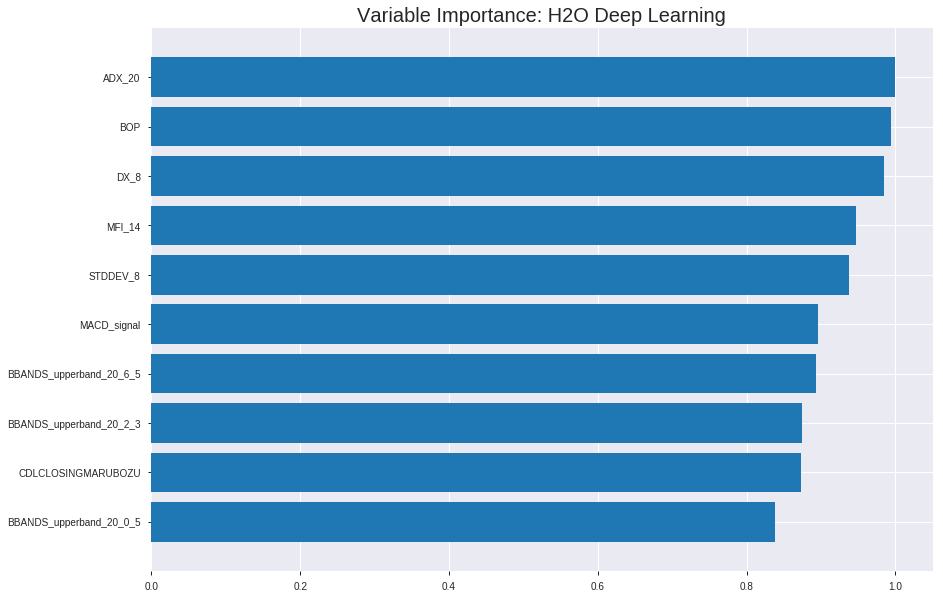

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_132937


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19612861776324422
RMSE: 0.4428641075581134
LogLoss: 0.571650586026628
Mean Per-Class Error: 0.27279511533242884
AUC: 0.7975966757123473
pr_auc: 0.7560529655360216
Gini: 0.5951933514246945
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2142281593372204: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      419  381   0.4763   (381.0/800.0)
1      77   660   0.1045   (77.0/737.0)
Total  496  1041  0.298    (458.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.214228     0.742407  293
max f2                       0.13899      0.855153  332
max f0point5                 0.405386     0.7126    200
max accuracy                 0.331319     0.72609   235
max precision                0.976042     1         0
max recall                   0.00160226   1         398
max specificity              0.976042     1         0
max absolute_mcc             0.331319     0.454319  235
max min_per_class_accuracy   0.354554     0.717775  224
max mean_per_class_accuracy  0.331319     0.727205  235

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 38.02 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.924206           2.08548    2.08548            1                0.944325   1                           0.944325            0.0217096       0.0217096                  108.548   108.548
    2        0.0201692                   0.898576           1.66839    1.88366            0.8              0.909365   0.903226                    0.927409            0.0162822       0.0379919                  66.8385   88.3661
    3        0.0305791                   0.864154           1.43377    1.73051            0.6875           0.882366   0.829787                    0.912075            0.0149254       0.0529172                  43.3769   73.0506
    4        0.0403383                   0.84558            1.66839    1.71548            0.8              0.855798   0.822581                    0.89846             0.0162822       0.0691995                  66.8385   71.5477
    5        0.0500976                   0.829849           1.80742    1.73339            0.866667         0.836357   0.831169                    0.886362            0.0176391       0.0868385                  80.7417   73.3387
    6        0.100195                    0.755808           1.73339    1.73339            0.831169         0.796526   0.831169                    0.841444            0.0868385       0.173677                   73.3387   73.3387
    7        0.150293                    0.691369           1.76047    1.74242            0.844156         0.720316   0.835498                    0.801068            0.0881954       0.261872                   76.0472   74.2415
    8        0.20039                     0.621825           1.59797    1.7063             0.766234         0.659578   0.818182                    0.765695            0.0800543       0.341927                   59.7966   70.6303
    9        0.299935                    0.524971           1.44484    1.61953            0.69281          0.56874    0.776573                    0.700328            0.143826        0.485753                   44.4844   61.9528
    10       0.40013                     0.434381           1.24587    1.52596            0.597403         0.477982   0.731707                    0.644651            0.12483         0.610583                   24.5872   52.5962
    11       0.500325                    0.346918           1.21879    1.46445            0.584416         0.386648   0.702211                    0.592983            0.122117        0.7327                     21.8788   46.4447
    12       0.59987                     0.275244           0.91325    1.37298            0.437908         0.310589   0.658351                    0.546122            0.0909091       0.823609                   -8.67499  37.298
    13       0.700065                    0.198421           0.826067   1.2947             0.396104         0.234711   0.620818                    0.501552            0.082768        0.906377                   -17.3933  29.4704
    14       0.79961                     0.131298           0.599746   1.20819            0.287582         0.164673   0.579333                    0.459613            0.0597015       0.966079                   -40.0254  20.8188
    15       0.899805                    0.0606366          0.2573     1.1023             0.123377         0.098981   0.528561                    0.419456            0.0257802       0.991859                   -74.27    10.2304
    16       1                           0.000126156        0.0812525  1                  0.038961         0.0277672  0.479506  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22383072965427195
RMSE: 0.4731075244109651
LogLoss: 0.6609582208271476
Mean Per-Class Error: 0.29797917183238287
AUC: 0.7460533928423836
pr_auc: 0.735061289729137
Gini: 0.4921067856847672
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30454834145537935: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      139  79   0.3624   (79.0/218.0)
1      53   169  0.2387   (53.0/222.0)
Total  192  248  0.3      (132.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.304548     0.719149  227
max f2                       0.0708599    0.851648  354
max f0point5                 0.324748     0.701906  215
max accuracy                 0.324748     0.702273  215
max precision                0.945196     1         0
max recall                   0.00872428   1         390
max specificity              0.945196     1         0
max absolute_mcc             0.324748     0.404732  215
max min_per_class_accuracy   0.352517     0.692661  204
max mean_per_class_accuracy  0.324748     0.702021  215

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 37.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.897032           1.98198   1.98198            1                0.924402   1                           0.924402            0.0225225       0.0225225                  98.1982   98.1982
    2        0.0204545                   0.884111           1.98198   1.98198            1                0.890004   1                           0.909114            0.018018        0.0405405                  98.1982   98.1982
    3        0.0318182                   0.871814           1.18919   1.69884            0.6              0.878362   0.857143                    0.898131            0.0135135       0.0540541                  18.9189   69.8842
    4        0.0409091                   0.848752           1.48649   1.65165            0.75             0.859111   0.833333                    0.88946             0.0135135       0.0675676                  48.6486   65.1652
    5        0.05                        0.840426           1.98198   1.71171            1                0.845367   0.863636                    0.881443            0.018018        0.0855856                  98.1982   71.1712
    6        0.1                         0.76425            1.62162   1.66667            0.818182         0.800658   0.840909                    0.84105             0.0810811       0.166667                   62.1622   66.6667
    7        0.15                        0.701497           1.53153   1.62162            0.772727         0.732684   0.818182                    0.804928            0.0765766       0.243243                   53.1532   62.1622
    8        0.2                         0.645117           1.44144   1.57658            0.727273         0.679042   0.795455                    0.773457            0.0720721       0.315315                   44.1441   57.6577
    9        0.3                         0.532245           1.30631   1.48649            0.659091         0.589059   0.75                        0.711991            0.130631        0.445946                   30.6306   48.6486
    10       0.4                         0.435692           1.30631   1.44144            0.659091         0.487408   0.727273                    0.655845            0.130631        0.576577                   30.6306   44.1441
    11       0.5                         0.356159           1.12613   1.37838            0.568182         0.399495   0.695455                    0.604575            0.112613        0.689189                   12.6126   37.8378
    12       0.6                         0.264409           0.945946  1.30631            0.477273         0.309387   0.659091                    0.555377            0.0945946       0.783784                   -5.40541  30.6306
    13       0.7                         0.16878            0.540541  1.19691            0.272727         0.20815    0.603896                    0.505773            0.0540541       0.837838                   -45.9459  19.6911
    14       0.8                         0.103684           0.765766  1.14302            0.386364         0.135018   0.576705                    0.459429            0.0765766       0.914414                   -23.4234  14.3018
    15       0.9                         0.0595185          0.630631  1.08609            0.318182         0.0823104  0.54798                     0.417527            0.0630631       0.977477                   -36.9369  8.60861
    16       1                           2.26867e-05        0.225225  1                  0.113636         0.029037   0.504545                   


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:29:38  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:29:38  0.068 sec   80894 obs/sec     1         1             1537       0.524129         0.817769            -0.100693      0.630555        0.594714           1.43377          0.469746                         0.513015           0.827073              -0.0528256       0.663092          0.67695              1.98198            0.388636
    2019-08-28 13:29:38  0.277 sec   73894 obs/sec     10        10            15370      0.442864         0.571651            0.214165       0.797597        0.756053           2.08548          0.297983                         0.473108           0.660958              0.104603         0.746053          0.735061             1.98198            0.3

Variable Importances: 


variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  --------------------
ADX_20      1.0                    1.0                  0.019716812143790338
BOP         0.9947553277015686     0.9947553277015686   0.019613403925326425
DX_8        0.9848189353942871     0.9848189353942871   0.019417489944816752
MFI_14      0.947401762008667      0.947401762008667    0.01867974256622085
STDDEV_8    0.9373660087585449     0.9373660087585449   0.01848186950466676
---         ---                    ---                  ---
ADX_24      0.5043157935142517     0.5043157935142517   0.009943499761867059
BETA_8      0.49692803621292114    0.49692803621292114  0.009797836738992809
ROCR100_24  0.4692084789276123     0.4692084789276123   0.009251295435289339
MFI_30      0.46602216362953186    0.46602216362953186  0.009188471455126202
ROC_8       0.4579881727695465     0.4579881727695465   0.009030066766574942


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6954545454545454)

('F1', 0.711864406779661)

('auc', 0.7352525168483235)

('logloss', 0.663878971001482)

('mean_per_class_error', 0.29574007820950166)

('rmse', 0.4635937811842492)

('mse', 0.21491919395270956)

deeplearning prediction progress: |███████████████████████████████████████| 100%


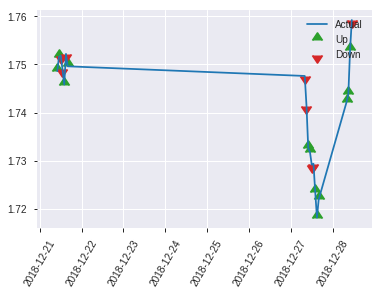


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21491919395270956
RMSE: 0.4635937811842492
LogLoss: 0.663878971001482
Mean Per-Class Error: 0.29574007820950166
AUC: 0.7352525168483235
pr_auc: 0.6854190297992147
Gini: 0.470505033696647
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.261193628857087: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   51   0.4286   (51.0/119.0)
1      17   84   0.1683   (17.0/101.0)
Total  85   135  0.3091   (68.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.261194     0.711864  134
max f2                       0.0133627    0.813008  210
max f0point5                 0.599958     0.668693  56
max accuracy                 0.275766     0.695455  129
max precision                0.942608     1         0
max recall                   0.00146771   1         218
max specificity              0.942608     1         0
max absolute_mcc             0.275766     0.414052  129
max min_per_class_accuracy   0.412544     0.663866  107
max mean_per_class_accuracy  0.275766     0.70426   129

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 38.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0136364                   0.929063           2.17822   2.17822            1                0.938961   1                           0.938961            0.029703        0.029703                   117.822    117.822
    2        0.0227273                   0.89636            2.17822   2.17822            1                0.906914   1                           0.926142            0.019802        0.049505                   117.822    117.822
    3        0.0318182                   0.877796           1.08911   1.86704            0.5              0.889971   0.857143                    0.915807            0.00990099      0.0594059                  8.91089    86.7044
    4        0.0409091                   0.848878           1.08911   1.69417            0.5              0.867618   0.777778                    0.905099            0.00990099      0.0693069                  8.91089    69.4169
    5        0.05                        0.836697           2.17822   1.78218            1                0.84353    0.818182                    0.893904            0.019802        0.0891089                  117.822    78.2178
    6        0.1                         0.766606           1.38614   1.58416            0.636364         0.795394   0.727273                    0.844649            0.0693069       0.158416                   38.6139    58.4158
    7        0.15                        0.714975           2.17822   1.78218            1                0.747055   0.818182                    0.812118            0.108911        0.267327                   117.822    78.2178
    8        0.2                         0.655627           1.38614   1.68317            0.636364         0.681015   0.772727                    0.779342            0.0693069       0.336634                   38.6139    68.3168
    9        0.3                         0.557563           1.28713   1.55116            0.590909         0.605752   0.712121                    0.721479            0.128713        0.465347                   28.7129    55.1155
    10       0.4                         0.478253           1.08911   1.43564            0.5              0.51151    0.659091                    0.668987            0.108911        0.574257                   8.91089    43.5644
    11       0.5                         0.393233           0.990099  1.34653            0.454545         0.445568   0.618182                    0.624303            0.0990099       0.673267                   -0.990099  34.6535
    12       0.6                         0.264529           1.38614   1.35314            0.636364         0.318895   0.621212                    0.573402            0.138614        0.811881                   38.6139    35.3135
    13       0.7                         0.174057           0.693069  1.25884            0.318182         0.221622   0.577922                    0.523147            0.0693069       0.881188                   -30.6931   25.884
    14       0.8                         0.100608           0.19802   1.12624            0.0909091        0.138027   0.517045                    0.475007            0.019802        0.90099                    -80.198    12.6238
    15       0.9                         0.0440217          0.49505   1.05611            0.227273         0.0751555  0.484848                    0.430579            0.049505        0.950495                   -50.495    5.61056
    16       1                           0.000579008        0.49505   1                  0.227273         0.0169187  0.459091   

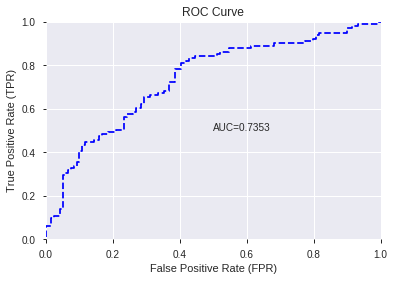

This function is available for GLM models only


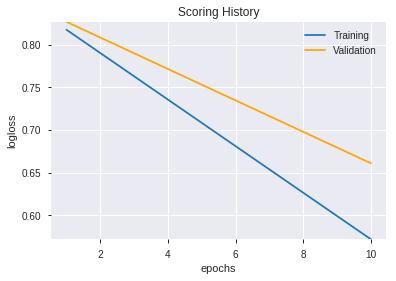

--2019-08-28 13:36:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_132937',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_132937',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_98_sid_b106'

['ADX_20',
 'BOP',
 'DX_8',
 'MFI_14',
 'STDDEV_8',
 'MACD_signal',
 'BBANDS_upperband_20_6_5',
 'BBANDS_upperband_20_2_3',
 'CDLCLOSINGMARUBOZU',
 'BBANDS_upperband_20_0_5',
 'MINUS_DM_8',
 'PLUS_DM_12',
 'MOM_12',
 'DX_20',
 'BBANDS_lowerband_30_2_2',
 'TRANGE',
 'BBANDS_middleband_24_0_5',
 'WILLR_30',
 'MACDFIX_hist_14',
 'WILLR_8',
 'LINEARREG_ANGLE_8',
 'CORREL_8',
 'CCI_14',
 'ROCR100_12',
 'HT_DCPERIOD',
 'DX_24',
 'VAR_8',
 'CORREL_12',
 'MACDFIX_signal_20',
 'LINEARREG_SLOPE_12',
 'BBANDS_upperband_20_1_4',
 'ATR_24',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_upperband_30_1_5',
 'MINUS_DM_24',
 'ROCR100_8',
 'aroondown_20',
 'ROCP_14',
 'aroondown_8',
 'BBANDS_upperband_30_5_5',
 'CDLENGULFING',
 'WILLR_20',
 'BBANDS_lowerband_24_7_5',
 'MFI_24',
 'ROCR_20',
 'ADOSC',
 'BBANDS_upperband_20_1_3',
 'BBANDS_upperband_24_5_3',
 'MACD_hist',
 'CDLDOJI',
 'STOCHF_fastd',
 'STOCHRSI_fastd',
 'RSI_20',
 'STOCH_slowk',
 'STDDEV_12',
 'PLUS_DI_14',
 'ATR_8',
 'aroonup_20',
 'STOCHRSI_fastk'

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_133634_model_1  0.723937  0.615236              0.324112  0.461014  0.212534

variable  relative_importance  scaled_importance  percentage
0            BOP             0.646907           1.000000    0.081897
1         TRANGE             0.478507           0.739684    0.060578
2   STOCHF_fastk             0.392407           0.606590    0.049678
3          ATR_8             0.300201           0.464056    0.038005
4       WILLR_30             0.298276           0.461080    0.037761
..           ...                  ...                ...         ...
69   MACD_signal             0.008124           0.012558    0.001028
70        MFI_14             0.005534           0.008554    0.000701
71  CDLSHORTLINE             0.001966           0.003039    0.000249
72   HT_DCPERIOD             0.001468           0.002270    0.000186
73        MFI_24             0.000533           0.000823    0.000067

[74 rows x 4 columns]

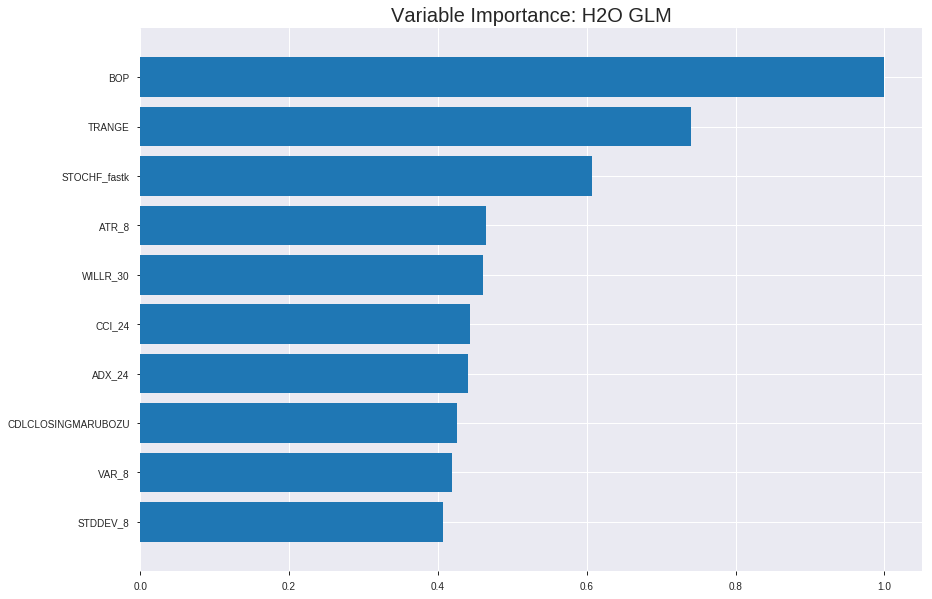

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_133634_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18903696913238105
RMSE: 0.43478381884838013
LogLoss: 0.5580051406855163
Null degrees of freedom: 1536
Residual degrees of freedom: 1462
Null deviance: 2128.1514062818787
Residual deviance: 1715.3078024672773
AIC: 1865.3078024672773
AUC: 0.7853671981004071
pr_auc: 0.7452365406096632
Gini: 0.5707343962008142
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39506080144753: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      450  350  0.4375   (350.0/800.0)
1      116  621  0.1574   (116.0/737.0)
Total  566  971  0.3032   (466.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395061     0.727166  242
max f2                       0.218704     0.845371  320
max f0point5                 0.588736     0.710808  153
max accuracy                 0.545973     0.712427  173
max precision                0.955485     1         0
max recall                   0.0256531    1         395
max specificity              0.955485     1         0
max absolute_mcc             0.446464     0.430753  220
max min_per_class_accuracy   0.513249     0.708277  189
max mean_per_class_accuracy  0.446464     0.713594  220

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 47.95 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.912346           1.8248     1.8248             0.875            0.92898    0.875                       0.92898             0.0189959       0.0189959                  82.4796   82.4796
    2        0.0201692                   0.896496           1.66839    1.74911            0.8              0.904686   0.83871                     0.917225            0.0162822       0.0352782                  66.8385   74.9114
    3        0.0305791                   0.883967           2.08548    1.86362            1                0.890753   0.893617                    0.908213            0.0217096       0.0569878                  108.548   86.3622
    4        0.0403383                   0.864382           1.66839    1.81639            0.8              0.873566   0.870968                    0.899831            0.0162822       0.07327                    66.8385   81.6387
    5        0.0500976                   0.837964           1.52935    1.76047            0.733333         0.847095   0.844156                    0.889558            0.0149254       0.0881954                  52.9353   76.0472
    6        0.100195                    0.774328           1.76047    1.76047            0.844156         0.80489    0.844156                    0.847224            0.0881954       0.176391                   76.0472   76.0472
    7        0.150293                    0.729897           1.59797    1.7063             0.766234         0.749592   0.818182                    0.81468             0.0800543       0.256445                   59.7966   70.6303
    8        0.20039                     0.69911            1.65213    1.69276            0.792208         0.714531   0.811688                    0.789643            0.082768        0.339213                   65.2135   69.2761
    9        0.299935                    0.633856           1.44484    1.61048            0.69281          0.664491   0.772234                    0.748106            0.143826        0.483039                   44.4844   61.048
    10       0.40013                     0.576078           1.27296    1.52596            0.61039          0.606226   0.731707                    0.712579            0.127544        0.610583                   27.2956   52.5962
    11       0.500325                    0.506468           1.05628    1.4319             0.506494         0.541161   0.686606                    0.67825             0.105834        0.716418                   5.62829   43.1904
    12       0.59987                     0.420611           0.981403   1.35715            0.470588         0.462673   0.650759                    0.642477            0.0976934       0.814111                   -1.85969  35.7146
    13       0.700065                    0.333885           0.771899   1.27338            0.37013          0.378136   0.610595                    0.604644            0.0773406       0.891452                   -22.8101  27.3384
    14       0.79961                     0.245439           0.586116   1.18783            0.281046         0.290967   0.569569                    0.565594            0.0583446       0.949796                   -41.3884  18.7825
    15       0.899805                    0.134653           0.406263   1.1008             0.194805         0.193153   0.527838                    0.524122            0.0407056       0.990502                   -59.3737  10.0797
    16       1                           0.00725265         0.0947946  1                  0.0454545        0.0788306  0.479506  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18280199744581455
RMSE: 0.42755350243661266
LogLoss: 0.5432227673876897
Null degrees of freedom: 439
Residual degrees of freedom: 365
Null deviance: 611.0374769186825
Residual deviance: 478.0360353011669
AIC: 628.036035301167
AUC: 0.8019671047193982
pr_auc: 0.7887016406528484
Gini: 0.6039342094387965
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3705677128686258: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      123  95   0.4358   (95.0/218.0)
1      27   195  0.1216   (27.0/222.0)
Total  150  290  0.2773   (122.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.370568     0.761719  263
max f2                       0.136782     0.860173  351
max f0point5                 0.587397     0.74295   157
max accuracy                 0.547507     0.729545  182
max precision                0.940992     1         0
max recall                   0.0534691    1         386
max specificity              0.940992     1         0
max absolute_mcc             0.370568     0.466842  263
max min_per_class_accuracy   0.51696      0.715596  201
max mean_per_class_accuracy  0.547507     0.729957  182

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 48.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113636                   0.905105           1.98198   1.98198            1                0.917678   1                           0.917678            0.0225225       0.0225225                  98.1982    98.1982
    2        0.0204545                   0.890208           1.98198   1.98198            1                0.899307   1                           0.909513            0.018018        0.0405405                  98.1982    98.1982
    3        0.0318182                   0.885924           1.98198   1.98198            1                0.888483   1                           0.902002            0.0225225       0.0630631                  98.1982    98.1982
    4        0.0409091                   0.871363           0.990991  1.76176            0.5              0.879802   0.888889                    0.897069            0.00900901      0.0720721                  -0.900901  76.1762
    5        0.05                        0.856883           1.98198   1.8018             1                0.865715   0.909091                    0.891368            0.018018        0.0900901                  98.1982    80.1802
    6        0.1                         0.786546           1.62162   1.71171            0.818182         0.810847   0.863636                    0.851108            0.0810811       0.171171                   62.1622    71.1712
    7        0.15                        0.740638           1.8018    1.74174            0.909091         0.762753   0.878788                    0.821656            0.0900901       0.261261                   80.1802    74.1742
    8        0.2                         0.71051            1.44144   1.66667            0.727273         0.726985   0.840909                    0.797989            0.0720721       0.333333                   44.1441    66.6667
    9        0.3                         0.639586           1.44144   1.59159            0.727273         0.673059   0.80303                     0.756346            0.144144        0.477477                   44.1441    59.1592
    10       0.4                         0.585439           1.3964    1.54279            0.704545         0.612069   0.778409                    0.720276            0.13964         0.617117                   39.6396    54.2793
    11       0.5                         0.517231           0.945946  1.42342            0.477273         0.552716   0.718182                    0.686764            0.0945946       0.711712                   -5.40541   42.3423
    12       0.6                         0.4372             1.03604   1.35886            0.522727         0.472896   0.685606                    0.65112             0.103604        0.815315                   3.6036     35.8859
    13       0.7                         0.340674           0.810811  1.28057            0.409091         0.384532   0.646104                    0.613036            0.0810811       0.896396                   -18.9189   28.0566
    14       0.8                         0.234305           0.495495  1.18243            0.25             0.288469   0.596591                    0.572465            0.0495495       0.945946                   -50.4505   18.2432
    15       0.9                         0.129068           0.405405  1.0961             0.204545         0.171414   0.55303                     0.527904            0.0405405       0.986486                   -59.4595   9.60961
    16       1                           0.00577389         0.135135  1                  0.0681818        0.0769009  0.504545  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 13:36:34  0.000 sec   2            .21E2     74            1.3687122072962445  1.3719372086367745
     2019-08-28 13:36:34  0.014 sec   4            .13E2     75            1.3609037374634725  1.3636833055421576
     2019-08-28 13:36:34  0.026 sec   6            .82E1     75            1.350118481666218   1.3522244331138018
     2019-08-28 13:36:34  0.038 sec   8            .51E1     75            1.335780801260202   1.3368899748889702
     2019-08-28 13:36:34  0.050 sec   10           .31E1     75            1.3173885110401213  1.3169850851328297
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 13:36:35  0.223 sec   38           .4E-2     75            1.1130575455121294  1.087434885691418
     2019-08-28 13:36:35  0.235 sec   40           .25E-2    75            1.1105827133138098  1.0894567393690722
     2019-08-28 13:36:35  0.251 sec   42           .15E-2    75            1.1085552820235074  1.0921667199475353
     2019-08-28 13:36:35  0.266 sec   44           .96E-3    75            1.1069371063133269  1.0953957043355727
     2019-08-28 13:36:35  0.278 sec   46           .59E-3    75            1.105682175890761   1.0988655197639217


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6772727272727272)

('F1', 0.7035573122529644)

('auc', 0.7239370995923121)

('logloss', 0.6152357144913526)

('mean_per_class_error', 0.31824611032531824)

('rmse', 0.46101368429383516)

('mse', 0.2125336171061759)

glm prediction progress: |████████████████████████████████████████████████| 100%


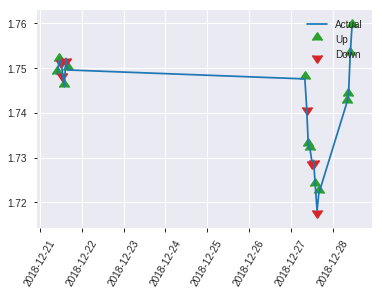


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2125336171061759
RMSE: 0.46101368429383516
LogLoss: 0.6152357144913526
Null degrees of freedom: 219
Residual degrees of freedom: 145
Null deviance: 303.8782617497692
Residual deviance: 270.70371437619514
AIC: 420.70371437619514
AUC: 0.7239370995923121
pr_auc: 0.673003515978106
Gini: 0.44787419918462423
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32262619613321736: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   63   0.5294   (63.0/119.0)
1      12   89   0.1188   (12.0/101.0)
Total  68   152  0.3409   (75.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.322626     0.703557  151
max f2                       0.0628042    0.817152  213
max f0point5                 0.577032     0.652681  81
max accuracy                 0.577032     0.677273  81
max precision                0.909034     1         0
max recall                   0.0628042    1         213
max specificity              0.909034     1         0
max absolute_mcc             0.322626     0.379336  151
max min_per_class_accuracy   0.491573     0.647059  107
max mean_per_class_accuracy  0.396042     0.681754  130

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 46.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0136364                   0.878064           2.17822   2.17822            1                0.889271   1                           0.889271            0.029703        0.029703                   117.822    117.822
    2        0.0227273                   0.86835            2.17822   2.17822            1                0.871837   1                           0.882297            0.019802        0.049505                   117.822    117.822
    3        0.0318182                   0.863128           2.17822   2.17822            1                0.865707   1                           0.877557            0.019802        0.0693069                  117.822    117.822
    4        0.0409091                   0.838654           1.08911   1.93619            0.5              0.854936   0.888889                    0.87253             0.00990099      0.0792079                  8.91089    93.6194
    5        0.05                        0.835258           1.08911   1.78218            0.5              0.835693   0.818182                    0.865833            0.00990099      0.0891089                  8.91089    78.2178
    6        0.1                         0.760443           1.58416   1.68317            0.727273         0.798998   0.772727                    0.832415            0.0792079       0.168317                   58.4158    68.3168
    7        0.15                        0.71944            1.78218   1.71617            0.818182         0.740503   0.787879                    0.801778            0.0891089       0.257426                   78.2178    71.6172
    8        0.2                         0.693605           1.18812   1.58416            0.545455         0.708646   0.727273                    0.778495            0.0594059       0.316832                   18.8119    58.4158
    9        0.3                         0.626137           1.18812   1.45215            0.545455         0.657548   0.666667                    0.738179            0.118812        0.435644                   18.8119    45.2145
    10       0.4                         0.55106            1.28713   1.41089            0.590909         0.592494   0.647727                    0.701758            0.128713        0.564356                   28.7129    41.0891
    11       0.5                         0.486173           0.990099  1.32673            0.454545         0.522832   0.609091                    0.665973            0.0990099       0.663366                   -0.990099  32.6733
    12       0.6                         0.393864           1.28713   1.32013            0.590909         0.444381   0.606061                    0.629041            0.128713        0.792079                   28.7129    32.0132
    13       0.7                         0.311586           0.891089  1.25884            0.409091         0.345364   0.577922                    0.588515            0.0891089       0.881188                   -10.8911   25.884
    14       0.8                         0.211082           0.19802   1.12624            0.0909091        0.251888   0.517045                    0.546437            0.019802        0.90099                    -80.198    12.6238
    15       0.9                         0.13259            0.594059  1.06711            0.272727         0.173582   0.489899                    0.505009            0.0594059       0.960396                   -40.5941   6.71067
    16       1                           0.0142743          0.39604   1                  0.181818         0.0725608  0.459091   

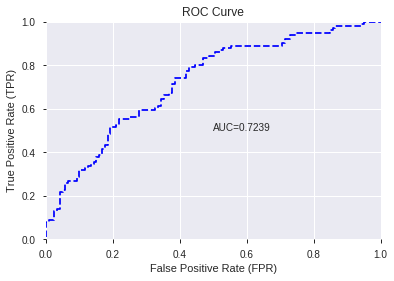

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


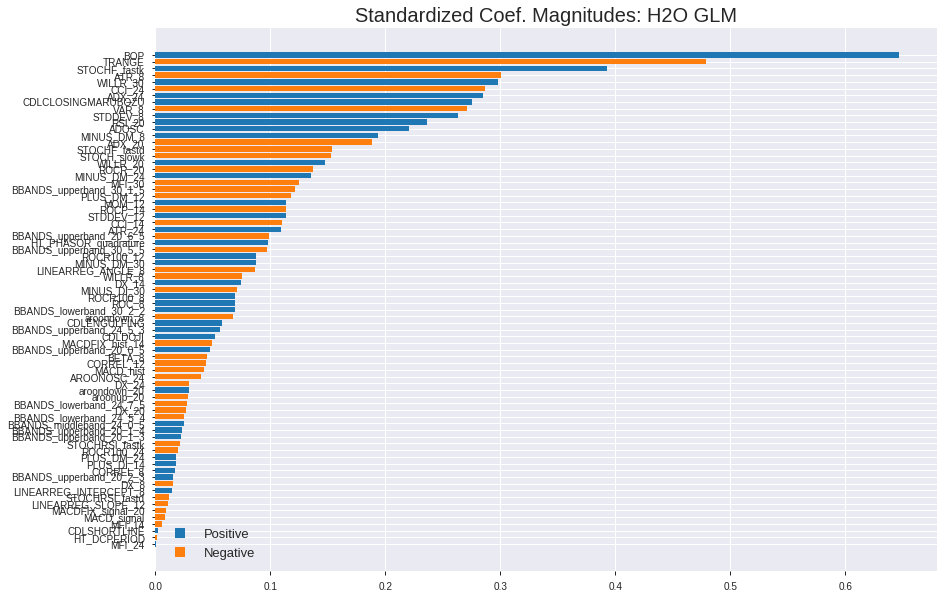

'log_likelihood'
--2019-08-28 13:36:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_133634_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_133634_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'ATR_8',
 'WILLR_30',
 'CCI_24',
 'ADX_24',
 'CDLCLOSINGMARUBOZU',
 'VAR_8',
 'STDDEV_8',
 'RSI_20',
 'ADOSC',
 'MINUS_DM_8',
 'ADX_20',
 'STOCHF_fastd',
 'STOCH_slowk',
 'WILLR_20',
 'ROCR_20',
 'MINUS_DM_24',
 'MFI_30',
 'BBANDS_upperband_30_1_5',
 'PLUS_DM_12',
 'MOM_12',
 'ROCP_14',
 'STDDEV_12',
 'CCI_14',
 'ATR_24',
 'BBANDS_upperband_20_6_5',
 'HT_PHASOR_quadrature',
 'BBANDS_upperband_30_5_5',
 'ROCR100_12',
 'MINUS_DM_30',
 'LINEARREG_ANGLE_8',
 'WILLR_8',
 'DX_14',
 'MINUS_DI_30',
 'ROCR100_8',
 'ROC_8',
 'BBANDS_lowerband_30_2_2',
 'aroondown_8',
 'CDLENGULFING',
 'BBANDS_upperband_24_5_3',
 'CDLDOJI',
 'MACDFIX_hist_14',
 'BBANDS_upperband_20_0_5',
 'BETA_8',
 'CORREL_12',
 'MACD_hist',
 'AROONOSC_24',
 'DX_24',
 'aroondown_20',
 'aroonup_20',
 'BBANDS_lowerband_24_7_5',
 'DX_20',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_middleband_24_0_5',
 'BBANDS_upperband_20_1_4',
 'BBANDS_upperband_20_1_3',
 'STOCHRSI_fastk',
 'ROCR100_24',
 'PLUS_DM_24

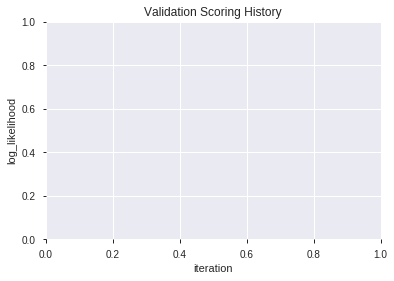

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_133650_model_6  0.754971  0.584449              0.323821  0.446830  0.199657
1  XGBoost_grid_1_AutoML_20190828_133650_model_3  0.740661  0.599132              0.321865  0.454284  0.206374
2  XGBoost_grid_1_AutoML_20190828_133650_model_4  0.738664  0.599111              0.328022  0.455265  0.207267
3               XGBoost_2_AutoML_20190828_133650  0.736085  0.596150              0.301606  0.454283  0.206373
4               XGBoost_1_AutoML_20190828_133650  0.732340  0.602658              0.363591  0.457379  0.209196
5  XGBoost_grid_1_AutoML_20190828_133650_model_2  0.730760  0.604680              0.339421  0.457760  0.209545
6  XGBoost_grid_1_AutoML_20190828_133650_model_1  0.730344  0.604129              0.329062  0.456602  0.208485
7               XGBoost_3_AutoML_20190828_133650  0.730260  0.605562              0.371994  0.458043  0.209804
8  XGBoost_grid_1_AutoML_20190828_133650_model_7  0.727598  0.604303              0.328314  0.457662  0.209454
9  XGBoost_grid_1_AutoML_20190828_133650_model_5  0.726017  0.611577              0.309260  0.460067  0.211661

variable  relative_importance  scaled_importance  percentage
0                       BOP          2058.779053           1.000000    0.197172
1                    TRANGE           963.557983           0.468024    0.092281
2              STOCHF_fastk           468.786255           0.227701    0.044896
3               HT_DCPERIOD           203.404175           0.098798    0.019480
4                    MFI_30           196.460312           0.095426    0.018815
..                      ...                  ...                ...         ...
68              aroondown_8            28.491346           0.013839    0.002729
69                    VAR_8            22.166746           0.010767    0.002123
70  BBANDS_upperband_20_1_4            19.284615           0.009367    0.001847
71                ROCR100_8            17.298344           0.008402    0.001657
72                  CDLDOJI             6.786699           0.003296    0.000650

[73 rows x 4 columns]

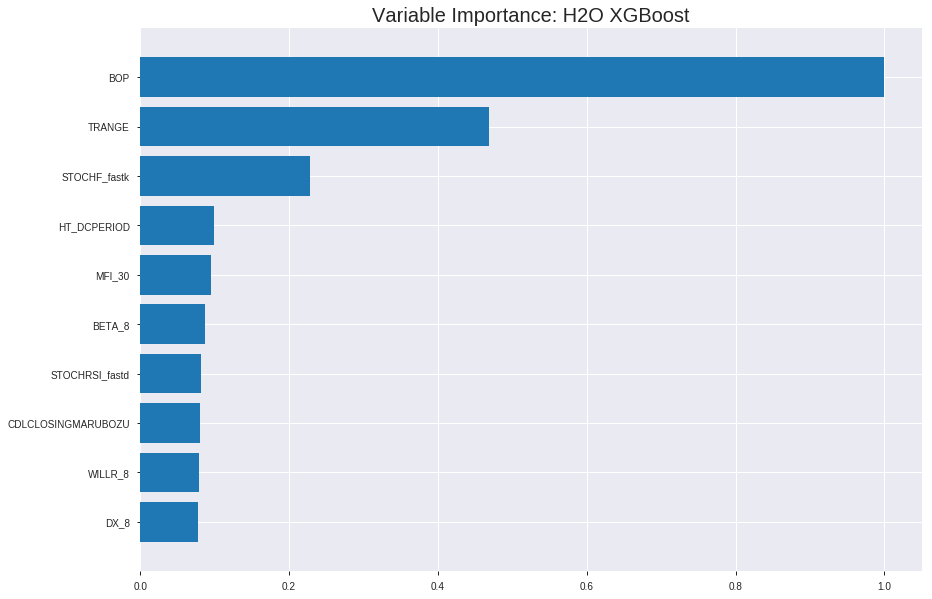

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_133650_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12162437506487152
RMSE: 0.3487468638781882
LogLoss: 0.4009520940511615
Mean Per-Class Error: 0.13268232700135685
AUC: 0.9437720488466758
pr_auc: 0.9427285714897902
Gini: 0.8875440976933515
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5195367137591044: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      693  107  0.1338   (107.0/800.0)
1      97   640  0.1316   (97.0/737.0)
Total  790  747  0.1327   (204.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519537     0.862534  190
max f2                       0.353664     0.903812  263
max f0point5                 0.564821     0.882615  170
max accuracy                 0.519537     0.867274  190
max precision                0.944716     1         0
max recall                   0.149114     1         349
max specificity              0.944716     1         0
max absolute_mcc             0.561837     0.735273  171
max min_per_class_accuracy   0.519537     0.86625   190
max mean_per_class_accuracy  0.519537     0.867318  190

Gains/Lift Table: Avg response rate: 47.95 %, avg score: 48.02 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.907386           2.08548    2.08548            1                0.923427   1                           0.923427            0.0217096       0.0217096                  108.548   108.548
    2        0.0201692                   0.888369           2.08548    2.08548            1                0.899154   1                           0.911682            0.0203528       0.0420624                  108.548   108.548
    3        0.0305791                   0.869779           2.08548    2.08548            1                0.878062   1                           0.900237            0.0217096       0.063772                   108.548   108.548
    4        0.0403383                   0.853087           2.08548    2.08548            1                0.859568   1                           0.890398            0.0203528       0.0841248                  108.548   108.548
    5        0.0500976                   0.84589            2.08548    2.08548            1                0.849121   1                           0.882357            0.0203528       0.104478                   108.548   108.548
    6        0.100195                    0.801566           2.08548    2.08548            1                0.823247   1                           0.852802            0.104478        0.208955                   108.548   108.548
    7        0.150293                    0.764938           2.08548    2.08548            1                0.784041   1                           0.829881            0.104478        0.313433                   108.548   108.548
    8        0.20039                     0.730542           2.08548    2.08548            1                0.750959   1                           0.810151            0.104478        0.41791                    108.548   108.548
    9        0.299935                    0.656651           1.88102    2.01762            0.901961         0.69266    0.967462                    0.771157            0.187246        0.605156                   88.1023   101.762
    10       0.40013                     0.582644           1.57088    1.90576            0.753247         0.622204   0.913821                    0.733858            0.157395        0.762551                   57.0882   90.5757
    11       0.500325                    0.50759            1.15108    1.75463            0.551948         0.545059   0.841352                    0.696049            0.115332        0.877883                   15.1078   75.4625
    12       0.59987                     0.413122           0.640638   1.56977            0.30719          0.462632   0.752711                    0.657315            0.063772        0.941655                   -35.9362  56.9766
    13       0.700065                    0.318375           0.406263   1.40324            0.194805         0.364223   0.672862                    0.615367            0.0407056       0.982361                   -59.3737  40.3242
    14       0.79961                     0.217725           0.149937   1.24722            0.0718954        0.268377   0.598047                    0.57217             0.0149254       0.997286                   -85.0063  24.7216
    15       0.899805                    0.10449            0.0270842  1.11135            0.012987         0.15682    0.532899                    0.52592             0.0027137       1                          -97.2916  11.1352
    16       1                           0.0306296          0          1                  0                0.0696771  0.479506 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18251500425370065
RMSE: 0.427217748055603
LogLoss: 0.5443605062161958
Mean Per-Class Error: 0.2528514753285396
AUC: 0.8043949913215968
pr_auc: 0.772753102647482
Gini: 0.6087899826431935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45808738470077515: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      149  69   0.3165   (69.0/218.0)
1      42   180  0.1892   (42.0/222.0)
Total  191  249  0.2523   (111.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458087     0.764331  222
max f2                       0.143543     0.863025  343
max f0point5                 0.576169     0.74295   156
max accuracy                 0.458087     0.747727  222
max precision                0.928796     1         0
max recall                   0.0563077    1         389
max specificity              0.928796     1         0
max absolute_mcc             0.458087     0.498628  222
max min_per_class_accuracy   0.512366     0.733945  196
max mean_per_class_accuracy  0.458087     0.747149  222

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 46.77 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.885733           1.58559    1.58559            0.8              0.903414   0.8                         0.903414            0.018018        0.018018                   58.5586   58.5586
    2        0.0204545                   0.872062           1.98198    1.76176            1                0.880484   0.888889                    0.893223            0.018018        0.036036                   98.1982   76.1762
    3        0.0318182                   0.854252           1.58559    1.69884            0.8              0.865231   0.857143                    0.883226            0.018018        0.0540541                  58.5586   69.8842
    4        0.0409091                   0.831391           1.98198    1.76176            1                0.839314   0.888889                    0.873467            0.018018        0.0720721                  98.1982   76.1762
    5        0.05                        0.819957           1.48649    1.71171            0.75             0.826357   0.863636                    0.864902            0.0135135       0.0855856                  48.6486   71.1712
    6        0.1                         0.764007           1.62162    1.66667            0.818182         0.793742   0.840909                    0.829322            0.0810811       0.166667                   62.1622   66.6667
    7        0.15                        0.734271           1.71171    1.68168            0.863636         0.748938   0.848485                    0.802527            0.0855856       0.252252                   71.1712   68.1682
    8        0.2                         0.690615           1.71171    1.68919            0.863636         0.709869   0.852273                    0.779363            0.0855856       0.337838                   71.1712   68.9189
    9        0.3                         0.647314           1.44144    1.60661            0.727273         0.670652   0.810606                    0.743126            0.144144        0.481982                   44.1441   60.6607
    10       0.4                         0.575212           1.35135    1.54279            0.681818         0.612837   0.778409                    0.710554            0.135135        0.617117                   35.1351   54.2793
    11       0.5                         0.512535           1.12613    1.45946            0.568182         0.544726   0.736364                    0.677388            0.112613        0.72973                    12.6126   45.9459
    12       0.6                         0.424687           0.945946   1.37387            0.477273         0.468337   0.693182                    0.642546            0.0945946       0.824324                   -5.40541  37.3874
    13       0.7                         0.312693           0.720721   1.28057            0.363636         0.368547   0.646104                    0.603404            0.0720721       0.896396                   -27.9279  28.0566
    14       0.8                         0.18769            0.540541   1.18806            0.272727         0.24169    0.599432                    0.558189            0.0540541       0.95045                    -45.9459  18.8063
    15       0.9                         0.0995033          0.405405   1.1011             0.204545         0.144899   0.555556                    0.512268            0.0405405       0.990991                   -59.4595  10.1101
    16       1                           0.029121           0.0900901  1                  0.0454545        0.0664371  0.504545 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:37:04  9.446 sec   0                  0.5              0.693147            0.5             0                  1                0.520494                         0.5                0.693147              0.5               0                    1                  0.495455
    2019-08-28 13:37:05  9.590 sec   5                  0.468876         0.63236             0.845472        0.795109           1.99069          0.248536                         0.474353           0.642763              0.780591          0.726921             1.98198            0.279545
    2019-08-28 13:37:05  9.654 sec   10                 0.444489         0.585816            0.866182        0.849285           2.08548          0.230319                         0.458763           0.612344              0.785871          0.741764             1.58559            0.259091
    2019-08-28 13:37:05  9.721 sec   15                 0.427009         0.552222            0.878906        0.869417           2.08548          0.217306                         0.448785           0.592293              0.794704          0.752206             1.58559            0.263636
    2019-08-28 13:37:05  9.798 sec   20                 0.413047         0.525151            0.891053        0.886581           2.08548          0.192583                         0.442467           0.578909              0.796812          0.754308             1.58559            0.268182
    2019-08-28 13:37:05  9.874 sec   25                 0.401579         0.502542            0.899068        0.896309           2.08548          0.191932                         0.437523           0.56826               0.801502          0.761439             1.58559            0.265909
    2019-08-28 13:37:05  9.938 sec   30                 0.393204         0.485594            0.904181        0.901355           2.08548          0.187378                         0.434396           0.561218              0.800324          0.761736             1.58559            0.261364
    2019-08-28 13:37:05  10.001 sec  35                 0.385897         0.470746            0.908564        0.907288           2.08548          0.179571                         0.431081           0.553941              0.80518           0.772756             1.58559            0.245455
    2019-08-28 13:37:05  10.066 sec  40                 0.380391         0.459787            0.913147        0.909431           2.08548          0.177619                         0.428885           0.549419              0.807567          0.773615             1.58559            0.252273
    2019-08-28 13:37:05  10.135 sec  45                 0.374371         0.448006            0.917928        0.915873           2.08548          0.175667                         0.427915           0.547101              0.807742          0.773355             1.58559            0.243182
    2019-08-28 13:37:05  10.200 sec  50                 0.368219         0.436645            0.925444        0.923607           2.08548          0.162004                         0.427325           0.545408              0.807753          0.775486             1.58559            0.243182
    2019-08-28 13:37:05  10.262 sec  55                 0.363746         0.427932            0.929138        0.926049           2.08548          0.158751                         0.427292           0.545044              0.806058          0

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
BOP                      2058.779052734375      1.0                   0.19717208028700783
TRANGE                   963.5579833984375      0.4680239883530408    0.09228126340779137
STOCHF_fastk             468.7862548828125      0.22770109996028584   0.04489629956280947
HT_DCPERIOD              203.4041748046875      0.09879844781524054   0.01948029548485836
MFI_30                   196.46031188964844     0.09542564153677344   0.01881527225452792
---                      ---                    ---                   ---
aroondown_8              28.49134635925293      0.013838952908235608  0.002728655133910752
VAR_8                    22.166746139526367     0.010766937865472025  0.0021229395372560746
BBANDS_upperband_20_1_4  19.28461456298828      0.009367015142968036  0.0018469138618189117
ROCR100_8                17.298343658447266     0.008402234147210894  0.0016566859858641054
CDLDOJI                  6.786698818206787      0.003296467782296992  0.0006499714102345971


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7090909090909091)

('F1', 0.7142857142857143)

('auc', 0.7549712954488726)

('logloss', 0.5844494832932046)

('mean_per_class_error', 0.29182960312838)

('rmse', 0.4468295843886689)

('mse', 0.19965667748495058)

xgboost prediction progress: |████████████████████████████████████████████| 100%


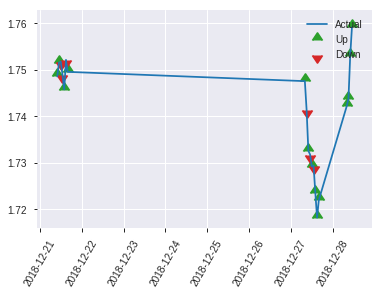


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19965667748495058
RMSE: 0.4468295843886689
LogLoss: 0.5844494832932046
Mean Per-Class Error: 0.29182960312838
AUC: 0.7549712954488726
pr_auc: 0.6798572030027269
Gini: 0.5099425908977453
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29423290491104126: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   70   0.5882   (70.0/119.0)
1      6    95   0.0594   (6.0/101.0)
Total  55   165  0.3455   (76.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.294233     0.714286  164
max f2                       0.232573     0.84048   178
max f0point5                 0.608073     0.694118  80
max accuracy                 0.608073     0.709091  80
max precision                0.821443     1         0
max recall                   0.074424     1         215
max specificity              0.821443     1         0
max absolute_mcc             0.477393     0.415564  115
max min_per_class_accuracy   0.529221     0.697479  106
max mean_per_class_accuracy  0.477393     0.70817   115

Gains/Lift Table: Avg response rate: 45.91 %, avg score: 46.98 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0136364                   0.810002           2.17822    2.17822            1                0.817052   1                           0.817052            0.029703        0.029703                   117.822    117.822
    2        0.0227273                   0.803847           1.08911    1.74257            0.5              0.8064     0.8                         0.812791            0.00990099      0.039604                   8.91089    74.2574
    3        0.0318182                   0.793961           1.08911    1.55587            0.5              0.802286   0.714286                    0.80979             0.00990099      0.049505                   8.91089    55.587
    4        0.0409091                   0.784292           2.17822    1.69417            1                0.787406   0.777778                    0.804816            0.019802        0.0693069                  117.822    69.4169
    5        0.05                        0.780133           2.17822    1.78218            1                0.782604   0.818182                    0.800777            0.019802        0.0891089                  117.822    78.2178
    6        0.1                         0.743268           1.18812    1.48515            0.545455         0.763611   0.681818                    0.782194            0.0594059       0.148515                   18.8119    48.5149
    7        0.15                        0.713487           1.78218    1.58416            0.818182         0.727285   0.727273                    0.763891            0.0891089       0.237624                   78.2178    58.4158
    8        0.2                         0.684663           1.78218    1.63366            0.818182         0.69975    0.75                        0.747856            0.0891089       0.326733                   78.2178    63.3663
    9        0.3                         0.638304           1.28713    1.51815            0.590909         0.661496   0.69697                     0.719069            0.128713        0.455446                   28.7129    51.8152
    10       0.4                         0.591282           1.48515    1.5099             0.681818         0.616134   0.693182                    0.693336            0.148515        0.60396                    48.5149    50.9901
    11       0.5                         0.501435           0.990099   1.40594            0.454545         0.550518   0.645455                    0.664772            0.0990099       0.70297                    -0.990099  40.5941
    12       0.6                         0.380012           0.792079   1.30363            0.363636         0.445557   0.598485                    0.628236            0.0792079       0.782178                   -20.7921   30.363
    13       0.7                         0.323858           0.990099   1.25884            0.454545         0.352257   0.577922                    0.588811            0.0990099       0.881188                   -0.990099  25.884
    14       0.8                         0.254763           0.792079   1.2005             0.363636         0.292575   0.551136                    0.551781            0.0792079       0.960396                   -20.7921   20.0495
    15       0.9                         0.137821           0.0990099  1.07811            0.0454545        0.186951   0.494949                    0.511244            0.00990099      0.970297                   -90.099    7.81078
    16       1                           0.0354712          0.29703    1                  0.136364         0.0965

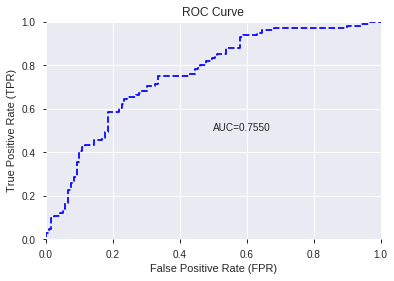

This function is available for GLM models only


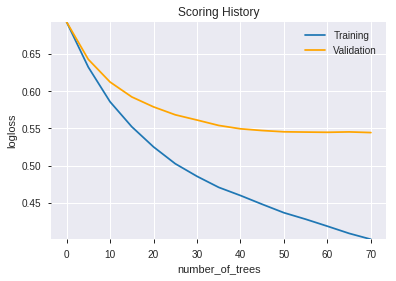

--2019-08-28 13:37:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_133650_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_133650_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b106',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'HT_DCPERIOD',
 'MFI_30',
 'BETA_8',
 'STOCHRSI_fastd',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'DX_8',
 'STDDEV_8',
 'CORREL_12',
 'STDDEV_12',
 'HT_PHASOR_quadrature',
 'ROC_8',
 'MACD_hist',
 'MFI_14',
 'ADOSC',
 'WILLR_30',
 'PLUS_DM_24',
 'STOCH_slowk',
 'ATR_8',
 'PLUS_DI_14',
 'MACDFIX_hist_14',
 'PLUS_DM_12',
 'WILLR_20',
 'ROCR_20',
 'CCI_24',
 'ATR_24',
 'ADX_24',
 'BBANDS_upperband_30_1_5',
 'MACD_signal',
 'LINEARREG_SLOPE_12',
 'CCI_14',
 'aroondown_20',
 'CORREL_8',
 'MINUS_DM_8',
 'BBANDS_middleband_24_0_5',
 'DX_24',
 'BBANDS_upperband_20_0_5',
 'MACDFIX_signal_20',
 'MFI_24',
 'ROCR100_12',
 'ROCP_14',
 'ROCR100_24',
 'LINEARREG_ANGLE_8',
 'STOCHRSI_fastk',
 'DX_20',
 'MINUS_DI_30',
 'DX_14',
 'AROONOSC_24',
 'MOM_12',
 'CDLSHORTLINE',
 'BBANDS_lowerband_24_7_5',
 'MINUS_DM_24',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_lowerband_30_2_2',
 'BBANDS_upperband_20_6_5',
 'aroonup_20',
 'LINEARREG_INTERCEPT_8',
 'RSI_20',
 'BBANDS_upperband_20_2_

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.723
GLM             0.714
XGBoost         0.709
dtype: float64

DeepLearning    GLM  XGBoost
All          0.668  0.700    0.700
DLF          0.709  0.682    0.695
Fwe          0.705  0.714    0.682
RFE          0.695  0.677    0.709
XGBF         0.723  0.682    0.695





F1


DeepLearning    0.715
GLM             0.712
XGBoost         0.720
dtype: float64

DeepLearning    GLM  XGBoost
All          0.700  0.684    0.712
DLF          0.706  0.678    0.700
Fwe          0.715  0.712    0.720
RFE          0.712  0.704    0.714
XGBF         0.708  0.678    0.700





auc


DeepLearning    0.752
GLM             0.746
XGBoost         0.755
dtype: float64

DeepLearning    GLM  XGBoost
All          0.720  0.724    0.749
DLF          0.724  0.705    0.732
Fwe          0.752  0.746    0.742
RFE          0.735  0.724    0.755
XGBF         0.732  0.705    0.732





logloss


DeepLearning    0.760
GLM             0.647
XGBoost         0.608
dtype: float64

DeepLearning    GLM  XGBoost
All          0.760  0.621    0.586
DLF          0.651  0.647    0.608
Fwe          0.629  0.600    0.606
RFE          0.664  0.615    0.584
XGBF         0.647  0.647    0.608





mean_per_class_error


DeepLearning    0.335
GLM             0.321
XGBoost         0.308
dtype: float64

DeepLearning    GLM  XGBoost
All          0.335  0.305    0.295
DLF          0.287  0.321    0.306
Fwe          0.297  0.282    0.308
RFE          0.296  0.318    0.292
XGBF         0.277  0.321    0.306





rmse


DeepLearning    0.481
GLM             0.471
XGBoost         0.458
dtype: float64

DeepLearning    GLM  XGBoost
All          0.481  0.462    0.448
DLF          0.468  0.471    0.458
Fwe          0.456  0.452    0.458
RFE          0.464  0.461    0.447
XGBF         0.466  0.471    0.458





mse


DeepLearning    0.231
GLM             0.222
XGBoost         0.209
dtype: float64

DeepLearning    GLM  XGBoost
All          0.231  0.213    0.201
DLF          0.219  0.222    0.209
Fwe          0.207  0.204    0.209
RFE          0.215  0.213    0.200
XGBF         0.217  0.222    0.209

{'F1':       DeepLearning    GLM  XGBoost
 All          0.700    NaN      NaN
 DLF          0.706    NaN      NaN
 DLF            NaN  0.678      NaN
 DLF            NaN    NaN    0.700
 All            NaN  0.684      NaN
 All            NaN    NaN    0.712
 XGBF         0.708    NaN      NaN
 XGBF           NaN  0.678      NaN
 XGBF           NaN    NaN    0.700
 Fwe          0.715    NaN      NaN
 Fwe            NaN  0.712      NaN
 Fwe            NaN    NaN    0.720
 RFE          0.712    NaN      NaN
 RFE            NaN  0.704      NaN
 RFE            NaN    NaN    0.714,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.668    NaN      NaN
 DLF          0.709    NaN      NaN
 DLF            NaN  0.682      NaN
 DLF            NaN    NaN    0.695
 All            NaN  0.700      NaN
 All            NaN    NaN    0.700
 XGBF         0.723    NaN      NaN
 XGBF           NaN  0.682      NaN
 XGBF           NaN    NaN    0.695
 Fwe          0.705    NaN      NaN
 Fwe     